In [2]:
## environment sklearn
## September 28, 2024
## We will use the CGF and CP data and then validate with 
## 1: weather stations
## 2: cameras (labeled with weather stations)
## 3: cameras labeled with model 
## 4: cameras labeled with WS and model

In [3]:
#### 
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt 
import glob
import pandas as pd 
import numpy as np 
from rasterio.features import geometry_mask
import geopandas as gpd
from pyproj import Transformer

In [4]:
rasters2017 = glob.glob('/Volumes/CATBREEN2/AMSR/clipped/2017/*')
rasters2018 = glob.glob('/Volumes/CATBREEN2/AMSR/clipped/2018/*')
rasters2019 = glob.glob('/Volumes/CATBREEN2/AMSR/clipped/2019/*')
rasters2020 = glob.glob('/Volumes/CATBREEN2/AMSR/clipped/2020/*')
rasters2021 = glob.glob('/Volumes/CATBREEN2/AMSR/clipped/2021/*')
rasters2022 = glob.glob('/Volumes/CATBREEN2/AMSR/clipped/2022/*')
rasters2023 = glob.glob('/Volumes/CATBREEN2/AMSR/clipped/2023/*')

ex_raster = rasterio.open(rasters2017[0])
print(rasters2018[0])
ex1 = ex_raster.read(1)
ex_transform1 = ex_raster.transform
height1, width1 = ex_raster.shape
print(height1, width1)
print(ex_raster.crs)

##downsample from 6km to 3km 
height1 = height1*2
width1 = width1*2

## upsample!! 
ex = ex_raster.read(
        out_shape=(ex_raster.count, height1, width1),
        resampling=Resampling.bilinear
    )
print(ex.shape)
ex = ex.squeeze()

/Volumes/CATBREEN2/AMSR/clipped/2018/AMSR2_Hland_L5_Tb_2018001A_18H_clipped.tif
394 582
EPSG:6931
(1, 788, 1164)


In [5]:
import rasterio
import geopandas as gpd
from shapely.geometry import box

# Get the bounding box of the raster (ex_raster is your raster object)
bbox = ex_raster.bounds

# Create a polygon from the bounding box
bbox_polygon = box(bbox.left, bbox.bottom, bbox.right, bbox.top)

# Create a GeoDataFrame with the bounding box polygon
gdf = gpd.GeoDataFrame({'geometry': [bbox_polygon]}, crs=ex_raster.crs)

# Export the GeoDataFrame as a shapefile
output_shapefile = 'raster_bounding_box.shp'
gdf.to_file(output_shapefile)

print(f"Bounding box exported to {output_shapefile}")

Bounding box exported to raster_bounding_box.shp


In [6]:
print(ex_raster.bounds[0])
print(ex_raster.bounds[2])
print(ex_raster.bounds[1])
print(ex_raster.bounds[3])

-828000.0011999998
2663999.9988
-3737999.9988
-1373999.9988000002


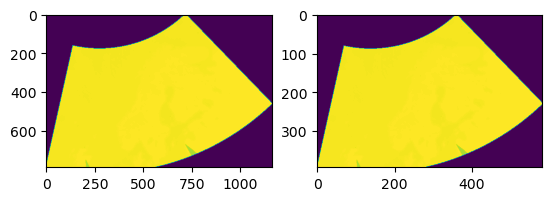

In [10]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(ex)
ax[1].imshow(ex1)

In [11]:
ex_raster.transform

Affine(6000.0, 0.0, -828000.0011999998,
       0.0, -6000.0, -1373999.9988000002)

In [12]:
ex_transform1

Affine(6000.0, 0.0, -828000.0011999998,
       0.0, -6000.0, -1373999.9988000002)

In [13]:
## new transform for 788 x 1164 rasters 
ex_transform1 = ex_raster.transform
new_pixel_width = (ex_transform1[0] * ex_raster.width) / width1
new_pixel_height = -(ex_transform1[4] * ex_raster.height) / height1
new_transform = rasterio.transform.from_origin(
    ex_transform1[2],  # Top-left x
    ex_transform1[5],  # Top-left y
    new_pixel_width,   # New pixel width
    new_pixel_height    # New pixel height
)

In [14]:
print(ex_transform1)
print(new_transform)

| 6000.00, 0.00,-828000.00|
| 0.00,-6000.00,-1374000.00|
| 0.00, 0.00, 1.00|
| 3000.00, 0.00,-828000.00|
| 0.00,-3000.00,-1374000.00|
| 0.00, 0.00, 1.00|


In [15]:
cgf2018 = glob.glob('/Volumes/CATBREEN2/CGF/GEE_aug26_24_CGF_6931/2018/*')
cgf2019 = glob.glob('/Volumes/CATBREEN2/CGF/GEE_aug26_24_CGF_6931/2019/*')
cgf2020 = glob.glob('/Volumes/CATBREEN2/CGF/GEE_aug26_24_CGF_6931/2020/*')
cgf2023 = glob.glob('')
cgf_files = cgf2018 + cgf2019 + cgf2020

In [16]:
cgf_dates = [i.split('/')[-1].split('.')[0].split('CGF_')[1] for i in cgf_files]
cgf_dict = dict(zip(cgf_dates, cgf_files))

In [17]:
sca2015 = glob.glob('/Volumes/CATBREEN2/modis_sca/2015/*')
sca2016 = glob.glob('/Volumes/CATBREEN2/modis_sca/2016/*')
sca2017 = glob.glob('/Volumes/CATBREEN2/modis_sca/2017/*')
sca2018 = glob.glob('/Volumes/CATBREEN2/modis_sca/2018/*')
sca2019 = glob.glob('/Volumes/CATBREEN2/modis_sca/2019/*')
sca2020 = glob.glob('/Volumes/CATBREEN2/modis_sca/2020/*')
sca2023 = glob.glob('/Volumes/CATBREEN2/modis_sca/2023/*')

sca_files = sca2015 + sca2016 + sca2017 + sca2018 + sca2019 + sca2020 + sca2023
sca_files = sorted(sca_files)

In [18]:
# #sca_test1 = '/Users/catherinebreen/Dropbox/Chapter4/rasters/sca_2023_113.tif'   #sca_test_extent_reproj.tif'
# sca_test = glob.glob('/Users/catherinebreen/Dropbox/Chapter4/rasters/sca_2023_*.tif')   #sca_test_extent_reproj.tif'
# print(len(sca_test))
# sca_raster = [rasterio.open(i) for i in sca_test]
# #[print(i.crs) for i in sca_raster]
# #[print(i.shape) for i in sca_raster]
# sca_list = [i.read(
#         out_shape=(i.count, height1, width1),
#         resampling=Resampling.nearest ## beause categorical
#     ) for i in sca_raster]
# sca_list = [i.squeeze() for i in sca_list]
# # water_mask = np.where(water== 210, 1.0, 0)

# fig, ax = plt.subplots(2,3, figsize = (12,6))
# ax[0,0].imshow(sca_list[0])
# ax[0,1].imshow(sca_list[1])
# ax[1,0].imshow(sca_list[2])
# ax[1,1].imshow(sca_list[3])
# ax[0,2].imshow(sca_list[4])
# ax[1,2].imshow(sca_list[5])



In [19]:
sca_dates = [file_name.split('/')[-1].split('_')[1][:8] for file_name in sca_files]
sca_dates = [f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}" for date_str in sca_dates]
sca_dates

sca_dict = dict(zip(sca_dates, sca_files))

from datetime import datetime, timedelta
date_ranges = {}

for start_date in sca_dates:
    start = datetime.strptime(start_date, '%Y-%m-%d')
    date_list = [(start + timedelta(days=i)).strftime('%Y-%m-%d') for i in range(8)]  # Include start date + 7 more days
    date_ranges[start_date] = date_list

sca_dict_dateranges = {} ## reverse dictionary
for key, value_list in date_ranges.items():
    for date in value_list:
        sca_dict_dateranges[date] = key  

In [20]:
for key, value in sca_dict_dateranges.items():
    #update value to 
    path = sca_dict[value]
    sca_dict_dateranges[key] = path
    #print(key,value)

In [21]:
last_50_values = list(sca_dict_dateranges.keys())[-130:-120]
last_50_values

['2020-05-30',
 '2020-05-31',
 '2023-01-01',
 '2023-01-02',
 '2023-01-03',
 '2023-01-04',
 '2023-01-05',
 '2023-01-06',
 '2023-01-07',
 '2023-01-08']

In [22]:
## reprojected from 3857 using reproject_rasters.ipynb 
#elevation_layer = '/Users/catherinebreen/Dropbox/Chapter4/shape_file/elevationmap_6931.tif'
elevation_layer = '/Users/catherinebreen/Dropbox/Chapter4/rasters/elevationmap_shp2.tif'
elev_raster = rasterio.open(elevation_layer)
print(elev_raster.crs)
print(elev_raster.shape)
elev = elev_raster.read(
        out_shape=(elev_raster.count, 2364, 3492), #height1, width1
        resampling=Resampling.bilinear
    )
elev = elev.squeeze()
print(elev.shape)
print(np.min(elev), np.max(elev))

elev_low = elev_raster.read(
        out_shape=(elev_raster.count, height1, width1), #height1, width1
        resampling=Resampling.bilinear
    )
elev_low = elev_low.squeeze()
print(elev_low.shape)
print(np.min(elev_low), np.max(elev_low))


EPSG:6931
(2364, 3494)
(2364, 3492)
-55 2241
(788, 1164)
-15 2086


EPSG:6931
(4728, 6986)
values [0. 1.]
(4728, 6984)


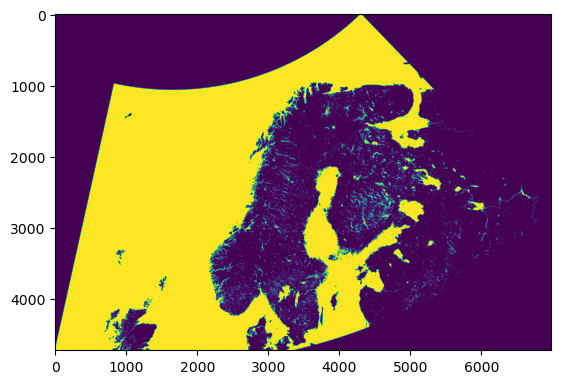

In [23]:
water_layer = '/Users/catherinebreen/Dropbox/Chapter4/rasters/watermap_shp2.tif'
water_raster = rasterio.open(water_layer)
print(water_raster.crs)
print(water_raster.shape)
water = water_raster.read(
        out_shape=(water_raster.count, 4728, 6984), #height1, width1
        resampling=Resampling.nearest ## beause categorical
    )
water = water.squeeze()
water_mask = np.zeros_like(water, dtype=np.float32)
water_mask[water == 210] = 1.0
# water_mask = np.where(water== 210, 1.0, 0)
plt.imshow(water_mask)
print('values',pd.unique(water_mask.flatten()))
print(water_mask.shape)
#plt.hist(water_mask, bins=2)

EPSG:6931
(4728, 6986)
values [0. 1.]
(788, 1164)


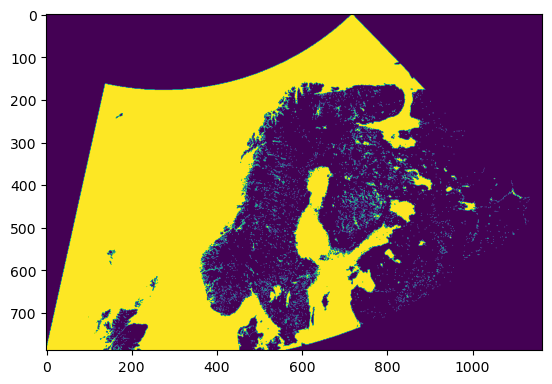

In [24]:
water_layer = '/Users/catherinebreen/Dropbox/Chapter4/rasters/watermap_shp2.tif'
water_raster2 = rasterio.open(water_layer)
print(water_raster2.crs)
print(water_raster2.shape)
water2 = water_raster2.read(
        out_shape=(water_raster2.count, height1, width1), #height1, width1
        resampling=Resampling.nearest ## beause categorical
    )
water2= water2.squeeze()
water_mask2 = np.zeros_like(water2, dtype=np.float32)
water_mask2[water2 == 210] = 1.0
# water_mask = np.where(water== 210, 1.0, 0)
plt.imshow(water_mask2)
print('values',pd.unique(water_mask2.flatten()))
print(water_mask2.shape)
#plt.hist(water_mask, bins=2)

EPSG:6931
(4728, 6986)
EPSG:6931
(4728, 6986)
EPSG:6931
(4728, 6986)


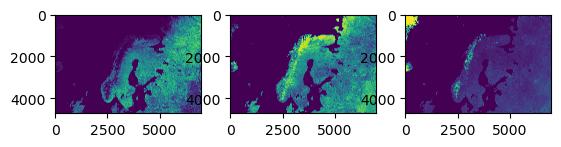

In [25]:
treecover_layer = '/Users/catherinebreen/Dropbox/Chapter4/rasters/vegetation2020_shp2.tif'
tree_raster = rasterio.open(treecover_layer)
print(tree_raster.crs)
print(tree_raster.shape)
tree = tree_raster.read(
        out_shape=(tree_raster.count, 4728, 6984), #height1, width1
        resampling=Resampling.nearest ## beause categorical
    )
tree = tree.squeeze()
# print(water)
# print('values',pd.unique(tree.flatten()))
# print(tree.shape)

veg_layer = '/Users/catherinebreen/Dropbox/Chapter4/rasters/NontreeVeg_shp2.tif'
veg_raster = rasterio.open(veg_layer)
print(veg_raster.crs)
print(veg_raster.shape)
veg = veg_raster.read(
        out_shape=(veg_raster.count, 4728, 6984),
        resampling=Resampling.nearest ## beause categorical
    )
veg = veg.squeeze()

nonveg_layer = '/Users/catherinebreen/Dropbox/Chapter4/rasters/NonVeg_shp2.tif'
nonveg_raster = rasterio.open(nonveg_layer)
print(nonveg_raster.crs)
print(nonveg_raster.shape)
nonveg = nonveg_raster.read(
        out_shape=(nonveg_raster.count, 4728, 6984),
        resampling=Resampling.nearest ## beause categorical
    )
nonveg = nonveg.squeeze()

fig, ax = plt.subplots(1,3)
ax[0].imshow(tree)
ax[1].imshow(veg)
ax[2].imshow(nonveg)


EPSG:6931
(4728, 6986)
(4728, 6984)


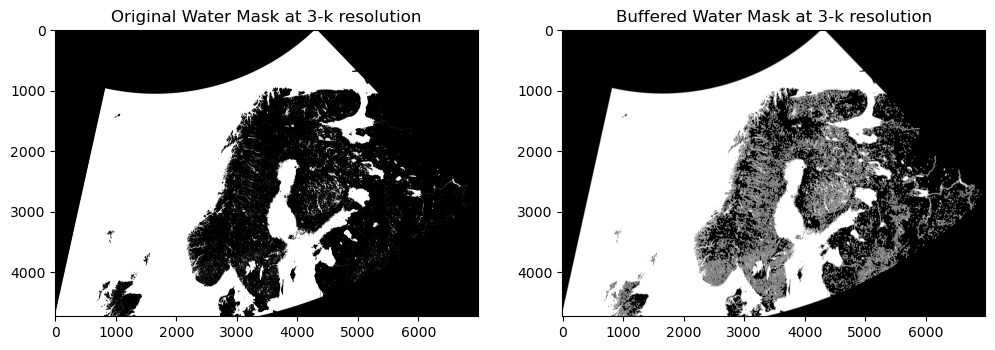

Original values: [0. 1.]
Buffered values: [0.  0.5 1. ]
Buffered mask shape: (4728, 6984)


In [26]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

# Open the water layer raster file
water_layer = '/Users/catherinebreen/Dropbox/Chapter4/rasters/watermap_shp2.tif'
water_raster = rasterio.open(water_layer)

# Print CRS and shape
print(water_raster.crs)
print(water_raster.shape)

# Read the raster data
water = water_raster.read(
        out_shape=(water_raster.count, 4728, 6984), #height1, width1
        resampling=rasterio.enums.Resampling.nearest  # because categorical
    )
water = water.squeeze()

# Create a mask where water values are 210
water_mask = np.zeros_like(water, dtype=np.float32)
water_mask[water == 210] = 1.0
print(water_mask.shape)
# Add a 4-pixel buffer to areas where the array is equal to 1
## for 500 m we want a 8-pix buffer, so 16x16
structure = np.ones((16, 16))  # Define the structure for dilation, 9x9 to ensure 4-pixel buffer; 5x5 is a 2pixel buffer

buffer_zone = binary_dilation(water_mask, structure=structure).astype(np.float32)

# Set buffer pixels to 0.5, but keep the original water pixels as 1
water_buffered_mask = np.where((buffer_zone == 1) & (water_mask == 0), 0.5, water_mask)


#         # Define the profile for the new raster
# profile = {
#     'driver': 'GTiff',
#     'height': 788,
#     'width': 1164,
#     'count': 1,
#     'dtype': np.uint8,
#     'crs': 'EPSG:6931',  # Replace with your desired CRS
#     'transform': new_transform,  # Adjust as needed
# }

# # Write the raster
# with rasterio.open('water_mask_buffered_NEWSHAPE.tif', 'w', **profile) as dst:
#     dst.write(water_buffered_mask, 1)


# Plot the original and buffered mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(water_mask, cmap='gray')
ax[0].set_title('Original Water Mask at 3-k resolution')
ax[1].imshow(water_buffered_mask, cmap='gray')
ax[1].set_title('Buffered Water Mask at 3-k resolution')
plt.show()

# Print unique values and shape of the buffered mask
print('Original values:', np.unique(water_mask))
print('Buffered values:', np.unique(water_buffered_mask))
print('Buffered mask shape:', water_buffered_mask.shape)


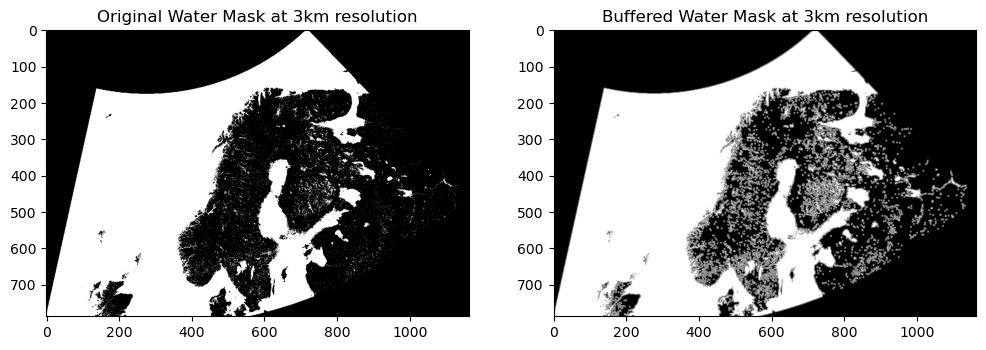

Original values: [0. 1.]
Buffered values: [0.  0.5 1. ]
Buffered mask shape: (788, 1164)


In [27]:
structure = np.ones((5, 5))  # Define the structure for dilation, 9x9 to ensure 4-pixel buffer; 5x5 is a 2pixel buffer

buffer_zone = binary_dilation(water_mask2, structure=structure).astype(np.float32)

# Set buffer pixels to 0.5, but keep the original water pixels as 1
water_buffered_mask2 = np.where((buffer_zone == 1) & (water_mask2 == 0), 0.5, water_mask2)

#         # Define the profile for the new raster
# profile = {
#     'driver': 'GTiff',
#     'height': 788,
#     'width': 1164,
#     'count': 1,
#     'dtype': np.uint8,
#     'crs': 'EPSG:6931',  # Replace with your desired CRS
#     'transform': new_transform,  # Adjust as needed
# }

# # Write the raster
# with rasterio.open('water_mask_buffered_NEWSHAPE.tif', 'w', **profile) as dst:
#     dst.write(water_buffered_mask, 1)


# Plot the original and buffered mask
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(water_mask2, cmap='gray')
ax[0].set_title('Original Water Mask at 3km resolution')
ax[1].imshow(water_buffered_mask2, cmap='gray')
ax[1].set_title('Buffered Water Mask at 3km resolution')
plt.show()

# Print unique values and shape of the buffered mask
print('Original values:', np.unique(water_mask2))
print('Buffered values:', np.unique(water_buffered_mask2))
print('Buffered mask shape:', water_buffered_mask2.shape)


In [28]:
#cgf_layer = '/Users/catherinebreen/Dropbox/Chapter4/shape_file/CGF_example_1000_6931.tif'
cgf_layer = cgf2018[0]
sca_layer = sca_dict_dateranges['2015-01-01']

def load_cgf(filepath):
    cgf_raster = rasterio.open(filepath)
    #print(cgf_raster.crs)
    #print(cgf_raster.shape)
    cgf = cgf_raster.read(
            out_shape=(cgf_raster.count,  2364, 3492), #height1, width1
            resampling=Resampling.bilinear
        )
    cgf = cgf.squeeze()
    cgf = np.where(cgf>=100, np.nan, cgf)
    #print(cgf)
    #print(np.min(cgf), np.max(cgf))
    return cgf

cgf = load_cgf(cgf_layer)


def load_sca(filepath):
    sca_raster = rasterio.open(filepath)
    #print(sca_raster.crs)
    #print(sca_raster.shape)
    sca = sca_raster.read(1,
            out_shape=(1, 2364, 3492), #height1, width1 ## should just be 1 because we have 1 band
            resampling=Resampling.nearest ## because categorical
                          )
    sca = sca.squeeze()
    #print(cgf)
    #print(np.min(cgf), np.max(cgf))
    return sca

sca = load_sca(sca_layer)  ## still have issues with polar night 


In [29]:
def load_sca_low(filepath):
    sca_raster = rasterio.open(filepath)
    sca = sca_raster.read(1,
            out_shape=(1, height1, width1), #height1, width1 ## should just be 1 because we have 1 band
            resampling=Resampling.nearest )
    sca = sca.squeeze()
    return sca

sca_low = load_sca_low(sca_layer) 

def load_cgf_low(filepath):
    cgf_raster = rasterio.open(filepath)
    cgf = cgf_raster.read(
            out_shape=(cgf_raster.count,  height1, width1), #height1, width1
            resampling=Resampling.bilinear
        )
    cgf = cgf.squeeze()
    cgf = np.where(cgf>=100, np.nan, cgf)
    return cgf

cgf_low = load_cgf_low(cgf_layer)


In [30]:
sca_raster_example = rasterio.open(sca_dict_dateranges['2015-01-01'])
moderate_res_transform = sca_raster_example.transform
new_pixel_width2 = (moderate_res_transform[0] * sca_raster_example.width) / 3492
new_pixel_height2 = -(moderate_res_transform[4] * sca_raster_example.height) / 2364
transform2 = rasterio.transform.from_origin(
    moderate_res_transform[2],  # Top-left x
    moderate_res_transform[5],  # Top-left y
    new_pixel_width2,   # New pixel width
    new_pixel_height2    # New pixel height
)
transform2

Affine(1000.5727376861397, 0.0, -829000.0,
       0.0, -1000.0, -1374000.0)

In [31]:
water_example = rasterio.open(water_layer)
high_res_transform = water_example.transform
new_pixel_width3 = (high_res_transform[0] * water_example.width) / 6986
new_pixel_height3 = -(high_res_transform[4] * water_example.height) / 4728
transform3 = rasterio.transform.from_origin(
    high_res_transform[2],  # Top-left x
    high_res_transform[5],  # Top-left y
    new_pixel_width3,   # New pixel width
    new_pixel_height3    # New pixel height
)
transform3

Affine(500.0, 0.0, -828500.0,
       0.0, -500.0, -1374000.0)

In [32]:
# #cgf_layer = '/Users/catherinebreen/Dropbox/Chapter4/shape_file/CGF_example_1000_6931.tif'
# cp_layer = '/Users/catherinebreen/Dropbox/Chapter4/shape_file/CP_2019-02-23_6931.tif'

# def load_cp(filepath):
#     cp_raster = rasterio.open(filepath)
#     print(cp_raster.crs)
#     print(cp_raster.shape)
#     cp = cp_raster.read(
#             out_shape=(cp_raster.count, height1, width1), #height1, width1
#             resampling=Resampling.bilinear
#         )
#     cp = cp.squeeze()
#     cp = np.where(cp>=100, np.nan, cp)
#     #print(cp)
#     #print(np.min(cgf), np.max(cgf))

#     #plt.hist(cp)
#     return cp

# cp = load_cp(cp_layer)

(788, 1164)
(2364, 3492)
(4728, 6984)
(2364, 3492)
(4728, 6984)


Text(0.5, 1.0, 'sca snow values')

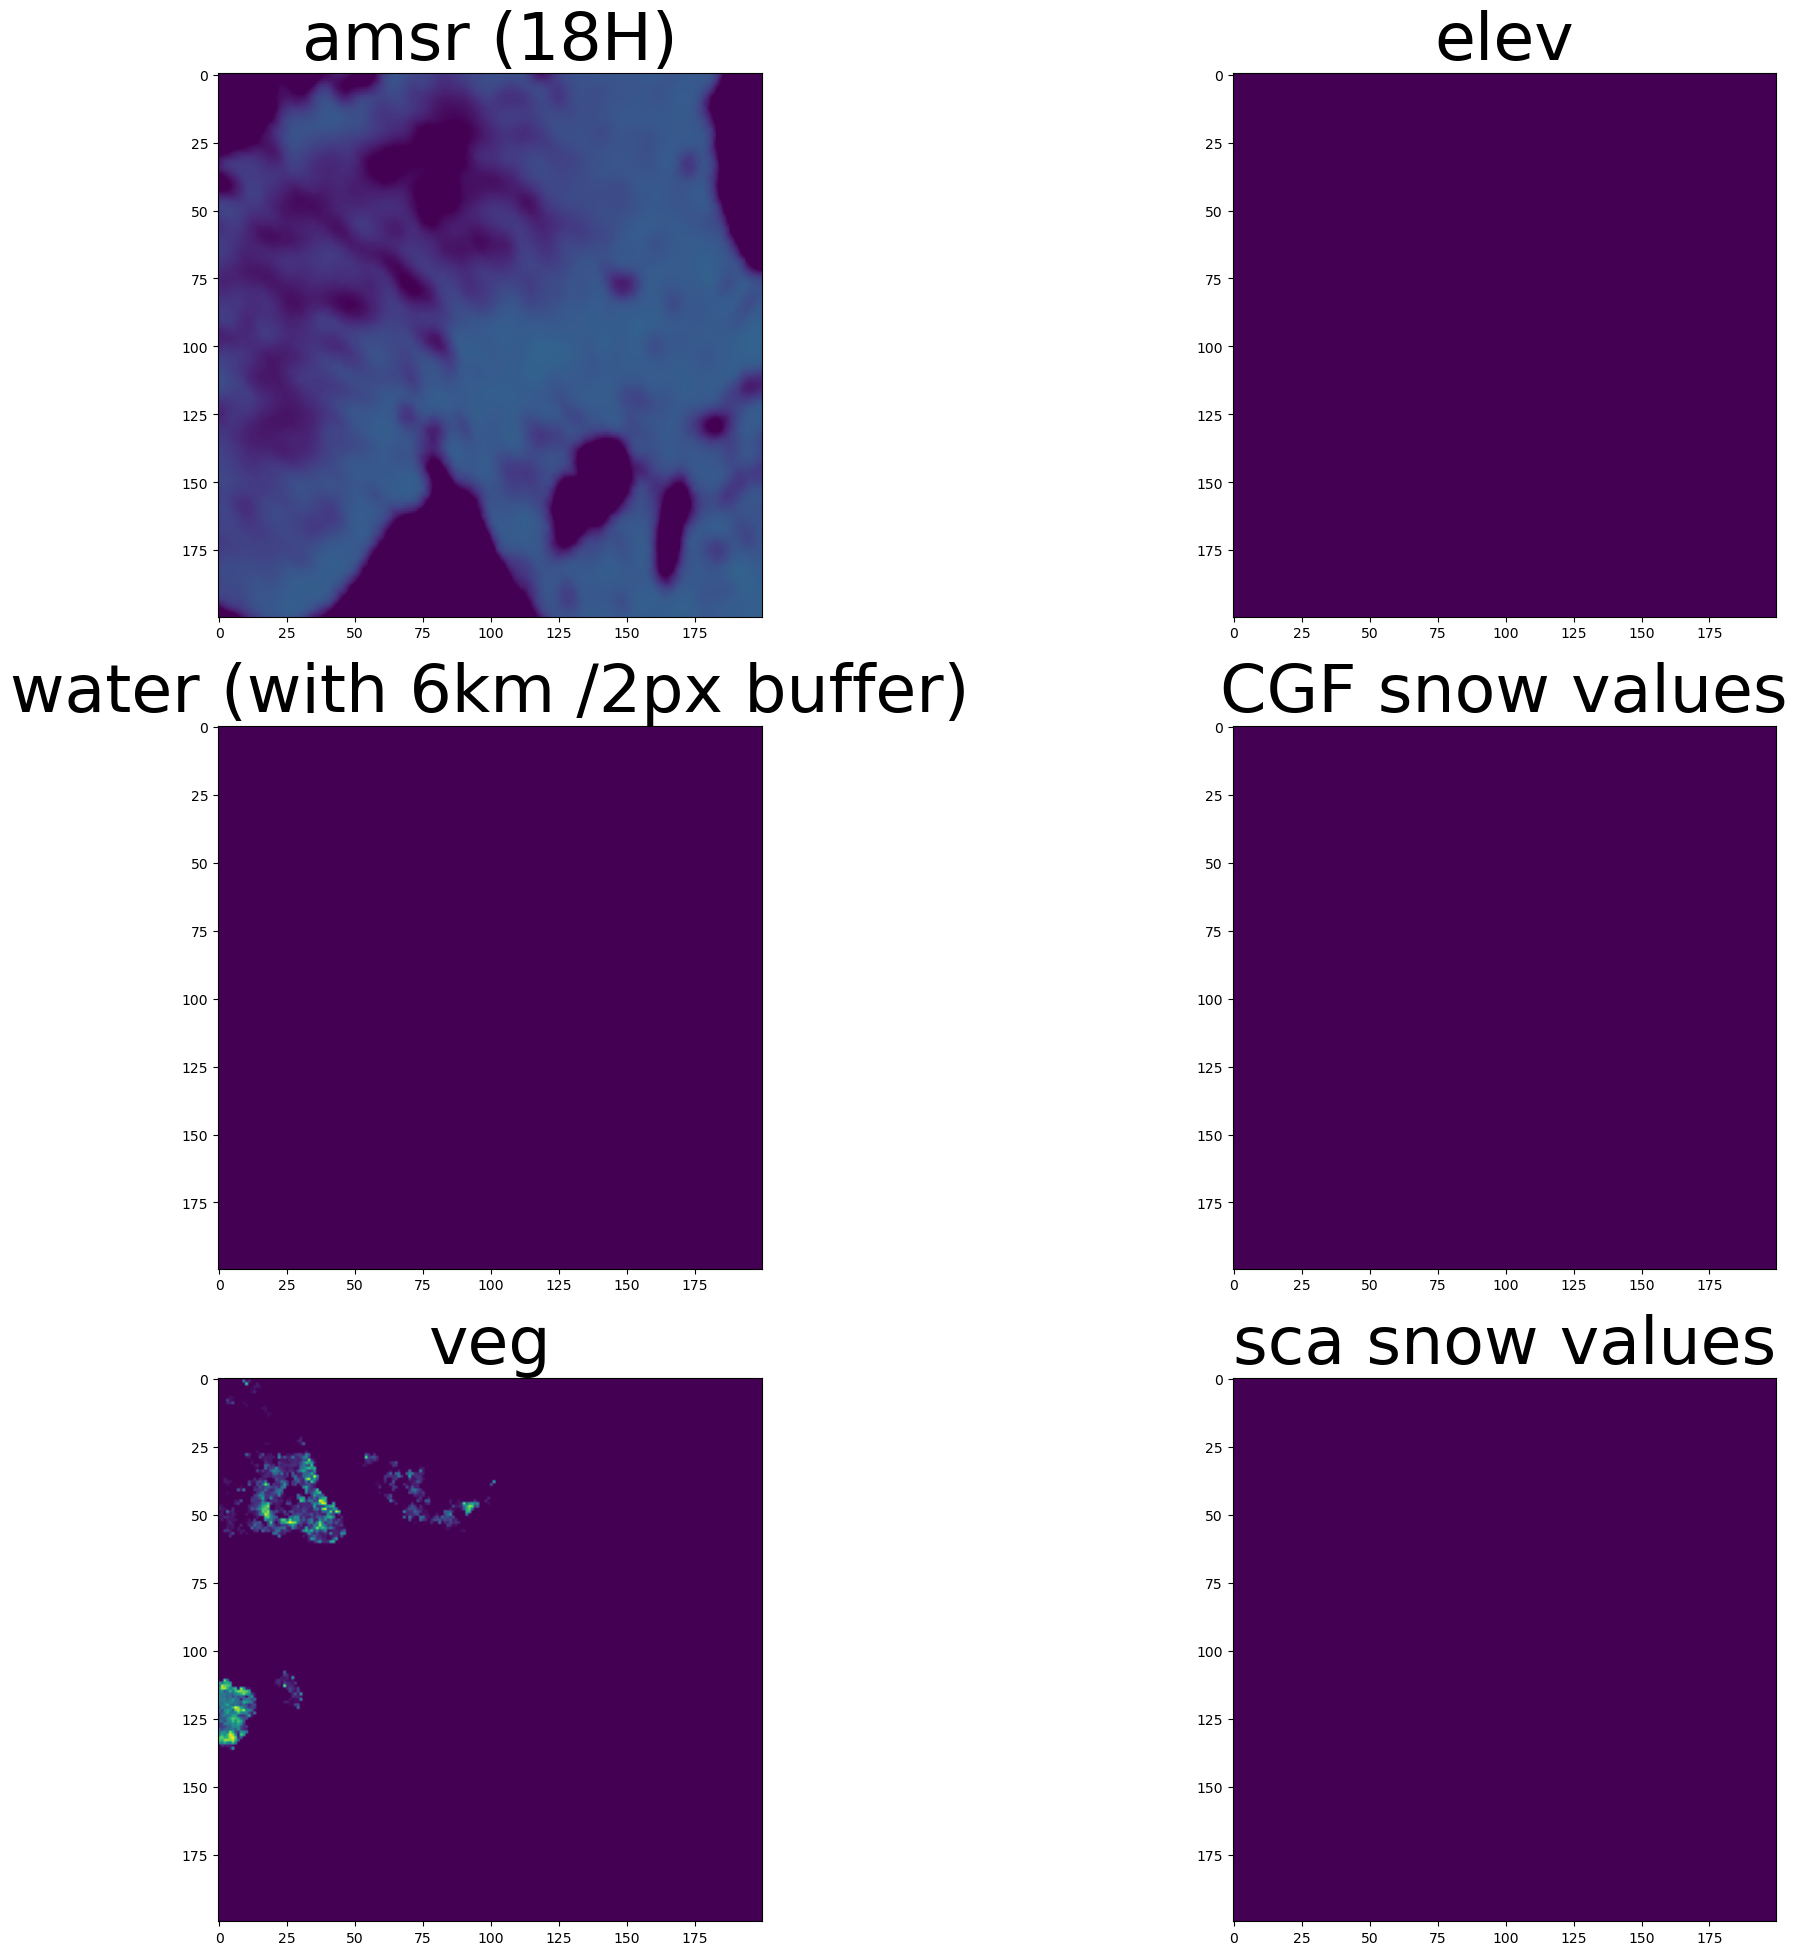

In [33]:
print(ex.shape)
print(elev.shape)
print(water.shape)
print(cgf.shape)
print(veg.shape)

x1 = 250 *2
x2 = 350 *2
y1 = 200 *2
y2 = 300 *2

fig, ax = plt.subplots(3,2, figsize = (24,24))
ax[0,0].imshow(ex[x1:x2, y1:y2], vmin=200, vmax=400)
ax[0,1].imshow(elev[x1:x2, y1:y2])
ax[1,0].imshow(water_buffered_mask[x1:x2, y1:y2])
ax[1,1].imshow(cgf[x1:x2, y1:y2], vmin=0, vmax=100)
ax[2,0].imshow(veg[x1:x2, y1:y2])
ax[2,1].imshow(sca[x1:x2, y1:y2], vmin=0, vmax=100)

ax[0,0].set_title('amsr (18H)',fontsize=48)
ax[0,1].set_title('elev', fontsize=48)
ax[1,0].set_title('water (with 6km /2px buffer)', fontsize=48)
ax[1,1].set_title('CGF snow values', fontsize=48)
ax[2,0].set_title('veg', fontsize=48)
ax[2,1].set_title('sca snow values', fontsize=48)



In [34]:

### make this a function 
def derive_GRP(root, year, day):
    v36p = f'{root}/{year}/AMSR2_Hland_L5_Tb_{year}{day}A_36V_clipped.tif'
    v36r = rasterio.open(v36p)
    # v36 = v36r.read(1)
    v36 = v36r.read(
            out_shape=(v36r.count, height1, width1),
            resampling=Resampling.bilinear
        ).squeeze()

    h36p = f'{root}/{year}/AMSR2_Hland_L5_Tb_{year}{day}A_36H_clipped.tif'
    h36r = rasterio.open(v36p)
    h36 = h36r.read(
            out_shape=(h36r.count, height1, width1),
            resampling=Resampling.bilinear
        ).squeeze()
    # h36 = h36r.read(1)

    v18p = f'{root}/{year}/AMSR2_Hland_L5_Tb_{year}{day}A_18V_clipped.tif'
    v18r = rasterio.open(v18p)
    # v18 = v18r.read(1)
    v18 = v18r.read(
            out_shape=(v18r.count, height1, width1),
            resampling=Resampling.bilinear
        ).squeeze()

    h18p = f'{root}/{year}/AMSR2_Hland_L5_Tb_{year}{day}A_18H_clipped.tif'
    h18r = rasterio.open(h18p)
    # h18 = h18r.read(1)
    h18 = h18r.read(
            out_shape=(h18r.count, height1, width1),
            resampling=Resampling.bilinear
        ).squeeze()

    GR_h_num = (h36 - h18)  ## returns negative values during ROS events (Dolant et al. 2016)
    GR_h_den = (h36 + h18)
    GR_h = np.divide(GR_h_num, GR_h_den, out=np.zeros_like(GR_h_num, dtype=float), where=GR_h_den!=0)

    GR_v_num = (v36 - v18)
    GR_v_den = (v36 + v18)
    GR_v = np.divide(GR_v_num, GR_v_den, out=np.zeros_like(GR_v_num, dtype=float), where=GR_v_den!=0)  ## returns positive values during ROS events (Dolant et al. 2016)

    GRP_event = np.divide(GR_v, GR_h, out=np.zeros_like(GR_v, dtype=float), where=GR_h!=0)  # Avoid division by zero
    ## elevation layer 
    #GRP_low = np.where((GRP_event < 1) & (elev <= 900), 1, 0)
    #GRP_high = np.where((GRP_event < -5) & (elev > 900), 1, 0)
    #GRP_comb = GRP_low + GRP_high
    return GRP_event # GRP_comb #GRP_event # GRP_comb


### example map for classification map for 2018-01-01
root = '/Volumes/CATBREEN2/AMSR/clipped/'
year = 2019
day = '100' ## what day is 054?? 

#GRP_event, GRP_comb = derive_GRP(root, year, day)
GRP_event = derive_GRP(root, year, day)


In [35]:
# cgf = load_cgf(cgf_dict['2018-01-05'])
# ROS_events = np.where(cgf > 40, GRP_comb, 0)
# GRP_values = np.where(cgf > 40, GRP_event, np.nan)

# fig, ax = plt.subplots(1,2)
# ax[0].imshow(ROS_events, vmin=0, vmax=1)
# ax[1].imshow(GRP_values, vmin=-5, vmax=5)


In [36]:
### loop through all the days and have a dictionary of date, GRP, cgf 
import tqdm 
import os
years = [2018, 2019, 2020, 2023]

rosdate = []
rosarray = []
grparray = []
cgfarrays = []
scaarrays = []

a = 0 
for year in years: 
    jan_to_apr = pd.date_range(start=f'{year}-01-01', end=f'{year}-04-30')
    oct_to_dec = pd.date_range(start=f'{year}-10-01', end=f'{year}-12-31')
    root = '/Volumes/CATBREEN2/AMSR/clipped/'

    i = 0 
    for day in tqdm.tqdm(jan_to_apr): 
    ### example map for classification map for 2018-01-01
        #print(day)
        doy = day.strftime('%j')
        day_str = day.strftime('%Y-%m-%d')
        y = year
        GRP_event = derive_GRP(root, year, doy)

        if year != 2023: cgf = load_cgf(cgf_dict[day_str])
        else: cgfarrays.append(np.full((2364, 3492), np.nan)) #788, 1164
        sca = load_sca(sca_dict_dateranges[day_str])

        sca_low = load_sca_low(sca_dict_dateranges[day_str])
        elev_low = elev_low
        if year != 2023: cgf_low = load_cgf_low(cgf_dict[day_str])
        ### refine ROS event step 
        #ROS_events = np.where(cgf > 40, GRP_comb, 0)
        #GRP_event = np.where(cgf > 40, GRP_event, -9999) ## ## if we put zero it will get counted as ROS!!

        if i == 0: 
            # ROS_events2 = np.where((cgf > 40) & (elev < 900) & (GRP_event < 1), 1, 0)
            # ROS_events1 = np.where((cgf > 40) & (elev >= 900) & (GRP_event < -5), 1, 0)
            ROS_events2 = np.where(((sca_low == 200) | (cgf_low > 40)) & (elev_low < 900) & (GRP_event < 1), 1, 0)
            ROS_events1 = np.where(((sca_low == 200) | (cgf_low > 40)) & (elev_low >= 900) & (GRP_event < -5), 1, 0)
            ROS_events = ROS_events2 + ROS_events1
        else: 
            daybefore = grparray[a-1]
            # ROS_events1 = np.where((cgf > 40) & (elev < 900) 
            #                       & (GRP_event < 1) & (daybefore > 1), 1, 0)
            # ROS_events2 = np.where((cgf > 40) & (elev >= 900) 
            #                       & (GRP_event < -5) & (daybefore > -5), 1, 0)
            ROS_events1 = np.where(((sca_low == 200) | (cgf_low > 40) )& (elev_low < 900) 
                                  & (GRP_event < 1) & (daybefore > 1), 1, 0) #& (daybefore > 1)
            ROS_events2 = np.where(((sca_low == 200) | (cgf_low > 40)) & (elev_low >= 900) 
                                  & (GRP_event < -5) & (daybefore > -5), 1, 0) #& (daybefore > -5)
            ROS_events = ROS_events2 + ROS_events1
        #ROS_events = (np.full((788, 1164), np.nan))

        transform = new_transform
        #np.save(f'/Volumes/CATBREEN2/ros_arrays/{year}/ROS_events_{day_str}.npy', ROS_events)
        rosdate.append(day_str), rosarray.append(ROS_events), grparray.append(GRP_event), cgfarrays.append(cgf)
        scaarrays.append(sca)

                # Define the profile for the new raster
        profile = {
            'driver': 'GTiff',
            'height': 788,
            'width': 1164,
            'count': 1,
            'dtype': np.uint8,
            'crs': 'EPSG:6931',  # Replace with your desired CRS
            'transform': new_transform,  # Adjust as needed
        }
        # Write the raster
        path = os.path.join(f'/Volumes/CATBREEN2/grp_arrays_drysnow/{year}/', f'GRP_ratio_{day_str}.tif')
        with rasterio.open(path, 'w', **profile) as dst:
            dst.write(ROS_events, 1)

        i+=1
        a+=1

    if (year == 2018) or (year == 2019): 
        i = 0
        for day in tqdm.tqdm(oct_to_dec): 
            doy = day.strftime('%j')
            day_str = day.strftime('%Y-%m-%d')
            y = year
            GRP_event = derive_GRP(root, year, doy)
            if year != 2023: cgf = load_cgf(cgf_dict[day_str])
            else: cgfarrays.append(np.full((2364, 3492), np.nan)) #788, 1164
            cgf = load_cgf(cgf_dict[day_str])
            sca = load_sca(sca_dict_dateranges[day_str])

            sca_low = load_sca_low(sca_dict_dateranges[day_str])
            elev_low = elev_low
            if year != 2023: cgf_low = load_cgf_low(cgf_dict[day_str])

            # #GRP_event = np.where(cgf > 40, GRP_event, -9999) ## ## if we put zero it will get counted as ROS!!
            if i == 0: 
                # ROS_events2 = np.where((cgf > 40) & (elev < 900) & (GRP_event < 1), 1, 0)
                # ROS_events1 = np.where((cgf > 40) & (elev >= 900) & (GRP_event < -5), 1, 0)
                ROS_events2 = np.where(((sca_low == 200) | (cgf_low > 40)) & (elev_low < 900) & (GRP_event < 1), 1, 0)
                ROS_events1 = np.where(((sca_low == 200) | (cgf_low > 40)) & (elev_low >= 900) & (GRP_event < -5), 1, 0)
                ROS_events = ROS_events2 + ROS_events1
            else: 
                daybefore = grparray[a-1]
                # ROS_events1 = np.where((cgf > 40) & (elev < 900) 
                #                     & (GRP_event < 1) & (daybefore > 1), 1, 0)
                # ROS_events2 = np.where((cgf > 40) & (elev >= 900) 
                #                     & (GRP_event < -5) & (daybefore > -5), 1, 0)
                ROS_events1 = np.where(((sca_low == 200) | (cgf_low > 40)) & (elev_low < 900) 
                                  & (GRP_event < 1) & (daybefore > 1), 1, 0) # & (daybefore > 1)
                ROS_events2 = np.where(((sca_low == 200) | (cgf_low > 40)) & (elev_low >= 900) 
                                  & (GRP_event < -5) & (daybefore > -5), 1, 0) #& (daybefore > 1)
                ROS_events = ROS_events2 + ROS_events1

            ## save as array ?? or raster?? try array first 
            #np.save(f'/Volumes/CATBREEN2/ros_arrays/{year}/ROS_events_{day_str}.npy', ROS_events)
            path = os.path.join(f'/Volumes/CATBREEN2/grp_arrays_drysnow/{year}/', f'GRP_ratio_{day_str}.tif')
            rosdate.append(day_str), rosarray.append(ROS_events), grparray.append(GRP_event), cgfarrays.append(cgf)
            scaarrays.append(sca)
                            # Define the profile for the new raster
            profile = {
                'driver': 'GTiff',
                'height': 788,
                'width': 1164,
                'count': 1,
                'dtype': np.uint8,
                'crs': 'EPSG:6931',  # Replace with your desired CRS
                'transform': new_transform,  # Adjust as needed
            }
            # Write the raster
            with rasterio.open(path, 'w', **profile) as dst:
                dst.write(ROS_events, 1)
            i+=1
            a+=1
    else: pass

100%|██████████| 120/120 [00:38<00:00,  3.15it/s]


In [37]:
# # c = clean
# ROS_eventc = np.where(water_mask > 0, np.nan, ROS_events)
# plt.imshow(ROS_eventc[x1-50:x2, y1:y2])

In [38]:
# ROS_eventc = np.where(water_buffered_mask > 0.6, np.nan, ROS_events)
# ROS_eventc = np.where((water_buffered_mask > 0) & (water_buffered_mask < 0.6), 0.5, ROS_eventc)

# fig, ax = plt.subplots(1,2)
# ax[0].imshow(ROS_eventc[x1-50:x2, y1:y2], vmin=0, vmax=1)
# ax[1].imshow(water_buffered_mask[x1-50:x2, y1:y2])

In [39]:
ws_data = pd.read_csv('/Users/catherinebreen/Dropbox/Chapter4/ws_28_precip_temp_snowdepth_wlatlong.csv')

In [40]:
ws_data_unique = ws_data[['id', 'longitude', 'latitude']].drop_duplicates()
ws_data_unique.to_csv('/Users/catherinebreen/Dropbox/Chapter4/ws_28_gee.csv')


In [41]:
## Weather stations: R2
## do a point extraction at all the rasters for eveyry day at these points: 
ws_data = pd.read_csv('/Users/catherinebreen/Dropbox/Chapter4/ws_28_precip_temp_snowdepth_wlatlong.csv')
# Define the transformer from EPSG:4326 to EPSG:6931
transformer = Transformer.from_crs("epsg:4326", "epsg:6931", always_xy=True)

# Apply the transformation to each row in the DataFrame
ws_data[['longitude_6931', 'latitude_6931']] = ws_data.apply(
    lambda row: transformer.transform(row['longitude'], row['latitude']), axis=1, result_type='expand'
)
ws_data.head()

,Unnamed: 0.1,index,id,referenceTime,precip,air_temp10M,snowdepth,rain_on_snow,month,Unnamed: 0,name,location,longitude,latitude,year,longitude_6931,latitude_6931
0,0,0,SN17850,2017-01-01T00:00:00.000Z,0.0,-0.5,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06
1,1,1,SN17850,2017-01-01T01:00:00.000Z,0.0,-1.1,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06
2,2,2,SN17850,2017-01-01T02:00:00.000Z,0.0,-0.6,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06
3,3,3,SN17850,2017-01-01T03:00:00.000Z,0.0,-0.5,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06
4,4,4,SN17850,2017-01-01T04:00:00.000Z,0.0,-1.9,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06


In [42]:
## from cohen -- temp greater than 1
## from mooney -- precip greater than 5 mm and snow depth greater than 3mm 
ws_data['rain_on_snow2'] = ((ws_data['air_temp10M'] > 1) & 
                       (ws_data['precip'] > 0.5) & 
                       (ws_data['snowdepth'] > 5)).astype(int)

In [43]:
ws_data.head()

,Unnamed: 0.1,index,id,referenceTime,precip,air_temp10M,snowdepth,rain_on_snow,month,Unnamed: 0,name,location,longitude,latitude,year,longitude_6931,latitude_6931,rain_on_snow2
0,0,0,SN17850,2017-01-01T00:00:00.000Z,0.0,-0.5,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06,0
1,1,1,SN17850,2017-01-01T01:00:00.000Z,0.0,-1.1,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06,0
2,2,2,SN17850,2017-01-01T02:00:00.000Z,0.0,-0.6,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06,0
3,3,3,SN17850,2017-01-01T03:00:00.000Z,0.0,-0.5,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06,0
4,4,4,SN17850,2017-01-01T04:00:00.000Z,0.0,-1.9,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06,0


In [44]:
import rasterio
from rasterio.warp import transform

# Extract longitude and latitude into lists
longitudes = ws_data['longitude'].tolist()
latitudes = ws_data['latitude'].tolist()

# Define the source (EPSG:4326) and destination (EPSG:6931) CRS
src_crs = "EPSG:4326"
dst_crs = "EPSG:6931"

# Perform the transformation
longitude_6931, latitude_6931 = transform(src_crs, dst_crs, longitudes, latitudes)

# Assign the transformed coordinates back to the DataFrame
ws_data['longitude_6931'] = longitude_6931
ws_data['latitude_6931'] = latitude_6931

ws_data.head()

,Unnamed: 0.1,index,id,referenceTime,precip,air_temp10M,snowdepth,rain_on_snow,month,Unnamed: 0,name,location,longitude,latitude,year,longitude_6931,latitude_6931,rain_on_snow2
0,0,0,SN17850,2017-01-01T00:00:00.000Z,0.0,-0.5,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06,0
1,1,1,SN17850,2017-01-01T01:00:00.000Z,0.0,-1.1,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06,0
2,2,2,SN17850,2017-01-01T02:00:00.000Z,0.0,-0.6,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06,0
3,3,3,SN17850,2017-01-01T03:00:00.000Z,0.0,-0.5,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06,0
4,4,4,SN17850,2017-01-01T04:00:00.000Z,0.0,-1.9,0.8,0,1,243,ÅS,"[10.7818, 59.6605]",10.7818,59.6605,2017,625997.501209,-3.287267e+06,0


In [45]:
import rasterio
from rasterio.transform import rowcol

################ point extraction for weather stations ################

### get transform ### 
transform1 = new_transform #ex_transform1

ws_data_summary = ws_data.drop_duplicates(subset=['longitude_6931','latitude_6931'])
# Loop through each point in the dataframe and extract raster values

stations = []
dates = []
point = []
values = []
grpvalues = []
waters = []
waterslow = []
elevs = []
cgfs = []
scas = []
trees = []
vegs = []
nonvegs = []
rowsWS = []
colsWS = []
rowsWS2 = []
colsWS2 = []
rowsWS3 = []
colsWS3 = []


for date, array, grparray_, snowarray, scaarray in tqdm.tqdm(zip(rosdate, rosarray, grparray, cgfarrays, scaarrays)):
    for idx, row in ws_data_summary.iterrows():
        station = row['id']
        x, y = row['longitude_6931'], row['latitude_6931']  # These are the coordinates in EPSG:6931

        # Convert the coordinates (long_6931, lat_6931) to row/col in the raster
        col, row = rowcol(transform1, x, y) 
        col2, row2 = rowcol(transform2, x, y) 
        col3, row3 = rowcol(transform3, x, y) 

        # Check if the row/col are within the bounds of the array
      #  if 0 <= row < array.shape[0] and 0 <= col < array.shape[1]:
            # Extract the raster value at the given row/col
            ## low res ##
        value = array[col, row]
        grpvalue = grparray_[col, row]
        water_low = water_buffered_mask2[col, row]
            ## med res ##
        snow = snowarray[col2,row2]
        sca__ = scaarray[col2, row2]
        elev_ = elev[col2, row2]
            ## high res ## 
        water_ = water_buffered_mask[col3, row3]
        tree_ = tree[col3, row3]
        veg_ = veg[col3, row3]
        nonveg_ = nonveg[col3, row3]

        rowsWS.append(row)
        colsWS.append(col)
        rowsWS2.append(row2)
        colsWS2.append(col2)
        rowsWS3.append(row3)
        colsWS3.append(col3)

        # Append the value to the result lists
        stations.append(station)
        dates.append(date)
        point.append((x, y))  # You can append any relevant info here
        values.append(value)
        grpvalues.append(grpvalue)
        waters.append(water_)
        waterslow.append(water_low)
        elevs.append(elev_)
        cgfs.append(snow)
        scas.append(sca__)
        trees.append(tree_), vegs.append(veg_), nonvegs.append(nonveg_)
        # else:
        #     stations.append(station)
        #     dates.append(date)
        #     point.append((x, y))  # You can append any relevant info here
        #     values.append(np.nan)  # Append NaN if the point is out of bounds
        #     waters.append(np.nan)

# Convert the results into a pandas dataframe (optional)
results_df = pd.DataFrame({
    'id': stations, 
    'date': dates,
    'coordinates': point,
    'row': rowsWS,
    'col':colsWS,
    'raster_value': values,
    'grp_value': grpvalues,
    'snow':cgfs,
    'sca':scas,
    'water': waters,
    'waterlow':waterslow,
    'elev': elevs,
    'tree': trees,
    'veg':vegs,
    'nonvegs':nonvegs
})

# Print or inspect the results
print(results_df)

665it [00:05, 120.82it/s]


             id        date                               coordinates  row  \
0       SN17850  2018-01-01   (625997.5012093408, -3287266.558856216)  484   
1       SN82110  2018-01-01   (656601.4055017126, -2433165.097854618)  494   
2       SN18950  2018-01-01   (613079.2920956521, -3254208.212669403)  480   
3        SN4455  2018-01-01  (620604.8086681335, -3238988.3595577916)  482   
4       SN20280  2018-01-01    (587188.214226801, -3241967.922367005)  471   
...         ...         ...                                       ...  ...   
121690   SN4780  2023-04-30    (631818.5329561847, -3226307.17074816)  486   
121691  SN27161  2023-04-30   (609347.0541409496, -3320560.603777243)  479   
121692  SN24710  2023-04-30   (545378.6030075263, -3222761.544013351)  457   
121693  SN27282  2023-04-30   (609476.6721294345, -3333785.547590818)  479   
121694  SN27162  2023-04-30  (613461.0166853408, -3322884.3094014525)  480   

        col  raster_value  grp_value  snow  sca  water  waterlo

In [46]:
import numpy as np

results_df['datetime'] = pd.to_datetime(results_df['date'])
results_df = results_df.sort_values(by=['id', 'datetime'])

# Define the conditions
condition1 = (results_df['elev'] <= 900) & (results_df['grp_value'] < 1) & ((results_df['sca'] == 200) | (results_df['snow'] >= 40)) 
condition2 = (results_df['elev'] > 900) & (results_df['grp_value'] < -5) & ((results_df['sca'] == 200) | (results_df['snow'] >= 40)) 

# Create the new column 'ros_event'
results_df['ros_event'] = np.where(condition1 | condition2, 1, 0)

# Define the conditions
condition3 = (results_df['elev'] <= 900) & (results_df['grp_value'] < 0.75) & ((results_df['sca'] == 200) | (results_df['snow'] >= 40)) 
condition4 = (results_df['elev'] > 900) & (results_df['grp_value'] < -5) & ((results_df['sca'] == 200) | (results_df['snow'] >= 40)) 

condition5 = (results_df['elev'] <= 900) & (results_df['grp_value'] < 0.02) & ((results_df['sca'] == 200) | (results_df['snow'] >= 40)) 
condition6 = (results_df['elev'] > 900) & (results_df['grp_value'] < -5) & ((results_df['sca'] == 200) | (results_df['snow'] >= 40)) 

# Define the new conditions that also reference the grp_value from the previous row
condition7 = (results_df['elev'] <= 900) & (results_df['grp_value'] < 1) & \
             ((results_df['sca'] == 200) | (results_df['snow'] >= 40)) & (results_df['grp_value'].shift(1) > 1)

condition8 = (results_df['elev'] > 900) & (results_df['grp_value'] < -5) & \
             ((results_df['sca'] == 200) | (results_df['snow'] >= 40)) & \
                (results_df['grp_value'].shift(1) > -5)


condition9 = (results_df['elev'] <= 900) & (results_df['grp_value'] < -0.02) & ((results_df['sca'] == 200) | (results_df['snow'] >= 40)) 
condition10 = (results_df['elev'] > 900) & (results_df['grp_value'] < -5) & ((results_df['sca'] == 200) | (results_df['snow'] >= 40)) 


# Create the new column 'ros_event'
results_df['ros_event'] = np.where(condition1 | condition2, 1, 0)
results_df['ros_event75'] = np.where(condition3 | condition4, 1, 0)
results_df['ros_event02'] = np.where(condition5 | condition6, 1, 0)
results_df['ros_event_roc'] = np.where(condition9 | condition10, 1, 0)
results_df['ros_event_drysnowcheck'] = np.where(condition7 | condition8, 1, 0)

1


(array([51205., 33250., 11305.,  7980.,  4655.,  5320.,  4655.,  1330.,
         1330.,   665.]),
 array([   0. ,  101.5,  203. ,  304.5,  406. ,  507.5,  609. ,  710.5,
         812. ,  913.5, 1015. ]),
 <BarContainer object of 10 artists>)

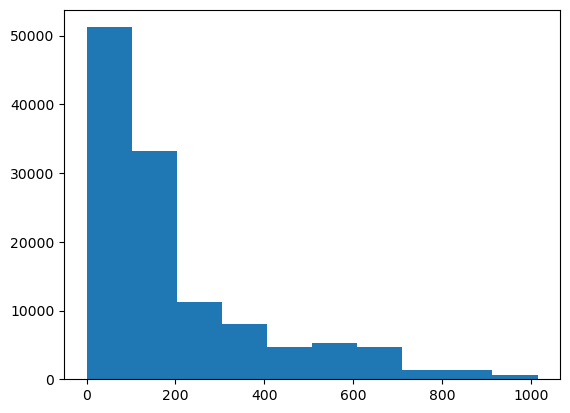

In [47]:
print(len(pd.unique(results_df[results_df['elev']>900]['id'])))
plt.hist(results_df['elev'])

In [48]:
results_df

,id,date,coordinates,row,col,raster_value,grp_value,snow,sca,water,...,elev,tree,veg,nonvegs,datetime,ros_event,ros_event75,ros_event02,ros_event_roc,ros_event_drysnowcheck
157,SN1070,2018-01-01,"(653073.6061181448, -3349737.325739172)",493,658,1,0.218387,74.0,200,0.5,...,0,42,44,14,2018-01-01,1,1,0,0,0
340,SN1070,2018-01-02,"(653073.6061181448, -3349737.325739172)",493,658,0,0.180623,22.0,200,0.5,...,0,42,44,14,2018-01-02,1,1,0,0,0
523,SN1070,2018-01-03,"(653073.6061181448, -3349737.325739172)",493,658,0,0.186358,22.0,200,0.5,...,0,42,44,14,2018-01-03,1,1,0,0,0
706,SN1070,2018-01-04,"(653073.6061181448, -3349737.325739172)",493,658,0,0.182660,22.0,200,0.5,...,0,42,44,14,2018-01-04,1,1,0,0,0
889,SN1070,2018-01-05,"(653073.6061181448, -3349737.325739172)",493,658,0,0.189422,22.0,200,0.5,...,0,42,44,14,2018-01-05,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120879,SN90,2023-04-26,"(666609.9111967915, -3118839.1837561564)",498,581,0,-1.130119,65.0,200,0.5,...,591,32,59,9,2023-04-26,1,1,1,1,0
121062,SN90,2023-04-27,"(666609.9111967915, -3118839.1837561564)",498,581,0,-0.121881,NaN,200,0.5,...,591,32,59,9,2023-04-27,1,1,1,1,0
121245,SN90,2023-04-28,"(666609.9111967915, -3118839.1837561564)",498,581,0,-0.368521,65.0,200,0.5,...,591,32,59,9,2023-04-28,1,1,1,1,0
121428,SN90,2023-04-29,"(666609.9111967915, -3118839.1837561564)",498,581,0,0.001420,NaN,200,0.5,...,591,32,59,9,2023-04-29,1,1,1,0,0


In [49]:
results_df.to_csv('results_df_3k_1k_500m.csv')

In [50]:
results_df[results_df['ros_event'] == 1]

,id,date,coordinates,row,col,raster_value,grp_value,snow,sca,water,...,elev,tree,veg,nonvegs,datetime,ros_event,ros_event75,ros_event02,ros_event_roc,ros_event_drysnowcheck
157,SN1070,2018-01-01,"(653073.6061181448, -3349737.325739172)",493,658,1,0.218387,74.0,200,0.5,...,0,42,44,14,2018-01-01,1,1,0,0,0
340,SN1070,2018-01-02,"(653073.6061181448, -3349737.325739172)",493,658,0,0.180623,22.0,200,0.5,...,0,42,44,14,2018-01-02,1,1,0,0,0
523,SN1070,2018-01-03,"(653073.6061181448, -3349737.325739172)",493,658,0,0.186358,22.0,200,0.5,...,0,42,44,14,2018-01-03,1,1,0,0,0
706,SN1070,2018-01-04,"(653073.6061181448, -3349737.325739172)",493,658,0,0.182660,22.0,200,0.5,...,0,42,44,14,2018-01-04,1,1,0,0,0
889,SN1070,2018-01-05,"(653073.6061181448, -3349737.325739172)",493,658,0,0.189422,22.0,200,0.5,...,0,42,44,14,2018-01-05,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120879,SN90,2023-04-26,"(666609.9111967915, -3118839.1837561564)",498,581,0,-1.130119,65.0,200,0.5,...,591,32,59,9,2023-04-26,1,1,1,1,0
121062,SN90,2023-04-27,"(666609.9111967915, -3118839.1837561564)",498,581,0,-0.121881,NaN,200,0.5,...,591,32,59,9,2023-04-27,1,1,1,1,0
121245,SN90,2023-04-28,"(666609.9111967915, -3118839.1837561564)",498,581,0,-0.368521,65.0,200,0.5,...,591,32,59,9,2023-04-28,1,1,1,1,0
121428,SN90,2023-04-29,"(666609.9111967915, -3118839.1837561564)",498,581,0,0.001420,NaN,200,0.5,...,591,32,59,9,2023-04-29,1,1,1,0,0


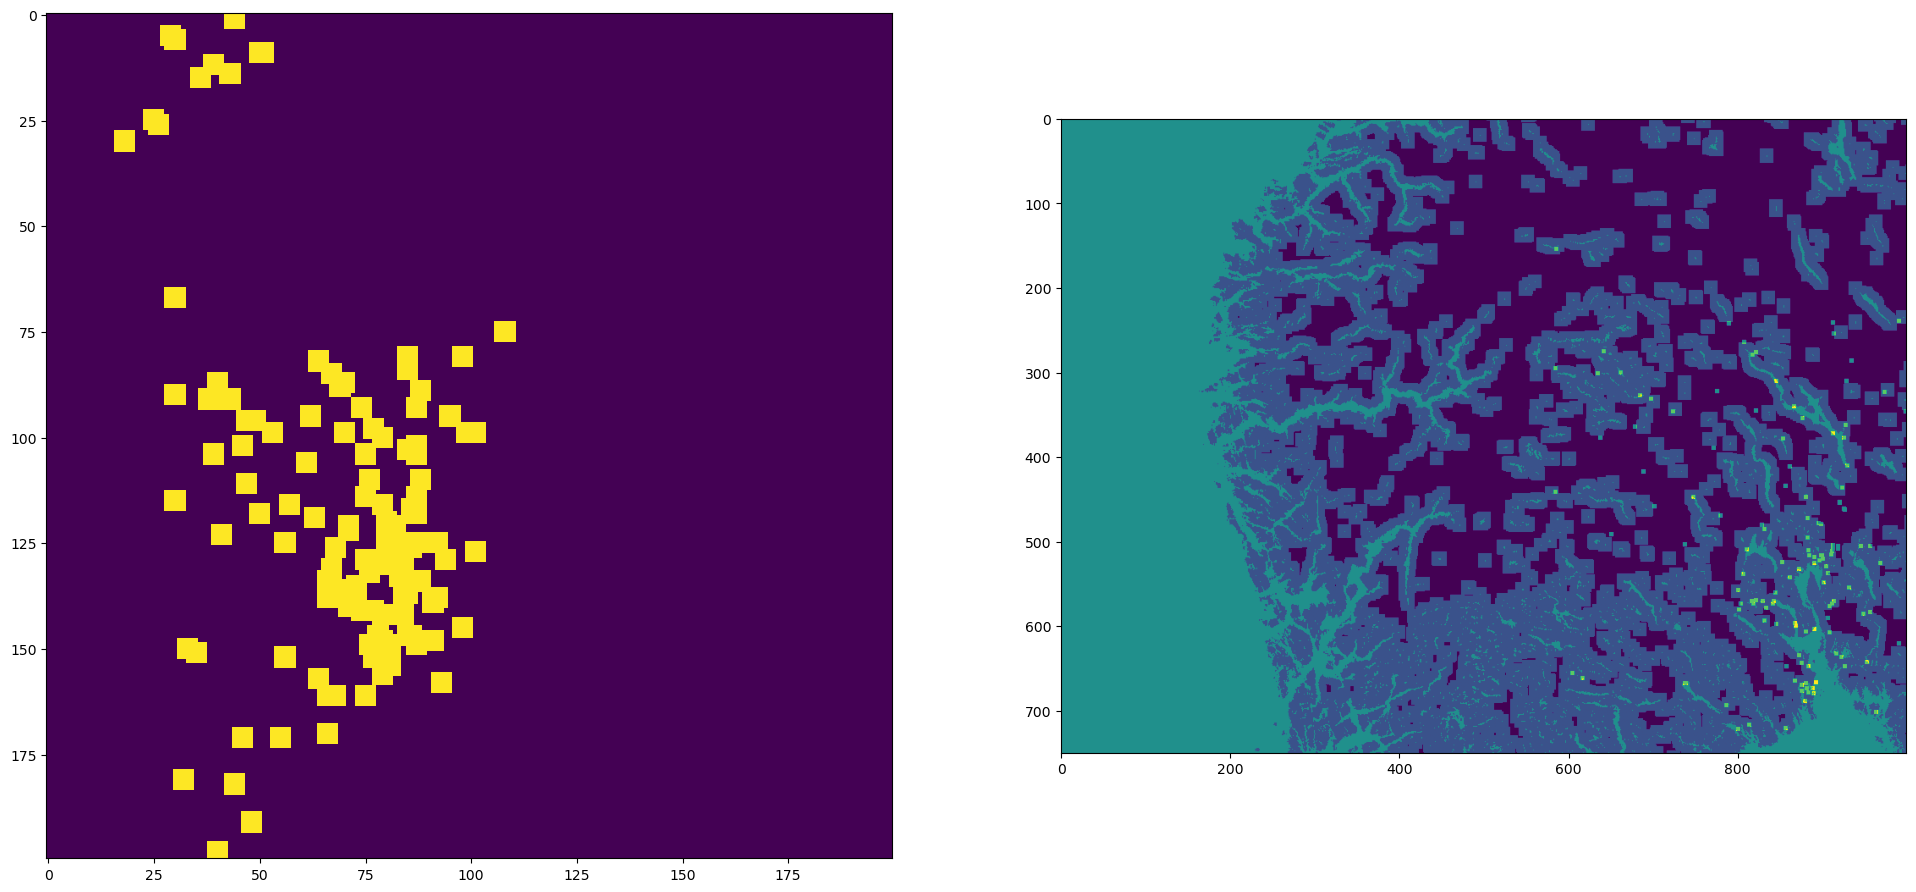

In [51]:
from scipy.ndimage import binary_dilation
# Create a structuring element (kernel) for the dilation (11x11, because we want a 10-pixel padding)
weather_station_array_low = np.zeros((array.shape[0], array.shape[1]))
weather_station_array_high = np.zeros((4728, 6984))
# Set the pixels at the specified rows and cols to 1
weather_station_array_low[colsWS, rowsWS] = 1
weather_station_array_high[colsWS3, rowsWS3] = 1
structuring_element1 = np.ones((5, 5))
structuring_element2 = np.ones((50, 50))

# Apply dilation to create a 10-pixel padding around each point where array == 1
padded_array_low = binary_dilation(weather_station_array_low, structure=structuring_element1).astype(np.int64)
padded_array_high = binary_dilation(weather_station_array_high, structure=structuring_element1).astype(np.int64)

# Plot the padded array
fig, ax = plt.subplots(1,2, figsize=(24,24))
ax[0].imshow(padded_array_low[x1:x2, y1:y2])
#ax[1].imshow(water_buffered_mask)#x1:x2, y1:y2]
#ax[2].imshow(array[x1:x2,y1:y2]+padded_array[x1:x2,y1:y2], vmin = -10, vmax = 2)#x1:x2, y1:y2]
ax[1].imshow(water_buffered_mask[3250:4000,2000:3000]+padded_array_high[3250:4000,2000:3000])#x1:x2, y1:y2]


In [52]:
on_water = results_df[results_df['water']== 1]
print(len(pd.unique(on_water['id'])))

on_water = results_df[results_df['waterlow']== 1]
len(pd.unique(on_water['id']))

12


8

In [53]:
near_water = results_df[results_df['water'] == 0.5]
print(len(pd.unique(near_water['id'])))

near_water = results_df[results_df['waterlow'] == 0.5]
len(pd.unique(near_water['id']))


127


103

In [54]:
ws_data['date'] = [i.split('T')[0] for i in ws_data['referenceTime']]
#ws_data

In [55]:
ws_data[(ws_data['id'] == 'SN37070') & (ws_data['date'] == '2019-02-10')]

,Unnamed: 0.1,index,id,referenceTime,precip,air_temp10M,snowdepth,rain_on_snow,month,Unnamed: 0,name,location,longitude,latitude,year,longitude_6931,latitude_6931,rain_on_snow2,date


In [56]:
results_df[(results_df['id'] == 'SN37070') & (results_df['date'] == '2019-02-10')]

,id,date,coordinates,row,col,raster_value,grp_value,snow,sca,water,...,elev,tree,veg,nonvegs,datetime,ros_event,ros_event75,ros_event02,ros_event_roc,ros_event_drysnowcheck
46164,SN37070,2019-02-10,"(510313.7336124899, -3389494.967085314)",446,671,0,0.008253,52.0,200,0.5,...,158,31,51,19,2019-02-10,1,1,1,0,0


In [57]:
## now get the R2 between weather stations and the GRP
ws_data_joined = ws_data.merge(results_df, on = ('id', 'date'), how='left')
ws_data_joined


,Unnamed: 0.1,index,id,referenceTime,precip,air_temp10M,snowdepth,rain_on_snow,month,Unnamed: 0,...,elev,tree,veg,nonvegs,datetime,ros_event,ros_event75,ros_event02,ros_event_roc,ros_event_drysnowcheck
0,0,0,SN17850,2017-01-01T00:00:00.000Z,0.0,-0.5,0.8,0,1,243,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
1,1,1,SN17850,2017-01-01T01:00:00.000Z,0.0,-1.1,0.8,0,1,243,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
2,2,2,SN17850,2017-01-01T02:00:00.000Z,0.0,-0.6,0.8,0,1,243,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
3,3,3,SN17850,2017-01-01T03:00:00.000Z,0.0,-0.5,0.8,0,1,243,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4,4,4,SN17850,2017-01-01T04:00:00.000Z,0.0,-1.9,0.8,0,1,243,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4281530,4281530,4281530,SN27282,2020-09-29T19:00:00.000Z,0.0,7.9,NaN,0,9,352,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4281531,4281531,4281531,SN27282,2020-09-29T20:00:00.000Z,0.0,8.4,NaN,0,9,352,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4281532,4281532,4281532,SN27282,2020-09-29T21:00:00.000Z,0.0,9.9,NaN,0,9,352,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN
4281533,4281533,4281533,SN27282,2020-09-29T22:00:00.000Z,0.0,11.5,NaN,0,9,352,...,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN


In [58]:
#stations = ['SN38140', 'SN37070','SN77230']
#ws_data_joined[(ws_data_joined['id'] == 'SN37070') & (ws_data_joined['date'] == '2019-02-05')]

In [59]:
# Group by 'date' and 'id'
grouped_df = ws_data_joined.groupby(['date', 'id']) #.mean().reset_index()
grouped_df = ws_data_joined.groupby(['date', 'id']).agg({
    'latitude':'mean',
    'longitude':'mean',
    'precip': 'sum',              # Sum precip
    'air_temp10M': 'max',
    'snowdepth': 'max',        

    'raster_value': 'mean',       # Mean of raster value
    'ros_event': 'mean',       # Mean of raster value
    'ros_event75': 'mean',       # Mean of raster value
    'ros_event02': 'mean',       # Mean of raster value
    'ros_event_roc': 'mean',       # Mean of raster value
    'ros_event_drysnowcheck': 'mean',

    'rain_on_snow': 'sum',
    'rain_on_snow2': 'sum',  
    'grp_value':'mean' ,
    'elev':'mean',
    'water':'mean',
    'waterlow':'mean',
    'tree':'mean',
    'veg':'mean',
    'nonvegs':'mean',
    'sca':'mean',
    'snow': 'mean'       
}).reset_index()
grouped_df

,date,id,latitude,longitude,precip,air_temp10M,snowdepth,raster_value,ros_event,ros_event75,...,rain_on_snow2,grp_value,elev,water,waterlow,tree,veg,nonvegs,sca,snow
0,2015-01-01,SN11500,60.70020,10.86950,0.0,4.9,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01,SN17150,59.37420,10.79800,0.8,6.9,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01,SN17850,59.66050,10.78180,0.2,6.6,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01,SN17870,59.67040,10.81040,0.4,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01,SN17980,59.84270,10.82370,0.0,NaN,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182234,2020-12-30,SN87970,68.62067,17.65133,0.0,1.2,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182235,2020-12-30,SN88010,68.67530,17.90520,0.0,-0.3,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182236,2020-12-30,SN88023,68.86910,17.47720,0.0,1.9,NaN,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
182237,2020-12-30,SN88100,68.64570,18.24420,0.0,1.8,8.9,NaN,NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
grouped_df['rain_on_snow3'] = ((grouped_df['air_temp10M'] > 3) & ## Lundquist
                       (grouped_df['precip'] > 5) & ## mooney
                       ((grouped_df['sca'] == 200.0) | (grouped_df['snow'] >= 40))).astype(int)

In [61]:
grouped_df_cleaned = grouped_df.dropna(subset=['ros_event'])  

rain_on_snow_df = grouped_df_cleaned[grouped_df_cleaned['rain_on_snow'] == 1]
rain_on_snow_count = rain_on_snow_df.groupby('id').size()
max_station = rain_on_snow_count.idxmax()
top_three_stations = rain_on_snow_count.sort_values(ascending=False).head(3)

# Print results
print("Top 3 weather stations with the most 'rain_on_snow' days equal to 1:")
print(top_three_stations)

rain_on_snow_df = grouped_df_cleaned[grouped_df_cleaned['rain_on_snow2'] == 1]
rain_on_snow_count = rain_on_snow_df.groupby('id').size()
max_station = rain_on_snow_count.idxmax()
top_three_stations = rain_on_snow_count.sort_values(ascending=False).head(3)

# Print results
print("Top 3 weather stations with the most 'rain_on_snow2' days equal to 1:")
print(top_three_stations)

rain_on_snow_df = grouped_df_cleaned[grouped_df_cleaned['rain_on_snow3'] == 1]
rain_on_snow_count = rain_on_snow_df.groupby('id').size()
max_station = rain_on_snow_count.idxmax()
top_three_stations = rain_on_snow_count.sort_values(ascending=False).head(3)

# Print results
print("Top 3 weather stations with the most 'rain_on_snow3' days equal to 1:")
print(top_three_stations)

rain_on_snow_df = grouped_df_cleaned[grouped_df_cleaned['ros_event'] == 1]
rain_on_snow_count = rain_on_snow_df.groupby('id').size()
max_station = rain_on_snow_count.idxmax()
top_three_stations = rain_on_snow_count.sort_values(ascending=False).head(3)

# Print results
print("Top 3 weather stations with the most 'raster_value' days equal to 1:")
print(top_three_stations)

Top 3 weather stations with the most 'rain_on_snow' days equal to 1:
id
SN84500    9
SN88100    8
SN74350    5
dtype: int64
Top 3 weather stations with the most 'rain_on_snow2' days equal to 1:
id
SN84500    21
SN78360    19
SN81650    17
dtype: int64
Top 3 weather stations with the most 'rain_on_snow3' days equal to 1:
id
SN38140    56
SN77230    56
SN37070    50
dtype: int64
Top 3 weather stations with the most 'raster_value' days equal to 1:
id
SN29350    511
SN18500    457
SN12700    431
dtype: int64


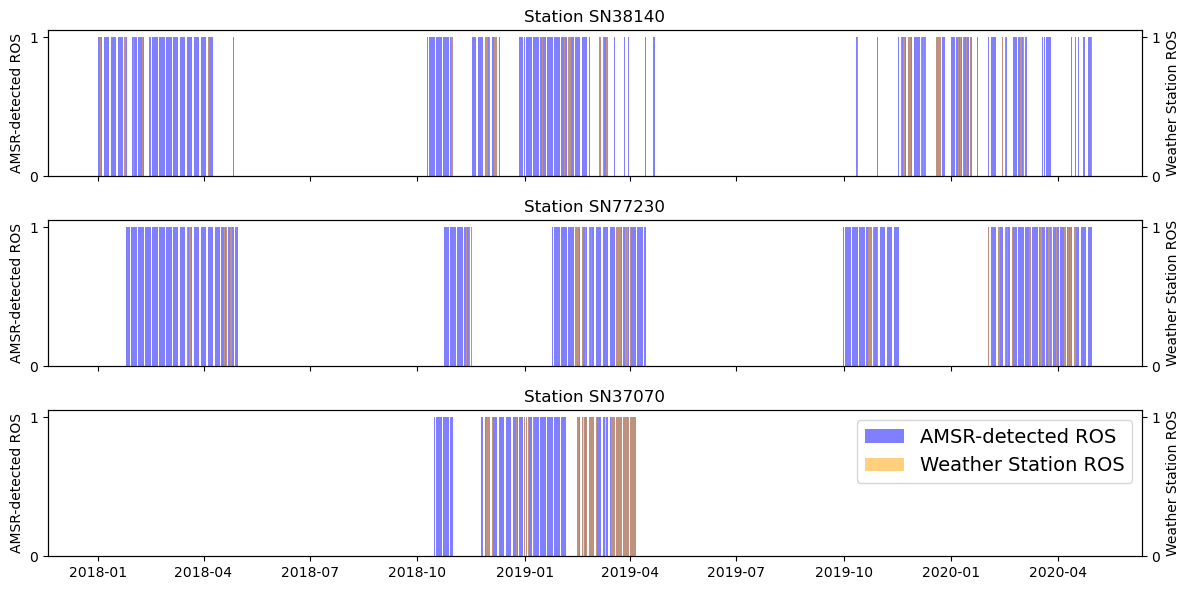

In [62]:
import matplotlib.pyplot as plt
import pandas as pd

# List of station IDs to plot
stations = ['SN38140', 'SN77230', 'SN37070']
#['SN37070', 'SN77230', 'SN27460']

# Set up the figure and axes
fig, ax = plt.subplots(len(stations), 1, figsize=(12, 6), sharex=True)

# Loop through each station and plot
for i, station in enumerate(stations):
    station_data = grouped_df_cleaned[grouped_df_cleaned['id'] == station]
    
    # Create a secondary axis for the weather station ROS
    ax1 = ax[i].twinx()
    
    # Plot weather station ROS
    ax1.bar(pd.to_datetime(station_data['date']), 
            station_data['rain_on_snow3'], 
            color='orange', alpha=0.5, label='Weather Station ROS')
    
    # Plot AMSR-detected ROS
    ax[i].bar(pd.to_datetime(station_data['date']), 
              station_data['ros_event'], 
              color='blue', alpha=0.5, label='AMSR-detected ROS')
    
    # Titles, labels, and legends
    ax[i].set_yticks([0, 1])
    ax1.set_yticks([0, 1])
    ax[i].set_title(f'Station {station}')
    ax[i].set_ylabel('AMSR-detected ROS')
    ax1.set_ylabel('Weather Station ROS')

    
    # Combine both legends and position them in the top right corner
    lines, labels = [], []
    for ax_ in [ax[i], ax1]:
        for line in ax_.get_legend_handles_labels()[0]:
            lines.append(line)
        for label in ax_.get_legend_handles_labels()[1]:
            labels.append(label)
    

ax[i].legend(lines, labels, loc='upper right', fontsize= 14)
# Label the x-axis on the bottom subplot
#ax[-1].set_xlabel('Date')

# Show the plot
plt.tight_layout()
plt.show()



/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_46249/769623643.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_cleaned['date'] = pd.to_datetime(grouped_df_cleaned['date'])


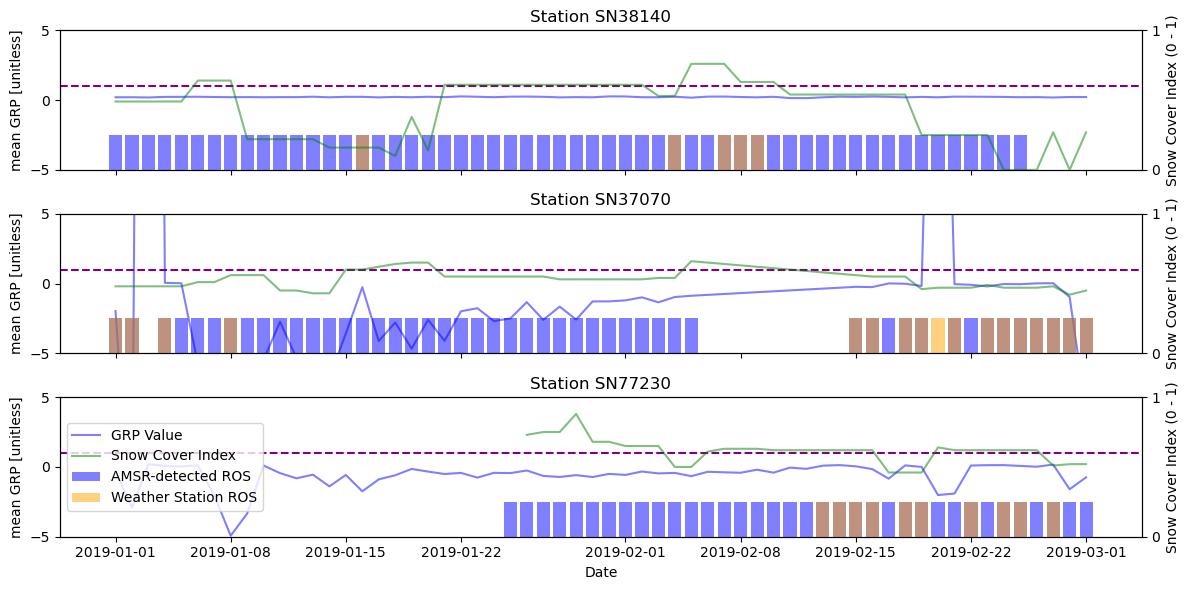

In [63]:
import matplotlib.pyplot as plt
import pandas as pd

# List of station IDs to plot
stations = ['SN38140', 'SN37070','SN77230']
#['SN37070', 'SN77230', 'SN27460']
grouped_df_cleaned['date'] = pd.to_datetime(grouped_df_cleaned['date'])
water_year = grouped_df_cleaned[(grouped_df_cleaned['date'] >= '2019-01-01') & (grouped_df_cleaned['date'] <= '2019-03-01')]

# Set up the figure and axes
fig, ax = plt.subplots(len(stations), 1, figsize=(12, 6), sharex=True)

# Loop through each station and plot
for i, station in enumerate(stations):
    station_data = water_year[water_year['id'] == station]
    
    # Create a secondary axis for the weather station ROS
    ax1 = ax[i].twinx()
    
    # Plot weather station ROS
    ax1.bar(pd.to_datetime(station_data['date']), 
            station_data['ros_event']*0.25, #ros_event_roc 
            color='blue', alpha=0.5, label='AMSR-detected ROS')
    ax1.bar(pd.to_datetime(station_data['date']), 
            station_data['rain_on_snow3']*0.25, 
            color='orange', alpha=0.5, label='Weather Station ROS')
    ax1.plot(pd.to_datetime(station_data['date']), 
            station_data['snow']/100, 
            color='green', alpha=0.5, label='Snow Cover Index')
    
    # Plot AMSR-detected ROS
    ax[i].plot(pd.to_datetime(station_data['date']), 
              station_data['grp_value'], 
              color='blue', alpha=0.5, label='GRP Value')
    
    # Titles, labels, and legends
    ax[i].set_ylim([-5, 5])
    ax[i].set_yticks([-5, 0, 5])
    #ax[i].axhline(y=1, color='purple', linestyle='--')
    ax[i].axhline(y=1, color='purple', linestyle='--')
    ax1.set_yticks([0, 1])
    ax1.set_yticks([0, 1])
    ax[i].set_title(f'Station {station}')
    ax[i].set_ylabel('mean GRP [unitless]')
    ax1.set_ylabel('Snow Cover Index (0 - 1)')
    
    # Combine both legends and position them in the top right corner
lines, labels = [], []
for ax_ in [ax[i], ax1]:
    for line in ax_.get_legend_handles_labels()[0]:
        lines.append(line)
    for label in ax_.get_legend_handles_labels()[1]:
        labels.append(label)

ax[2].legend(lines, labels, loc='center left')

# Label the x-axis on the bottom subplot
ax[-1].set_xlabel('Date')

# Show the plot
plt.tight_layout()
plt.show()



In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# List of station IDs to plot
stations = ['SN3810'] #['SN38140']
#['SN37070', 'SN77230', 'SN27460']

# Convert 'date' column to datetime if not already
grouped_df_cleaned['date'] = pd.to_datetime(grouped_df_cleaned['date'])

# Filter data by date range (water year) and station
water_year = grouped_df_cleaned[(grouped_df_cleaned['date'] >= '2019-01-01') & (grouped_df_cleaned['date'] <= '2019-03-01')]

# Ensure the correct station variable
station = stations[0]  # If using a single station from the list
station_data = water_year[water_year['id'] == station]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot AMSR-detected ROS on the primary axis
ax.plot(pd.to_datetime(station_data['date']), 
        station_data['grp_value'], 
        color='blue', alpha=0.5, label='GRP Value')

# Set primary y-axis limits and labels
ax.set_ylim([-5, 5])
ax.set_yticks([-5, 0, 5])
ax.set_ylabel('Mean GRP [unitless]')
ax.axhline(y=1, color='purple', linestyle='--')

# Create a secondary axis for the weather station ROS
ax1 = ax.twinx()

# Plot weather station ROS data
ax1.bar(pd.to_datetime(station_data['date']), 
        station_data['ros_event']*0.25, 
        color='blue', alpha=0.5, label='Satellite-detected rain')
ax1.bar(pd.to_datetime(station_data['date']), 
        station_data['rain_on_snow3']*0.25, 
        color='orange', alpha=0.5, label='Weather Station rain')

ax1.set_yticks([0, 1])

# Set the title and labels
plt.title(f'Station {station}')
ax.set_xlabel('Date')

xtick_positions = pd.to_datetime(station_data['date']).iloc[[0, len(station_data)//2, -1]]
ax.set_xticks(xtick_positions)
ax.set_xticklabels([xtick.strftime('%Y-%m-%d') for xtick in xtick_positions])


# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()  # Get labels for primary axis
lines2, labels2 = ax1.get_legend_handles_labels()  # Get labels for secondary axis
ax1.legend(lines + lines2, labels + labels2, loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_57867/2362223346.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


NameError: name 'grouped_df_cleaned' is not defined

/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_46249/961223665.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped_df_cleaned['date'] = pd.to_datetime(grouped_df_cleaned['date'])


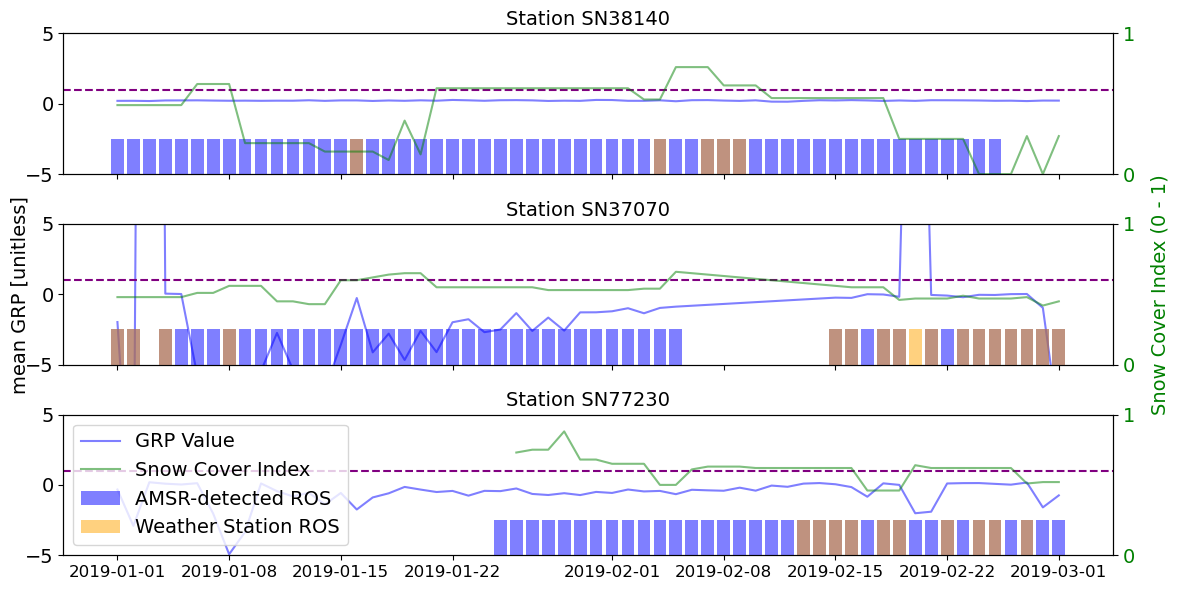

In [64]:
import matplotlib.pyplot as plt
import pandas as pd

# List of station IDs to plot
stations = ['SN38140', 'SN37070','SN77230']
grouped_df_cleaned['date'] = pd.to_datetime(grouped_df_cleaned['date'])
water_year = grouped_df_cleaned[(grouped_df_cleaned['date'] >= '2019-01-01') & (grouped_df_cleaned['date'] <= '2019-03-01')]

# Set up the figure and axes
fig, ax = plt.subplots(len(stations), 1, figsize=(12, 6), sharex=True)

# Loop through each station and plot
for i, station in enumerate(stations):
    station_data = water_year[water_year['id'] == station]
    
    # Create a secondary axis for the weather station ROS
    ax1 = ax[i].twinx()
    
    # Plot weather station ROS
    ax1.bar(pd.to_datetime(station_data['date']), 
            station_data['ros_event']*0.25, #ros_event_roc 
            color='blue', alpha=0.5, label='AMSR-detected ROS')
    ax1.bar(pd.to_datetime(station_data['date']), 
            station_data['rain_on_snow3']*0.25, 
            color='orange', alpha=0.5, label='Weather Station ROS')
    ax1.plot(pd.to_datetime(station_data['date']), 
            station_data['snow']/100, 
            color='green', alpha=0.5, label='Snow Cover Index')
    
    # Plot AMSR-detected ROS
    ax[i].plot(pd.to_datetime(station_data['date']), 
              station_data['grp_value'], 
              color='blue', alpha=0.5, label='GRP Value')
    
    # Titles, labels, and legends
    ax[i].set_ylim([-5, 5])
    ax[i].set_yticks([-5, 0, 5])
    ax[i].axhline(y=1, color='purple', linestyle='--')
    ax1.set_yticks([0, 1])
    ax[i].set_title(f'Station {station}', fontsize=14)
    ax1.tick_params(axis='y', labelcolor='green', labelsize=14)
    ax[i].tick_params(axis='y', labelsize=14)

lines, labels = [], []
for ax_ in [ax[i], ax1]:
    for line in ax_.get_legend_handles_labels()[0]:
        lines.append(line)
    for label in ax_.get_legend_handles_labels()[1]:
        labels.append(label)

# Position the legend outside the subplots
ax[-1].legend(lines, labels, loc='center left', fontsize =14)

# Label the x-axis on the bottom subplot, and set font size of dates
#ax[-1].set_xlabel('Date', fontsize=14)
ax[-1].tick_params(axis='x', labelsize=12)

# Add a big y-label on the left side for the GRP values
fig.text(0.05, 0.5, 'mean GRP [unitless]', va='center', rotation='vertical', fontsize=14)
fig.text(1.0, 0.5, 'Snow Cover Index (0 - 1)', va='center', rotation='vertical', fontsize=14, color='green')

# Show the plot
plt.tight_layout(rect=[0.05, 0, 1, 1])  # Adjust layout to accommodate the big ylabel
plt.show()


In [65]:
### add in cameras 



In [66]:
# ws_data_joined_cleaned = ws_data_joined.dropna(subset=['raster_value'])  
# ws_data_joined_cleaned = ws_data_joined_cleaned[ws_data_joined_cleaned['grp_value'] > -9990] 

# fig, ax = plt.subplots(3,1, figsize=(12,6))
# ax1 = ax[0].twinx()
# ax1.plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN88100']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN88100']['rain_on_snow'], c = 'orange', label = 'weather_station')
# ax[0].plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN88100']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN88100']['grp_value'], label = 'GRP')
# ax[0].legend()
# ax[0].set_ylim(-3,3)
# ax1.set_ylabel('weather_station ROS')

# ax2 = ax[1].twinx()
# ax2.plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['rain_on_snow'], c = 'orange', label = 'weather_station')
# ax[1].plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['grp_value'], label = 'GRP')
# ax[1].legend()
# ax[1].set_ylim(-3,3)
# ax2.set_ylabel('weather_station ROS')

# ax3 = ax[2].twinx()
# ax3.plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['rain_on_snow'], c = 'orange', label = 'weather_station')
# ax[2].plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['grp_value'], label = 'GRP')
# ax[2].legend()
# ax[2].set_ylim(-3,3)
# ax3.set_ylabel('weather_station ROS')

In [67]:
print(np.min(grouped_df_cleaned[grouped_df_cleaned['rain_on_snow3']==1]['grp_value']))
print(np.max(grouped_df_cleaned[grouped_df_cleaned['rain_on_snow3']==1]['grp_value']))
print(np.mean(grouped_df_cleaned[grouped_df_cleaned['rain_on_snow3']==1]['grp_value']))
print(np.std(grouped_df_cleaned[grouped_df_cleaned['rain_on_snow3']==1]['grp_value']))


-141.44055246155781
42.68909881117103
0.02947444081395046
2.9803399475792216


Optimal Threshold for grp_value: -0.018539658615900977
ROC AUC Score: 0.6816427905772654


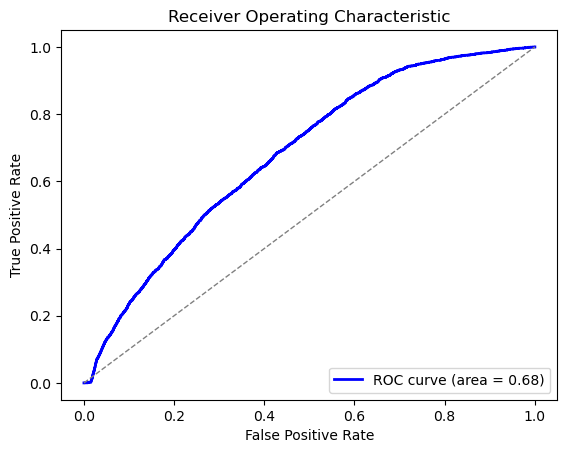

In [68]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Assuming your dataframe is named ws_data
# Filter out rows with NaN in rain_Lund or grp_value
ws_data_joined_studyperiod_grouped_test = grouped_df_cleaned.dropna(subset=['rain_on_snow3', 'grp_value'])
#ws_data_joined_studyperiod_grouped_test = ws_data_joined_studyperiod_grouped_test[ws_data_joined_studyperiod_grouped_test['elev']< 900]


# Define binary values for rain_Lund (True/False) and group values based on rain
rain_lund_binary = (ws_data_joined_studyperiod_grouped_test['rain_on_snow3'] > 0).astype(int)

# Calculate precision, recall, and thresholds for precision-recall curve
precision, recall, thresholds_pr = precision_recall_curve(rain_lund_binary, ws_data_joined_studyperiod_grouped_test['grp_value'])

# Calculate ROC curve values
fpr, tpr, thresholds_roc = roc_curve(rain_lund_binary, ws_data_joined_studyperiod_grouped_test['grp_value'])

# AUC score for ROC
roc_auc = auc(fpr, tpr)

# Find the threshold where precision and recall balance or optimize for desired trade-off
optimal_idx = np.argmax(tpr - fpr)  # Example: You can tune this to other criteria
optimal_threshold = thresholds_roc[optimal_idx]

# Print results
print(f'Optimal Threshold for grp_value: {optimal_threshold}')
print(f'ROC AUC Score: {roc_auc}')

# Plotting the ROC curve (optional)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [69]:
grouped_df_cleaned.columns

Index(['date', 'id', 'latitude', 'longitude', 'precip', 'air_temp10M',
       'snowdepth', 'raster_value', 'ros_event', 'ros_event75', 'ros_event02',
       'ros_event_roc', 'ros_event_drysnowcheck', 'rain_on_snow',
       'rain_on_snow2', 'grp_value', 'elev', 'water', 'waterlow', 'tree',
       'veg', 'nonvegs', 'sca', 'snow', 'rain_on_snow3'],
      dtype='object')

In [70]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

 
#val['rain_on_snow2_b'] = [1 if i >=1 else 0 for i in val['rain_Lund']]
actual = grouped_df_cleaned['rain_on_snow3']  # Replace with your actual binary labels (0 or 1)
predicted = grouped_df_cleaned['ros_event_drysnowcheck' ]  # Replace with your model's binary predictions (0 or 1)  #ros_event_drysnowcheck

# Calculate various metrics
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted)
recall = recall_score(actual, predicted)
f1 = f1_score(actual, predicted)
roc_auc = roc_auc_score(actual, predicted)
mcc = matthews_corrcoef(actual, predicted)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

Accuracy: 0.9555
Precision: 0.0350
Recall: 0.0066
F1 Score: 0.0111
ROC AUC: 0.4997
Matthews Correlation Coefficient (MCC): -0.0013


Confusion Matrix:
[[64883   469]
 [ 2553    17]]


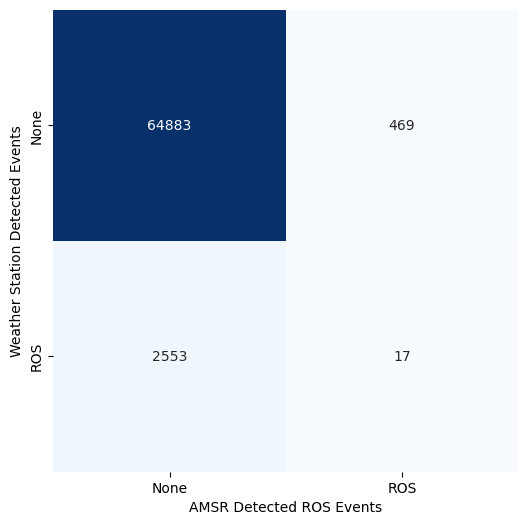

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(actual, predicted)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['None', 'ROS'], yticklabels=['None', 'ROS'])
plt.xlabel('AMSR Detected ROS Events')
plt.ylabel('Weather Station Detected Events')
plt.show()

In [72]:
grouped_df_cleaned

,date,id,latitude,longitude,precip,air_temp10M,snowdepth,raster_value,ros_event,ros_event75,...,grp_value,elev,water,waterlow,tree,veg,nonvegs,sca,snow,rain_on_snow3
41398,2018-01-01,SN11500,60.70020,10.86950,1.0,0.6,NaN,1.0,1.0,1.0,...,-0.425444,264.0,0.5,1.0,8.0,75.0,18.0,200.0,75.0,0
41399,2018-01-01,SN12550,60.77330,10.80550,1.7,0.8,NaN,1.0,1.0,1.0,...,-0.291827,123.0,1.0,0.5,24.0,71.0,6.0,84.0,68.0,0
41400,2018-01-01,SN12700,61.10400,10.51120,0.0,NaN,NaN,1.0,1.0,1.0,...,-0.793228,530.0,0.5,0.5,46.0,48.0,7.0,200.0,54.0,0
41401,2018-01-01,SN17150,59.37420,10.79800,2.8,5.3,NaN,1.0,1.0,1.0,...,0.172936,50.0,0.5,0.5,16.0,61.0,23.0,200.0,18.0,0
41402,2018-01-01,SN17850,59.66050,10.78180,2.3,4.2,-0.4,1.0,1.0,1.0,...,0.174344,95.0,0.5,0.0,20.0,57.0,23.0,200.0,48.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144287,2020-04-30,SN87970,68.62067,17.65133,0.0,1.7,NaN,0.0,1.0,1.0,...,-0.711501,407.0,0.0,0.5,0.0,86.0,14.0,150.0,83.0,0
144288,2020-04-30,SN88010,68.67530,17.90520,0.0,2.5,NaN,0.0,1.0,1.0,...,-0.993185,359.0,0.5,0.0,2.0,88.0,10.0,200.0,79.0,0
144289,2020-04-30,SN88023,68.86910,17.47720,0.0,5.7,NaN,0.0,0.0,0.0,...,0.007232,23.0,1.0,1.0,0.0,0.0,0.0,122.0,NaN,0
144290,2020-04-30,SN88100,68.64570,18.24420,0.0,4.4,131.4,0.0,1.0,1.0,...,-0.696696,283.0,0.0,0.0,4.0,87.0,9.0,50.0,80.0,0


In [73]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
# Drop rows with NaN values to avoid errors in model fitting
data_cleaned = grouped_df_cleaned.dropna(subset=['ros_event', 'rain_on_snow3',  'air_temp10M', 'precip', 'elev', 'tree', 'water'])

#  looking at why false positives ## 
data_cleaned = data_cleaned[data_cleaned['ros_event'] == 1]
#data_cleaned = data_cleaned[data_cleaned['water'] != 1]
data_cleaned['agree'] = [1 if i == j else 0 for i,j in zip(data_cleaned['ros_event'], data_cleaned['rain_on_snow3'])]

# Define the variables of interest
variables_of_interest = ['precip', 'air_temp10M', 'tree', 'snow', 'water', 'agree','elev']
correlation_data = data_cleaned[variables_of_interest]
correlation_matrix = correlation_data.corr()
#print(correlation_matrix)

# Normalize the variables using Z-score standardization
scaler = StandardScaler()
data_cleaned[['air_temp10M','precip','tree','water','elev',
              'waterlow',]] = scaler.fit_transform(data_cleaned[['air_temp10M','precip','tree', 'water', 'elev', 'waterlow']])

# Define the independent variables (X) and dependent variable (y)
X = data_cleaned[['precip', 'air_temp10M', 'tree','elev', 'water']]
y = data_cleaned['agree']

# Add a constant (intercept) to the model
X = sm.add_constant(X)

# Fit the logistic regression model
model = sm.Logit(y, X).fit()
#model = sm.MixedLM(y, X, groups=data_cleaned['water']).fit()

# Print the model summary
print(model.summary())



Optimization terminated successfully.
         Current function value: 0.224559
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  agree   No. Observations:                37127
Model:                          Logit   Df Residuals:                    37121
Method:                           MLE   Df Model:                            5
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                  0.1066
Time:                        17:10:15   Log-Likelihood:                -8337.2
converged:                       True   LL-Null:                       -9331.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -2.9414      0.026   -111.198      0.000      -2.993      -2.890
precip          0.2463    

In [74]:
print(grouped_df_cleaned.head())
metadata = pd.read_csv('/Users/catherinebreen/code/Chapter4/6_automated_labels/camera_weatherstation_0-30_metadata.csv')
print(metadata.head())

            date       id  latitude  longitude  precip  air_temp10M  \
41398 2018-01-01  SN11500   60.7002    10.8695     1.0          0.6   
41399 2018-01-01  SN12550   60.7733    10.8055     1.7          0.8   
41400 2018-01-01  SN12700   61.1040    10.5112     0.0          NaN   
41401 2018-01-01  SN17150   59.3742    10.7980     2.8          5.3   
41402 2018-01-01  SN17850   59.6605    10.7818     2.3          4.2   

       snowdepth  raster_value  ros_event  ros_event75  ...  grp_value   elev  \
41398        NaN           1.0        1.0          1.0  ...  -0.425444  264.0   
41399        NaN           1.0        1.0          1.0  ...  -0.291827  123.0   
41400        NaN           1.0        1.0          1.0  ...  -0.793228  530.0   
41401        NaN           1.0        1.0          1.0  ...   0.172936   50.0   
41402       -0.4           1.0        1.0          1.0  ...   0.174344   95.0   

       water  waterlow  tree   veg  nonvegs    sca  snow  rain_on_snow3  
41398    0.5

In [75]:
metadata

,Unnamed: 0.1,Unnamed: 0,CameraID,WeatherStation1,Distance1,WeatherStation2,Distance2,WeatherStation3,Distance3,WeatherStation4,...,Eieradresse,Eiertelefon,Eierepost,UTM,LatitudeWeb,LongitudeWeb,HarMedia,AktivtKamera,LocIdMaster,coordinateUncertainty
0,0,0,1,SN18265,12277.012815,NaN,NaN,NaN,NaN,NaN,...,NaN,47686605,NaN,32,59.904500,11.000847,True,False,NaN,NaN
1,0,0,1,SN18210,20516.073100,NaN,NaN,NaN,NaN,NaN,...,NaN,47686605,NaN,32,59.904500,11.000847,True,False,NaN,NaN
2,1,1,2,SN18265,15631.681454,SN18240,15839.411919,SN18269,17295.32367,SN4260,...,NaN,NaN,Erling.Bergsaker@norskog.no,32,59.884883,10.998120,True,True,NaN,NaN
3,1,1,2,SN18020,20590.089301,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Erling.Bergsaker@norskog.no,32,59.884883,10.998120,True,True,NaN,NaN
4,2,2,3,SN4827,20875.062379,NaN,NaN,NaN,NaN,NaN,...,Ã˜vre RÃ_lingsveg 29 2005 RÃ_lingen,47287232,jahrhoo@online.no,32,59.878139,11.100237,True,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2836,1165,1165,3072,SN240800,20524.820781,SN1600,23875.267190,NaN,NaN,NaN,...,NaN,NaN,NaN,99,59.238729,11.909552,False,True,NaN,NaN
2837,1166,1166,3076,SN240800,24732.893658,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,99,59.325258,11.954146,False,True,NaN,NaN
2838,1167,1167,3088,SN1960,28034.370428,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,99,59.581322,11.812034,False,True,NaN,NaN
2839,1168,1168,3089,SN1960,28427.691826,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,99,59.590617,11.830281,False,True,NaN,NaN


In [76]:
test_labels = pd.read_csv('/Users/catherinebreen/Dropbox/Chapter4/WEATHER_MODEL/classifier_results/cameras_75_75_100_weighted_aug/test_samples.csv')
ml_labels = pd.read_csv('/Users/catherinebreen/Dropbox/Chapter4/WEATHER_MODEL/classifier_results/cameras_75_75_100_weighted_aug/figs_test/resultsTESTNone.csv')

#print(test_labels.head())
#print(ml_labels.head())

ml_labels2 = pd.merge(ml_labels, test_labels, left_on='filenames', right_on='filename', how='inner')
#ml_labels2

In [77]:
grouped_df

,date,id,latitude,longitude,precip,air_temp10M,snowdepth,raster_value,ros_event,ros_event75,...,grp_value,elev,water,waterlow,tree,veg,nonvegs,sca,snow,rain_on_snow3
0,2015-01-01,SN11500,60.70020,10.86950,0.0,4.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2015-01-01,SN17150,59.37420,10.79800,0.8,6.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2015-01-01,SN17850,59.66050,10.78180,0.2,6.6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,2015-01-01,SN17870,59.67040,10.81040,0.4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2015-01-01,SN17980,59.84270,10.82370,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182234,2020-12-30,SN87970,68.62067,17.65133,0.0,1.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
182235,2020-12-30,SN88010,68.67530,17.90520,0.0,-0.3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
182236,2020-12-30,SN88023,68.86910,17.47720,0.0,1.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
182237,2020-12-30,SN88100,68.64570,18.24420,0.0,1.8,8.9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [78]:
grouped_df_cleaned

,date,id,latitude,longitude,precip,air_temp10M,snowdepth,raster_value,ros_event,ros_event75,...,grp_value,elev,water,waterlow,tree,veg,nonvegs,sca,snow,rain_on_snow3
41398,2018-01-01,SN11500,60.70020,10.86950,1.0,0.6,NaN,1.0,1.0,1.0,...,-0.425444,264.0,0.5,1.0,8.0,75.0,18.0,200.0,75.0,0
41399,2018-01-01,SN12550,60.77330,10.80550,1.7,0.8,NaN,1.0,1.0,1.0,...,-0.291827,123.0,1.0,0.5,24.0,71.0,6.0,84.0,68.0,0
41400,2018-01-01,SN12700,61.10400,10.51120,0.0,NaN,NaN,1.0,1.0,1.0,...,-0.793228,530.0,0.5,0.5,46.0,48.0,7.0,200.0,54.0,0
41401,2018-01-01,SN17150,59.37420,10.79800,2.8,5.3,NaN,1.0,1.0,1.0,...,0.172936,50.0,0.5,0.5,16.0,61.0,23.0,200.0,18.0,0
41402,2018-01-01,SN17850,59.66050,10.78180,2.3,4.2,-0.4,1.0,1.0,1.0,...,0.174344,95.0,0.5,0.0,20.0,57.0,23.0,200.0,48.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144287,2020-04-30,SN87970,68.62067,17.65133,0.0,1.7,NaN,0.0,1.0,1.0,...,-0.711501,407.0,0.0,0.5,0.0,86.0,14.0,150.0,83.0,0
144288,2020-04-30,SN88010,68.67530,17.90520,0.0,2.5,NaN,0.0,1.0,1.0,...,-0.993185,359.0,0.5,0.0,2.0,88.0,10.0,200.0,79.0,0
144289,2020-04-30,SN88023,68.86910,17.47720,0.0,5.7,NaN,0.0,0.0,0.0,...,0.007232,23.0,1.0,1.0,0.0,0.0,0.0,122.0,NaN,0
144290,2020-04-30,SN88100,68.64570,18.24420,0.0,4.4,131.4,0.0,1.0,1.0,...,-0.696696,283.0,0.0,0.0,4.0,87.0,9.0,50.0,80.0,0


In [79]:
# Function to append or create a new entry

### looks at all weather stations and adds a comment with image information from cameras <30 km away

df = grouped_df

def append_or_create(existing_value, new_value):
    if existing_value == 'None':  # If the existing value is NaN or None, initialize with new value
        return str(new_value) #list(new_value) #
    else:
        return str(existing_value) + ", " + str(new_value)  # Append the new value to the existing one
    # existing_value.append(new_value)   #


# Initialize columns with None (or NaN if you prefer)
df['img_ros_labels'] = ['None'] * len(df)
df['confidences'] = ['None'] * len(df)
df['cam_ids'] = ['None'] * len(df)
df['dist_ws'] = ['None'] * len(df)
df['filenames'] = ['None'] * len(df)

# Iterate through each row in ml_labels2 DataFrame
for idx, row in ml_labels2.iterrows():
    ## Get image information ##
    filename = row['filenames']
    camID = row['cameraID']
    datetime_str = row['datetime']
    date = datetime_str.split(' ')[0].replace(':', '-')
    predLabel = row['predictedLabels']
    conf = row['confidences']
    
    ## Look up all weather stations with that cameraID ##
    metadataRow = metadata[metadata['CameraID'] == camID]

    ## Combine duplicate rows if applicable
    station_columns = ['WeatherStation1', 'WeatherStation2', 'WeatherStation3', 'WeatherStation4', 'WeatherStation5']
    stations = metadataRow[station_columns].values.ravel().tolist()
    stations = [station for station in stations if pd.notna(station)]
    station_list = list(stations)

    dist_columns = ['Distance1', 'Distance2', 'Distance3', 'Distance4', 'Distance5']
    distances = metadataRow[dist_columns].values.ravel().tolist()
    distances = [distance for distance in distances if pd.notna(distance)]
    distance_list = list(distances)

    ## Find all weather stations in grouped_df_cleaned matching station_list and date ##
    subset = df[(df['id'].isin(station_list)) & (df['date'] == date)]
    #if len(subset['id']) > 1: break
    indices = subset.index.tolist()

    ## Update matching rows in grouped_df_cleaned ##
    for i, station in enumerate(station_list):
        if station in subset['id'].values:
            dist = distance_list[i]  # Get the corresponding distance
            matched_idx = subset[subset['id'] == station].index[0]

            # Append or update values at the matched index
            df.loc[matched_idx, 'img_ros_labels'] = append_or_create(df.loc[matched_idx, 'img_ros_labels'], predLabel)
            df.loc[matched_idx, 'confidences'] = append_or_create(df.loc[matched_idx, 'confidences'], conf)
            df.loc[matched_idx, 'cam_ids'] = append_or_create(df.loc[matched_idx, 'cam_ids'], camID)
            df.loc[matched_idx, 'dist_ws'] = append_or_create(df.loc[matched_idx, 'dist_ws'], dist)
            df.loc[matched_idx, 'filenames'] = append_or_create(df.loc[matched_idx, 'filenames'], filename)


In [80]:
df.loc[matched_idx, 'img_ros_labels']

'0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0'

In [81]:
df.loc[76513]

date                                                             2019-01-22
id                                                                  SN17550
latitude                                                           59.51767
longitude                                                          10.72517
precip                                                                  0.0
air_temp10M                                                            -2.9
snowdepth                                                               NaN
raster_value                                                            0.0
ros_event                                                               1.0
ros_event75                                                             1.0
ros_event02                                                             1.0
ros_event_roc                                                           1.0
ros_event_drysnowcheck                                                  0.0
rain_on_snow

In [82]:
### here is the subset of days and stations with supplementation from camera images 
supplemented = df[df['img_ros_labels'] != 'None']
supplemented

,date,id,latitude,longitude,precip,air_temp10M,snowdepth,raster_value,ros_event,ros_event75,...,veg,nonvegs,sca,snow,rain_on_snow3,img_ros_labels,confidences,cam_ids,dist_ws,filenames
31088,2017-08-04,SN18950,59.984799,10.669232,22.0,16.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,"0, 0, 0","0.045521814, 0.006153111, 0.0066502793","507, 507, 507","24067.13009300311, 24067.13009300311, 24067.13...","507_20180115 (460).JPG, 507_20180115 (459).JPG..."
31134,2017-08-04,SN4460,60.117300,10.829000,8.0,20.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,"0, 0, 0","0.045521814, 0.006153111, 0.0066502793","507, 507, 507","10954.037363895915, 10954.037363895915, 10954....","507_20180115 (460).JPG, 507_20180115 (459).JPG..."
32344,2017-08-21,SN18920,59.957300,10.671000,1.2,18.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,"0, 0, 0, 0, 0, 0","0.0857661, 0.03915771, 0.10213324, 0.0631895, ...","507, 507, 507, 507, 507, 507","29683.29919861181, 29683.29919861181, 29683.29...","507_20180115 (677).JPG, 507_20180115 (678).JPG..."
32345,2017-08-21,SN18950,59.984799,10.669232,5.7,16.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,"0, 0, 0, 0, 0, 0","0.0857661, 0.03915771, 0.10213324, 0.0631895, ...","507, 507, 507, 507, 507, 507","24067.13009300311, 24067.13009300311, 24067.13...","507_20180115 (677).JPG, 507_20180115 (678).JPG..."
32390,2017-08-21,SN4460,60.117300,10.829000,0.6,20.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,"0, 0, 0, 0, 0, 0","0.0857661, 0.03915771, 0.10213324, 0.0631895, ...","507, 507, 507, 507, 507, 507","10954.037363895915, 10954.037363895915, 10954....","507_20180115 (677).JPG, 507_20180115 (678).JPG..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131602,2020-02-02,SN19710,59.855800,10.435800,0.0,5.0,6.3,0.0,1.0,1.0,...,53.0,16.0,200.0,48.0,0,"1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0...","0.45030996, 0.27053043, 0.017138418, 0.0325156...","842, 842, 842, 842, 842, 842, 842, 842, 842, 8...","21877.91481067284, 21877.91481067284, 21877.91...","842_20200212 (5255).JPG, 842_20200212 (5256).J..."
131742,2020-02-03,SN19430,59.892330,10.540330,0.0,1.3,NaN,0.0,0.0,0.0,...,45.0,32.0,100.0,NaN,0,0,0.09732356,447,18691.04501589956,447_20200215 (31).JPG
131743,2020-02-03,SN19660,59.947500,10.385500,1218.7,-1.6,NaN,0.0,1.0,1.0,...,21.0,15.0,200.0,35.0,0,"1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1...","0.65924364, 0.5933172, 0.8844523, 0.32894424, ...","842, 842, 842, 842, 842, 842, 842, 842, 842, 8...","15419.951477557646, 15419.951477557646, 15419....","842_20200212 (5259).JPG, 842_20200212 (5260).J..."
131744,2020-02-03,SN19710,59.855800,10.435800,5.0,1.0,9.3,0.0,1.0,1.0,...,53.0,16.0,200.0,48.0,0,"1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1...","0.65924364, 0.5933172, 0.8844523, 0.32894424, ...","842, 842, 842, 842, 842, 842, 842, 842, 842, 8...","21877.91481067284, 21877.91481067284, 21877.91...","842_20200212 (5259).JPG, 842_20200212 (5260).J..."


In [83]:
grouped_df[grouped_df['id'].isin(stations)]

,date,id,latitude,longitude,precip,air_temp10M,snowdepth,raster_value,ros_event,ros_event75,...,veg,nonvegs,sca,snow,rain_on_snow3,img_ros_labels,confidences,cam_ids,dist_ws,filenames
65081,2018-10-29,SN66120,63.30933,9.5685,0.0,-2.5,NaN,0.0,1.0,1.0,...,80.0,11.0,200.0,77.0,0,None,None,None,None,None
65232,2018-10-30,SN66120,63.30933,9.5685,0.0,2.4,NaN,0.0,1.0,1.0,...,80.0,11.0,200.0,68.0,0,None,None,None,None,None
65381,2018-10-31,SN66120,63.30933,9.5685,2.6,5.0,NaN,0.0,1.0,1.0,...,80.0,11.0,200.0,68.0,0,None,None,None,None,None
65530,2018-11-01,SN66120,63.30933,9.5685,0.0,6.2,NaN,0.0,1.0,1.0,...,80.0,11.0,200.0,68.0,0,None,None,None,None,None
65678,2018-11-02,SN66120,63.30933,9.5685,14.6,6.3,NaN,0.0,1.0,1.0,...,80.0,11.0,200.0,68.0,1,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181883,2020-12-28,SN66120,63.30933,9.5685,0.0,2.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,None,None,None,None,None
182038,2020-12-29,SN65275,63.22800,9.3853,0.0,2.2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,None,None,None,None,None
182042,2020-12-29,SN66120,63.30933,9.5685,0.0,2.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,None,None,None,None,None
182199,2020-12-30,SN65275,63.22800,9.3853,0.0,0.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,None,None,None,None,None


In [129]:
import pandas as pd
from itertools import chain

stations = pd.unique(supplemented['id'])
print(stations)
print(len(stations))
test = set(np.hstack(np.hstack(supplemented['cam_ids'].values)))
# Iterate through each entry in the data
unique_numbers = set()

# Iterate through each entry in the data
for entry in test:
    # Split the string by commas, remove leading/trailing spaces, and add to the set
    unique_numbers.update(entry.replace(" ", "").split(','))

print(len(unique_numbers))

['SN18950' 'SN4460' 'SN18920' 'SN3810' 'SN78360' 'SN19710' 'SN26590'
 'SN17850' 'SN17870' 'SN19825' 'SN65451' 'SN3720' 'SN11500' 'SN17150'
 'SN17050' 'SN20540' 'SN3370' 'SN3290' 'SN4260' 'SN18420' 'SN18500'
 'SN20280' 'SN26060' 'SN26500' 'SN26820' 'SN17980' 'SN18020' 'SN19940'
 'SN64760' 'SN17380' 'SN90' 'SN6580' 'SN6690' 'SN6700' 'SN37070' 'SN66120'
 'SN66175' 'SN38730' 'SN17550' 'SN17640' 'SN18410' 'SN19660' 'SN17650'
 'SN18240' 'SN18690' 'SN18700' 'SN18701' 'SN38140' 'SN17875' 'SN18265'
 'SN4827' 'SN18210' 'SN18315' 'SN84920' 'SN87970' 'SN17895' 'SN18269'
 'SN19830' 'SN19430' 'SN18280' 'SN4455' 'SN1070' 'SN39750' 'SN35210'
 'SN65275']
65
96


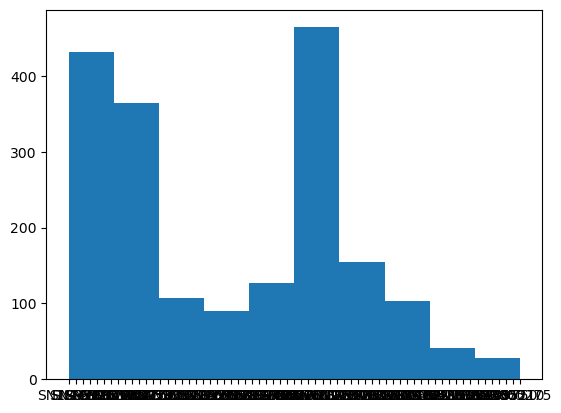

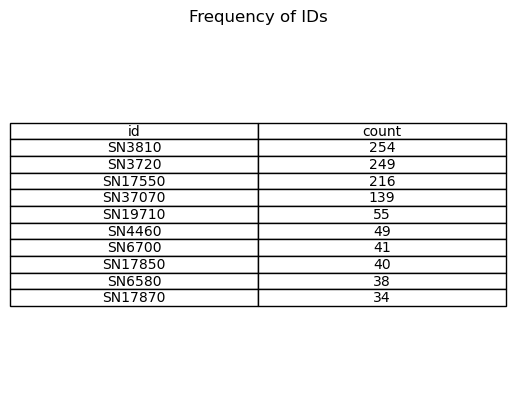

In [130]:
plt.hist(supplemented['id'])

# Step 2: Create a table
frequency = supplemented['id'].value_counts().reset_index().head(10)
frequency.columns = ['id', 'count']
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=frequency.values, colLabels=frequency.columns, cellLoc = 'center', loc='center')

plt.title('Frequency of IDs')
plt.show()

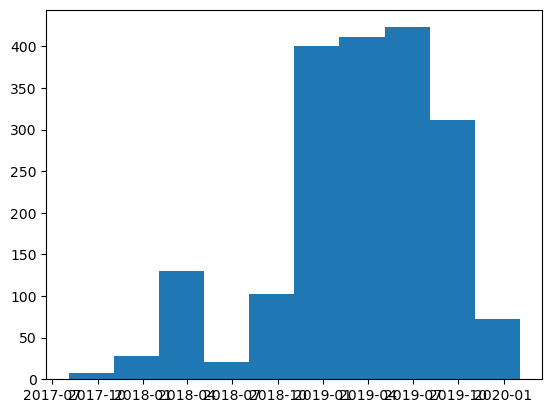

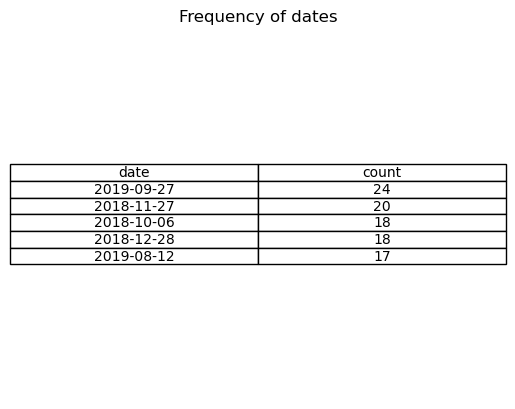

In [131]:
plt.hist(pd.to_datetime(supplemented['date']))

frequency = supplemented['date'].value_counts().reset_index().head(5)
frequency.columns = ['date', 'count']
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=frequency.values, colLabels=frequency.columns, cellLoc = 'center', loc='center')

plt.title('Frequency of dates')
plt.show()

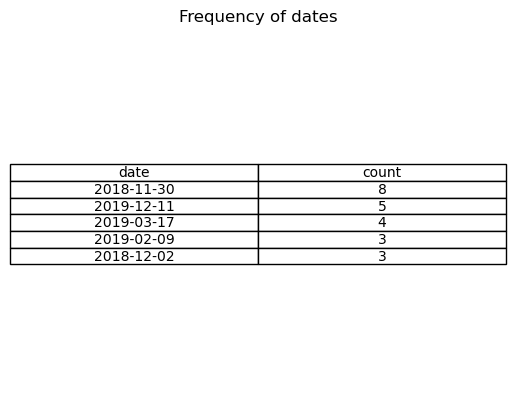

In [132]:
## when 
test = supplemented[supplemented['rain_on_snow3'] == 1]
frequency = test['date'].value_counts().reset_index().head(5)
frequency.columns = ['date', 'count']
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=frequency.values, colLabels=frequency.columns, cellLoc = 'center', loc='center')

plt.title('Frequency of dates')
plt.show()

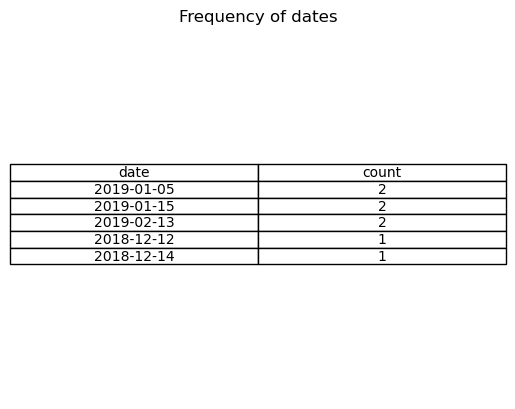

In [133]:
test = supplemented[supplemented['ros_event_drysnowcheck'] == 1]
frequency = test['date'].value_counts().reset_index().head(5)
frequency.columns = ['date', 'count']
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=frequency.values, colLabels=frequency.columns, cellLoc = 'center', loc='center')

plt.title('Frequency of dates')
plt.show()

In [134]:
unique_cam_ids_per_day = supplemented.groupby('date')['cam_ids'].nunique()

# Find the date with the maximum number of unique cam_ids
day_with_most_unique_cam_ids = unique_cam_ids_per_day.idxmax()
max_unique_cam_ids = unique_cam_ids_per_day.max()

print(f"The day with the most unique cam_ids is {day_with_most_unique_cam_ids} with {max_unique_cam_ids} unique cam_ids.")

The day with the most unique cam_ids is 2018-11-27 with 16 unique cam_ids.


In [135]:
df['cam_ids'] = supplemented['cam_ids'].apply(lambda x: x.split(', '))

# Explode the lists into separate rows
exploded_df = df.explode('cam_ids')

# Group by 'date' and count unique cam_ids
unique_cam_ids_per_day = exploded_df.groupby('date')['cam_ids'].nunique()

# Find the day with the maximum number of unique cam_ids
day_with_most_unique_cam_ids = unique_cam_ids_per_day.idxmax()
max_unique_cam_ids = unique_cam_ids_per_day.max()

print(f"The day with the most unique cam_ids is {day_with_most_unique_cam_ids} with {max_unique_cam_ids} unique cam_ids.")

The day with the most unique cam_ids is 2018-11-27 with 21 unique cam_ids.


In [136]:
supplemented.to_csv('supplementedTest.csv')

In [137]:
supp_ids_only = grouped_df[grouped_df['id'].isin(stations)]
## constrain dates 
supp_ids_only['date'] = pd.to_datetime(supp_ids_only['date'])
supp_ids_only_studyperiod = supp_ids_only[((supp_ids_only['date'] > '2018-01-01') & (supp_ids_only['date'] < '2018-05-01')) | 
                                          ((supp_ids_only['date'] > '2019-10-01') & (supp_ids_only['date'] < '2020-04-01')) | 
                                          ((supp_ids_only['date'] > '2018-10-01') & (supp_ids_only['date'] < '2019-05-01')) ]
## baseline accuracy metrics ## 
supp_ids_only_studyperiod


/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_46249/1066522619.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  supp_ids_only['date'] = pd.to_datetime(supp_ids_only['date'])


,date,id,latitude,longitude,precip,air_temp10M,snowdepth,raster_value,ros_event,ros_event75,...,veg,nonvegs,sca,snow,rain_on_snow3,img_ros_labels,confidences,cam_ids,dist_ws,filenames
41458,2018-01-02,SN11500,60.70020,10.86950,0.4,0.7,NaN,0.0,1.0,1.0,...,75.0,18.0,200.0,86.0,0,None,None,NaN,None,None
41461,2018-01-02,SN17150,59.37420,10.79800,0.0,2.7,NaN,0.0,1.0,1.0,...,61.0,23.0,200.0,30.0,0,None,None,NaN,None,None
41462,2018-01-02,SN17850,59.66050,10.78180,0.0,0.5,-0.4,0.0,1.0,1.0,...,57.0,23.0,200.0,45.0,0,None,None,NaN,None,None
41463,2018-01-02,SN17870,59.67040,10.81040,0.0,0.4,NaN,0.0,1.0,1.0,...,61.0,15.0,200.0,62.0,0,None,None,NaN,None,None
41464,2018-01-02,SN17980,59.84270,10.82370,0.0,0.9,NaN,0.0,1.0,1.0,...,41.0,24.0,200.0,34.0,0,None,None,NaN,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139938,2020-03-31,SN6690,60.85667,11.40033,0.0,10.1,NaN,0.0,0.0,0.0,...,41.0,17.0,25.0,0.0,0,None,None,NaN,None,None
139948,2020-03-31,SN78360,66.13170,13.58670,34.2,3.7,125.0,0.0,0.0,0.0,...,61.0,6.0,125.0,NaN,0,None,None,NaN,None,None
139964,2020-03-31,SN84920,68.53000,17.42550,56.1,0.8,NaN,0.0,0.0,0.0,...,66.0,9.0,163.0,NaN,0,None,None,NaN,None,None
139966,2020-03-31,SN87970,68.62067,17.65133,31.9,0.1,NaN,0.0,1.0,1.0,...,86.0,14.0,150.0,63.0,0,None,None,NaN,None,None


In [138]:
supplemented_studyperiod = supplemented[((supplemented['date'] > '2018-01-01') & (supplemented['date'] < '2018-05-01')) | 
                                          ((supplemented['date'] > '2019-10-01') & (supplemented['date'] < '2020-04-01')) | 
                                          ((supplemented['date'] > '2018-10-01') & (supplemented['date'] < '2019-05-01')) ].reset_index()

In [139]:
int_lists = []
img_ros_label_avg = []
for index, row in supplemented_studyperiod.iterrows():
    ros_str = row['img_ros_labels']
    int_list = [int(x.strip()) for x in ros_str.split(',')]
    ros_avg = int(round(np.mean(int_list), 0))  # Calculate mean and round to 1 decimal place
    img_ros_label_avg.append(ros_avg)  # Append result to the list
    int_lists.append(int_list)


In [140]:
supplemented_studyperiod['img_ros_labels_avg'] = img_ros_label_avg

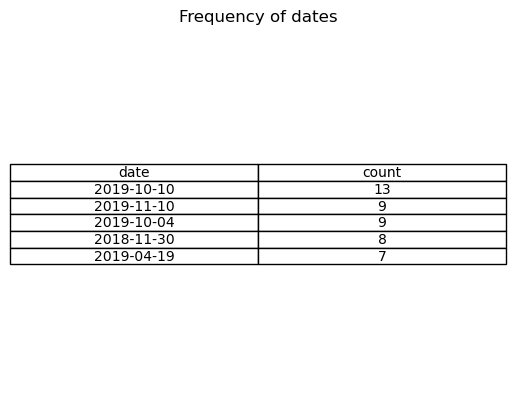

In [141]:
test = supplemented_studyperiod[supplemented_studyperiod['img_ros_labels_avg'] == 1]
frequency = test['date'].value_counts().reset_index().head(5)
frequency.columns = ['date', 'count']
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=frequency.values, colLabels=frequency.columns, cellLoc = 'center', loc='center')

plt.title('Frequency of dates')
plt.show()

In [142]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs
# import cartopy.feature as cfeature
# import numpy as np
# from pyproj import Proj, transform
# from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
# import matplotlib.font_manager as fm

# # Define latitude and longitude points to plot (example points)
# latitudes = cameras_used_study['Latitude']
# longitudes = cameras_used_study['Longitude']

# latitudesWS = close_ws_df['latitude']
# longitudesWS = close_ws_df ['longitude']

# # Initialize the UTM 33 projection
# utm_proj = Proj(proj='utm', zone=33, ellps='WGS84')

# # Convert latitude and longitude to UTM 33
# utm_x, utm_y = utm_proj(longitudes, latitudes)
# utm_xWS, utm_yWS = utm_proj(longitudesWS, latitudesWS)

# # Make the figure larger
# fig = plt.figure(figsize=(8, 8))

# # Set the axes using UTM 33 projection
# ax = plt.axes(projection=ccrs.UTM(33))

# # Set the map extent to zoom into Norway (latitudes 50 to 75 N and longitudes 5 to 35 E)
# ax.set_extent([5, 22, 57.5, 70], crs=ccrs.PlateCarree())  # Longitude from 5E to 30E, Latitude from 57.5N to 71N
# #30, 25 also looks good
# ## 71
# # Add coastlines and ocean features
# ax.coastlines(resolution='10m')
# ax.add_feature(cfeature.OCEAN, color='lightblue')

# # Add country borders
# ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')

# # Add gridlines
# gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', alpha=0.25)
# gl.right_labels = False
# gl.top_labels = False

# # gl.xlabels_top = False
# # gl.xlabels_bottom = True
# # gl.ylabels_left = True
# # gl.ylabels_right = False
# gl.xlabel_style = {'size': 14}  # Change to your desired font size
# gl.ylabel_style = {'size': 14}  # Change to your desired font size


# # Plot the UTM coordinates as points
# ax.scatter( utm_xWS, utm_yWS, 
#            color='purple', marker='o', s=50, label='weather stations', edgecolor='gray', linewidth=0.5, alpha = 0.5)
# ax.scatter(utm_x, utm_y, color='orange', marker='o', s=50, label='camera stations', edgecolor='gray', linewidth=0.5, alpha = 0.5)
# # ax.scatter( utm_xWS, utm_yWS, 
# #            color='purple', marker='o', s=50, label='weather stations', edgecolor='gray', linewidth=0.5, alpha = 0.5)


# norway_x, norway_y = utm_proj(10, 62)
# sweden_x, sweden_y = utm_proj(17, 64)
# ax.text(norway_x, norway_y, 'Norway', fontsize=12, ha='center', color='black', fontweight='bold')
# ax.text(sweden_x, sweden_y, 'Sweden', fontsize=12, ha='center', color='grey', fontweight='bold')

# fontprops = fm.FontProperties(size=10)
# scalebar = AnchoredSizeBar(ax.transData,
#                            100000, '100 km', 'lower left', 
#                            pad=0.1,
#                            color='black',
#                            frameon=False,
#                            size_vertical=0.005,
#                            fontproperties=fontprops)

# ax.add_artist(scalebar)

# # Add a legend
# ax.legend(bbox_to_anchor=(0.57, 0.9), facecolor = 'white',frameon=True, fontsize =14, edgecolor = 'black')

# # Display the plot
# plt.show()


In [143]:
supplemented_studyperiod

,index,date,id,latitude,longitude,precip,air_temp10M,snowdepth,raster_value,ros_event,...,nonvegs,sca,snow,rain_on_snow3,img_ros_labels,confidences,cam_ids,dist_ws,filenames,img_ros_labels_avg
0,41473,2018-01-02,SN18920,59.957300,10.671000,0.0,1.6,NaN,0.0,1.0,...,24.0,200.0,41.0,0,0,0.002338323,507,29683.29919861181,507_20180115 (1628).JPG,0
1,41474,2018-01-02,SN18950,59.984799,10.669232,0.0,0.0,43.0,0.0,1.0,...,13.0,200.0,47.0,0,0,0.002338323,507,24067.13009300311,507_20180115 (1628).JPG,0
2,41510,2018-01-02,SN4460,60.117300,10.829000,0.0,0.1,38.2,0.0,1.0,...,17.0,200.0,60.0,0,0,0.002338323,507,10954.037363895915,507_20180115 (1628).JPG,0
3,41534,2018-01-03,SN18920,59.957300,10.671000,0.9,-0.3,NaN,0.0,1.0,...,24.0,200.0,41.0,0,0,0.0022831876,507,29683.29919861181,507_20180115 (1629).JPG,0
4,41535,2018-01-03,SN18950,59.984799,10.669232,5.0,-2.4,43.0,0.0,1.0,...,13.0,200.0,47.0,0,0,0.0022831876,507,24067.13009300311,507_20180115 (1629).JPG,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1164,131602,2020-02-02,SN19710,59.855800,10.435800,0.0,5.0,6.3,0.0,1.0,...,16.0,200.0,48.0,0,"1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0...","0.45030996, 0.27053043, 0.017138418, 0.0325156...","842, 842, 842, 842, 842, 842, 842, 842, 842, 8...","21877.91481067284, 21877.91481067284, 21877.91...","842_20200212 (5255).JPG, 842_20200212 (5256).J...",0
1165,131742,2020-02-03,SN19430,59.892330,10.540330,0.0,1.3,NaN,0.0,0.0,...,32.0,100.0,NaN,0,0,0.09732356,447,18691.04501589956,447_20200215 (31).JPG,0
1166,131743,2020-02-03,SN19660,59.947500,10.385500,1218.7,-1.6,NaN,0.0,1.0,...,15.0,200.0,35.0,0,"1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1...","0.65924364, 0.5933172, 0.8844523, 0.32894424, ...","842, 842, 842, 842, 842, 842, 842, 842, 842, 8...","15419.951477557646, 15419.951477557646, 15419....","842_20200212 (5259).JPG, 842_20200212 (5260).J...",1
1167,131744,2020-02-03,SN19710,59.855800,10.435800,5.0,1.0,9.3,0.0,1.0,...,16.0,200.0,48.0,0,"1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1...","0.65924364, 0.5933172, 0.8844523, 0.32894424, ...","842, 842, 842, 842, 842, 842, 842, 842, 842, 8...","21877.91481067284, 21877.91481067284, 21877.91...","842_20200212 (5259).JPG, 842_20200212 (5260).J...",1


In [144]:
supplemented_studyperiod = supplemented_studyperiod[['date','id','img_ros_labels_avg']]
alltogether = pd.merge(grouped_df, supplemented_studyperiod, left_on = ['date','id'], right_on = ['date','id'], how = 'left' )

In [145]:
alltogether['date'] = pd.to_datetime(alltogether['date'])
alltogether_study_period = alltogether[((alltogether['date'] > '2018-01-01') & (alltogether['date'] < '2018-05-01')) | 
                                          ((alltogether['date'] > '2019-10-01') & (alltogether['date'] < '2020-04-01')) | 
                                          ((alltogether['date'] > '2018-10-01') & (alltogether['date'] < '2019-05-01')) ].reset_index()
## baseline accuracy metrics ## 
alltogether_study_period['supplemented'] = [i if i in [0, 1] else alltogether_study_period['ros_event_drysnowcheck'][idx]  #ros_event_drysnowcheck
    for idx, i in enumerate(alltogether_study_period['img_ros_labels_avg'])]

# alltogether_study_period['supplemented_snow'] = [
#     0 if i == 1 and ((alltogether_study_period['snow'].iloc[idx] < 40) or (alltogether_study_period['sca'].iloc[idx] != 200)) else i 
#     for idx, i in enumerate(alltogether_study_period['supplemented'])
# ]

alltogether_study_period['supplemented_snow'] = [
    1 if i == 1 and ((alltogether_study_period['snow'].iloc[idx] >= 40) or (alltogether_study_period['sca'].iloc[idx] == 200)) else 0 
    for idx, i in enumerate(alltogether_study_period['supplemented'])
]

In [146]:
alltogether_study_period.columns

Index(['index', 'date', 'id', 'latitude', 'longitude', 'precip', 'air_temp10M',
       'snowdepth', 'raster_value', 'ros_event', 'ros_event75', 'ros_event02',
       'ros_event_roc', 'ros_event_drysnowcheck', 'rain_on_snow',
       'rain_on_snow2', 'grp_value', 'elev', 'water', 'waterlow', 'tree',
       'veg', 'nonvegs', 'sca', 'snow', 'rain_on_snow3', 'img_ros_labels',
       'confidences', 'cam_ids', 'dist_ws', 'filenames', 'img_ros_labels_avg',
       'supplemented', 'supplemented_snow'],
      dtype='object')

In [147]:
subset_stations_only = alltogether_study_period[alltogether_study_period['id'].isin(stations)]
subset_stations_only

,index,date,id,latitude,longitude,precip,air_temp10M,snowdepth,raster_value,ros_event,...,snow,rain_on_snow3,img_ros_labels,confidences,cam_ids,dist_ws,filenames,img_ros_labels_avg,supplemented,supplemented_snow
0,41458,2018-01-02,SN11500,60.70020,10.86950,0.4,0.7,NaN,0.0,1.0,...,86.0,0,None,None,NaN,None,None,NaN,0.0,0
3,41461,2018-01-02,SN17150,59.37420,10.79800,0.0,2.7,NaN,0.0,1.0,...,30.0,0,None,None,NaN,None,None,NaN,0.0,0
4,41462,2018-01-02,SN17850,59.66050,10.78180,0.0,0.5,-0.4,0.0,1.0,...,45.0,0,None,None,NaN,None,None,NaN,0.0,0
5,41463,2018-01-02,SN17870,59.67040,10.81040,0.0,0.4,NaN,0.0,1.0,...,62.0,0,None,None,NaN,None,None,NaN,0.0,0
6,41464,2018-01-02,SN17980,59.84270,10.82370,0.0,0.9,NaN,0.0,1.0,...,34.0,0,None,None,NaN,None,None,NaN,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63271,139938,2020-03-31,SN6690,60.85667,11.40033,0.0,10.1,NaN,0.0,0.0,...,0.0,0,None,None,NaN,None,None,NaN,0.0,0
63281,139948,2020-03-31,SN78360,66.13170,13.58670,34.2,3.7,125.0,0.0,0.0,...,NaN,0,None,None,NaN,None,None,NaN,0.0,0
63297,139964,2020-03-31,SN84920,68.53000,17.42550,56.1,0.8,NaN,0.0,0.0,...,NaN,0,None,None,NaN,None,None,NaN,0.0,0
63299,139966,2020-03-31,SN87970,68.62067,17.65133,31.9,0.1,NaN,0.0,1.0,...,63.0,0,None,None,NaN,None,None,NaN,0.0,0


(array([948.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 221.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

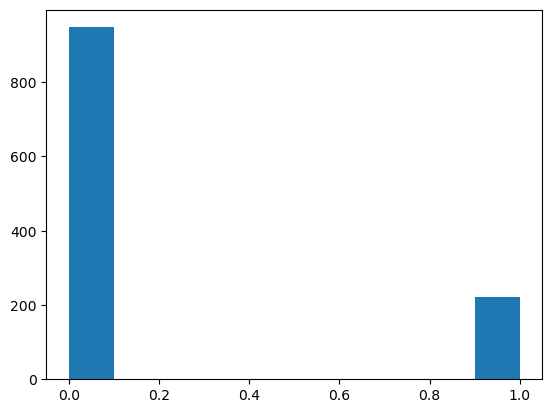

In [148]:
plt.hist((subset_stations_only['img_ros_labels_avg']))

In [149]:
alltogether_study_period.columns

Index(['index', 'date', 'id', 'latitude', 'longitude', 'precip', 'air_temp10M',
       'snowdepth', 'raster_value', 'ros_event', 'ros_event75', 'ros_event02',
       'ros_event_roc', 'ros_event_drysnowcheck', 'rain_on_snow',
       'rain_on_snow2', 'grp_value', 'elev', 'water', 'waterlow', 'tree',
       'veg', 'nonvegs', 'sca', 'snow', 'rain_on_snow3', 'img_ros_labels',
       'confidences', 'cam_ids', 'dist_ws', 'filenames', 'img_ros_labels_avg',
       'supplemented', 'supplemented_snow'],
      dtype='object')

In [150]:
actual = subset_stations_only['rain_on_snow3']  # Replace with your actual binary labels (0 or 1)
predicted = subset_stations_only['supplemented_snow' ]  # Replace with your model's binary predictions (0 or 1)

# Calculate various metrics
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted)
recall = recall_score(actual, predicted)
f1 = f1_score(actual, predicted)
roc_auc = roc_auc_score(actual, predicted)
mcc = matthews_corrcoef(actual, predicted)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

Accuracy: 0.9439
Precision: 0.1348
Recall: 0.0301
F1 Score: 0.0492
ROC AUC: 0.5102
Matthews Correlation Coefficient (MCC): 0.0421


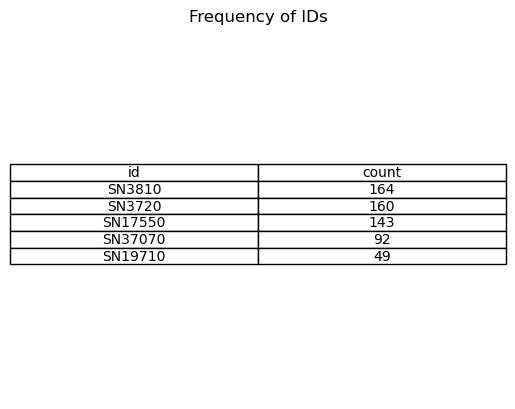

In [151]:
# Step 2: Create a table
frequency = subset_stations_only[subset_stations_only['img_ros_labels'] != 'None']['id'].value_counts().reset_index().head(5)
frequency.columns = ['id', 'count']
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=frequency.values, colLabels=frequency.columns, cellLoc = 'center', loc='center')

plt.title('Frequency of IDs')
plt.show()

In [152]:
actual = subset_stations_only[subset_stations_only['id'] == 'SN17550']['rain_on_snow3']  # Replace with your actual binary labels (0 or 1)
before = subset_stations_only[subset_stations_only['id'] == 'SN17550']['ros_event']  # Replace with your model's binary predictions (0 or 1)
after = subset_stations_only[subset_stations_only['id'] == 'SN17550']['supplemented_snow' ]  # Replace with your model's binary predictions (0 or 1)

predicted = after

# Calculate various metrics
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted)
recall = recall_score(actual, predicted)
f1 = f1_score(actual, predicted)
roc_auc = roc_auc_score(actual, predicted)
mcc = matthews_corrcoef(actual, predicted)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

Accuracy: 0.9500
Precision: 0.1667
Recall: 0.0667
F1 Score: 0.0952
ROC AUC: 0.5265
Matthews Correlation Coefficient (MCC): 0.0827


In [153]:
subset_stations_only.columns

Index(['index', 'date', 'id', 'latitude', 'longitude', 'precip', 'air_temp10M',
       'snowdepth', 'raster_value', 'ros_event', 'ros_event75', 'ros_event02',
       'ros_event_roc', 'ros_event_drysnowcheck', 'rain_on_snow',
       'rain_on_snow2', 'grp_value', 'elev', 'water', 'waterlow', 'tree',
       'veg', 'nonvegs', 'sca', 'snow', 'rain_on_snow3', 'img_ros_labels',
       'confidences', 'cam_ids', 'dist_ws', 'filenames', 'img_ros_labels_avg',
       'supplemented', 'supplemented_snow'],
      dtype='object')

In [154]:
pd.unique(subset_stations_only['id'])

array(['SN11500', 'SN17150', 'SN17850', 'SN17870', 'SN17980', 'SN18020',
       'SN18210', 'SN18269', 'SN18315', 'SN18420', 'SN18700', 'SN18701',
       'SN18920', 'SN18950', 'SN19710', 'SN19825', 'SN26060', 'SN26500',
       'SN26590', 'SN35210', 'SN3720', 'SN3810', 'SN38140', 'SN38730',
       'SN39750', 'SN4460', 'SN65451', 'SN78360', 'SN18500', 'SN20280',
       'SN17050', 'SN17380', 'SN19940', 'SN20540', 'SN26820', 'SN3290',
       'SN3370', 'SN4260', 'SN64760', 'SN1070', 'SN17550', 'SN17640',
       'SN17650', 'SN17875', 'SN17895', 'SN18240', 'SN18265', 'SN18280',
       'SN18410', 'SN18690', 'SN19430', 'SN19660', 'SN19830', 'SN37070',
       'SN4827', 'SN6580', 'SN66175', 'SN6690', 'SN84920', 'SN87970',
       'SN90', 'SN6700', 'SN66120', 'SN4455', 'SN65275'], dtype=object)

/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_46249/3800945242.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['date'] = pd.to_datetime(subset['date'])
/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_46249/3800945242.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['date'] = pd.to_datetime(subset['date'])
/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_46249/3800945242.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

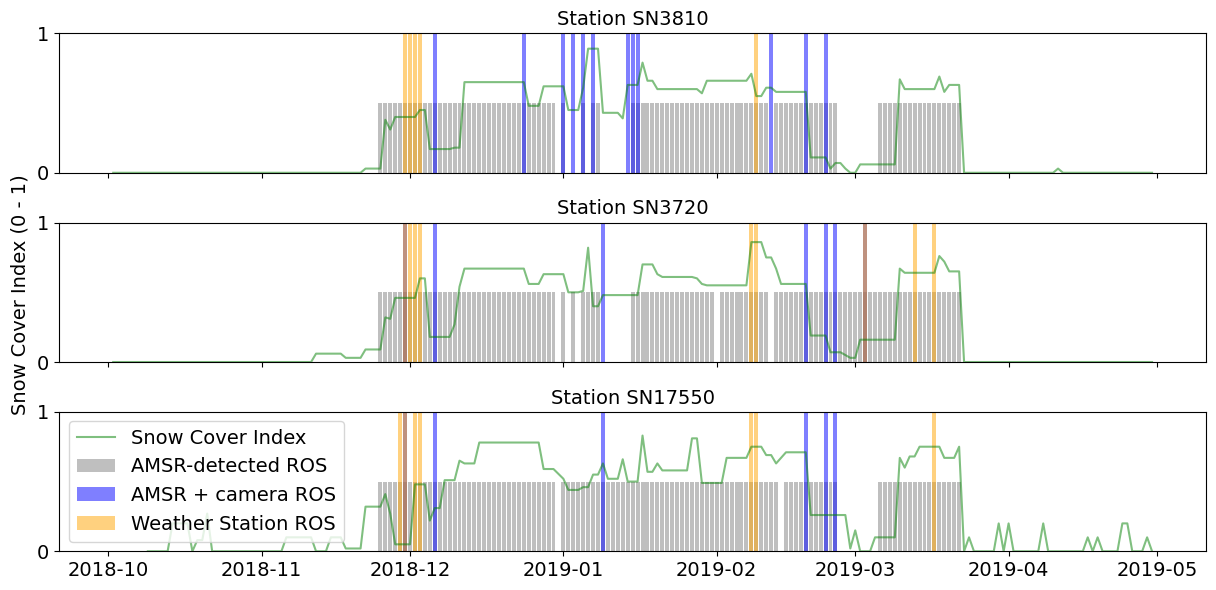

In [155]:
## plot the top three stations

stations1 = ['SN3810', 'SN3720','SN17550']
#['SN3810', 'SN3720','SN17550'] SN11500
# Set up the figure and axes
fig, ax = plt.subplots(len(stations1), 1, figsize=(12, 6), sharex=True)

for i, station in enumerate(stations1): 
    subset = subset_stations_only[subset_stations_only['id'] == station]
    subset['date'] = pd.to_datetime(subset['date'])
    subset = subset[(subset['date']>'2018-10-01') & (subset['date']<'2019-05-01')]
 
    ax[i].bar(pd.to_datetime(subset['date']), 
            subset['ros_event']*0.5, #ros_event_roc 
            color='grey', alpha=0.5, label='AMSR-detected ROS')
    ax[i].bar(pd.to_datetime(subset['date']), 
            subset['supplemented_snow'], #ros_event_roc 
            color='blue', alpha=0.5, label='AMSR + camera ROS')
    ax[i].bar(pd.to_datetime(subset['date']), 
            subset['rain_on_snow3'], 
            color='orange', alpha=0.5, label='Weather Station ROS')
    ax[i].plot(pd.to_datetime(subset['date']), 
            subset['snow']/100, 
            color='green', alpha=0.5, label='Snow Cover Index')
    
    # Titles, labels, and legends
    ax[i].set_ylim([0 , 1])
    ax[i].set_yticks([0 , 1])
    ax[i].tick_params(axis='y', labelsize=14)
    ax[i].set_title(f'Station {station}', fontsize =14)
    
    # Combine both legends and position them in the top right corner
lines, labels = [], []
for ax_ in [ax[i]]:
    for line in ax_.get_legend_handles_labels()[0]:
        lines.append(line)
    for label in ax_.get_legend_handles_labels()[1]:
        labels.append(label)

ax[i].legend(lines, labels, loc='lower left', fontsize=14)
ax[-1].tick_params(axis='x', labelsize=14)

# Show the plot
#plt.ylabel('Snow Cover Index (0 - 1)')
fig.text(-0.01, 0.5, 'Snow Cover Index (0 - 1)', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()
plt.show()



In [335]:
subset_stations_only.to_csv('subset_test_schneider.csv')

/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_46249/1170553902.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['date'] = pd.to_datetime(subset['date'])


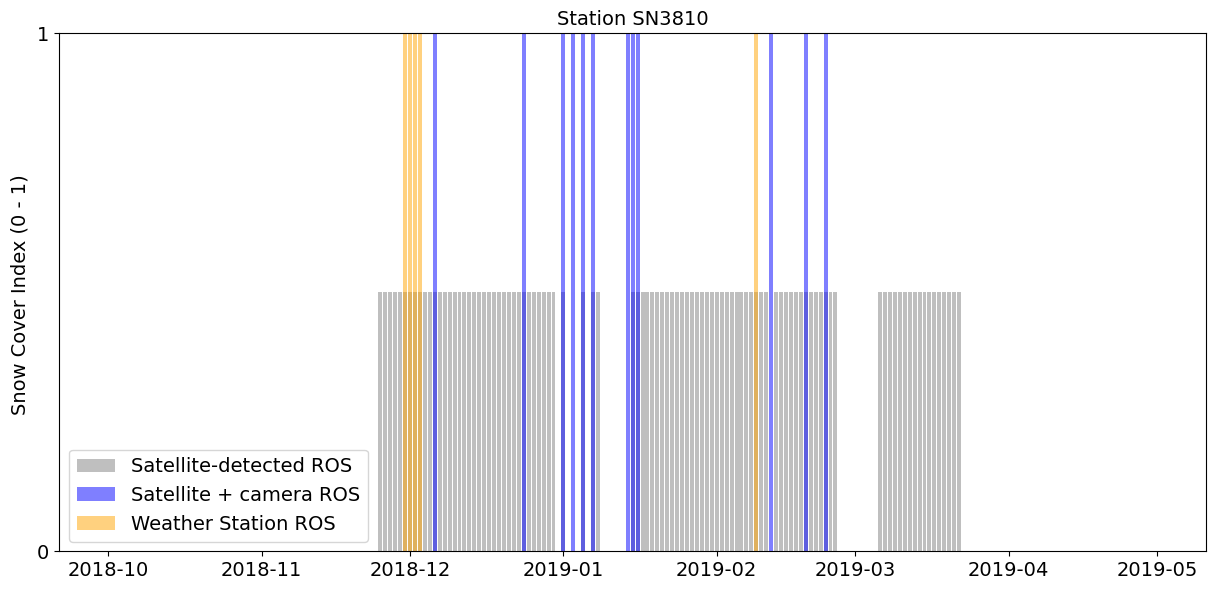

In [334]:
import matplotlib.pyplot as plt
import pandas as pd

# List of stations (you mentioned to plot just the first one)
stations1 = ['SN3810', 'SN3720', 'SN17550']
station = stations1[0]  # Use only the first station

# Set up the figure and axes (single plot for one station)
fig, ax = plt.subplots(figsize=(12, 6))

# Filter the data for the selected station
subset = subset_stations_only[subset_stations_only['id'] == station]
subset['date'] = pd.to_datetime(subset['date'])
subset = subset[(subset['date'] > '2018-10-01') & (subset['date'] < '2019-05-01')]

# Plot the data
ax.bar(pd.to_datetime(subset['date']), 
       subset['ros_event'] * 0.5, 
       color='grey', alpha=0.5, label='Satellite-detected ROS')
ax.bar(pd.to_datetime(subset['date']), 
       subset['supplemented_snow'], 
       color='blue', alpha=0.5, label='Satellite + camera ROS')
ax.bar(pd.to_datetime(subset['date']), 
       subset['rain_on_snow3'], 
       color='orange', alpha=0.5, label='Weather Station ROS')

# Set y-axis limits and labels
ax.set_ylim([0, 1])
ax.set_yticks([0, 1])
ax.tick_params(axis='y', labelsize=14)

# Add title
ax.set_title(f'Station {station}', fontsize=14)

# Combine both legends and position them in the lower left corner
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='lower left', fontsize=14)

# Label the x-axis
ax.tick_params(axis='x', labelsize=14)

# Set the common y-axis label
fig.text(-0.01, 0.5, 'Snow Cover Index (0 - 1)', va='center', rotation='vertical', fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [1130]:
## for the figure 5
#subset_stations_only.to_csv('subset_stations_only.csv')

In [1039]:
#alltogether_study_period[subset_stations_only['date'] == '2018-11-30']
subset_stations_only[subset_stations_only['date'] == '2018-11-30'] #[['sca','snow','rain_on_snow3','img_ros_labels_avg','supplemented_snow']]

,index,date,id,latitude,longitude,precip,air_temp10M,snowdepth,raster_value,ros_event,...,snow,rain_on_snow3,img_ros_labels,confidences,cam_ids,dist_ws,filenames,img_ros_labels_avg,supplemented,supplemented_snow
15661,69464,2018-11-30,SN1070,59.041884,11.032146,6.0,7.0,NaN,1.0,0.0,...,9.0,0,None,None,None,None,None,NaN,0.0,0
15666,69469,2018-11-30,SN11500,60.700200,10.869500,1.6,6.1,NaN,0.0,1.0,...,7.0,0,None,None,None,None,None,NaN,0.0,0
15677,69480,2018-11-30,SN17050,59.318800,10.814500,28.2,7.4,NaN,1.0,1.0,...,36.0,1,1,0.92344624,231,25029.687176262458,231_20190110 (379).JPG,1.0,1.0,1
15678,69481,2018-11-30,SN17150,59.374200,10.798000,36.9,7.5,NaN,1.0,1.0,...,37.0,1,1,0.92344624,231,15789.434849616877,231_20190110 (379).JPG,1.0,1.0,1
15679,69482,2018-11-30,SN17380,59.398000,10.754300,24.0,7.4,NaN,1.0,1.0,...,34.0,1,1,0.92344624,231,17136.003833553506,231_20190110 (379).JPG,1.0,1.0,1
15680,69483,2018-11-30,SN17550,59.517670,10.725170,18.2,6.7,NaN,1.0,1.0,...,5.0,1,"1, 1","0.92344624, 0.7183984","231, 1267","28037.539636673857, 20217.126383800503","231_20190110 (379).JPG, 1267_20190723 (22).JPG",1.0,1.0,1
15681,69484,2018-11-30,SN17640,59.739670,11.008330,0.0,6.2,NaN,1.0,1.0,...,56.0,0,None,None,None,None,None,NaN,0.0,0
15682,69485,2018-11-30,SN17650,59.600170,10.739500,38.7,6.1,NaN,1.0,1.0,...,68.0,1,1,0.7183984,1267,22588.128515443714,1267_20190723 (22).JPG,1.0,1.0,1
15683,69486,2018-11-30,SN17850,59.660500,10.781800,29.5,7.1,0.6,1.0,1.0,...,75.0,1,1,0.7183984,1267,29963.309644286102,1267_20190723 (22).JPG,1.0,1.0,1
15684,69487,2018-11-30,SN17870,59.670400,10.810400,23.2,6.6,NaN,1.0,1.0,...,51.0,1,None,None,None,None,None,NaN,0.0,0


In [159]:
locations = pd.read_csv('/Users/catherinebreen/Dropbox/RemoteSensingPaper/datasets/ScandCam_AllCameras_05072020_GEE.csv') 
transformer = Transformer.from_crs("epsg:4326", "epsg:6931", always_xy=True)
locations[['longitude_6931', 'latitude_6931']] = locations.apply(
    lambda row: transformer.transform(row['Longitude'], row['Latitude']), axis=1, result_type='expand'
)
# Display the DataFrame with the new coordinates
print(locations[['longitude_6931', 'latitude_6931']].head())
print(locations[['Longitude', 'Latitude']].head())


x, y = locations['longitude_6931'], locations['latitude_6931']  # These are the coordinates in EPSG:6931
locations['colCAM'], locations['rowCAM'] = rowcol(transform1, x, y) 

   longitude_6931  latitude_6931
0   632628.892696  -3.258992e+06
1   633795.690419  -3.260317e+06
2   638835.003534  -3.260628e+06
3   627252.571030  -3.267699e+06
4   638515.563873  -3.261048e+06
   Longitude   Latitude
0  10.985514  59.906999
1  11.000918  59.892844
2  11.085197  59.881037
3  10.866062  59.837007
4  11.078400  59.877776


In [160]:
subset_stations_only
subset_stations_only[['longitude_6931', 'latitude_6931']] = subset_stations_only.apply(
    lambda row: transformer.transform(row['longitude'], row['latitude']), axis=1, result_type='expand'
)
# Display the DataFrame with the new coordinates
print(subset_stations_only[['longitude_6931', 'latitude_6931']].head())
print(subset_stations_only[['longitude', 'latitude']].head())


x, y = subset_stations_only['longitude_6931'], subset_stations_only['latitude_6931']  # These are the coordinates in EPSG:6931
subset_stations_only['colWS'], subset_stations_only['rowWS'] = rowcol(transform1, x, y) 

   longitude_6931  latitude_6931
0   609919.550883  -3.176373e+06
3   632692.307342  -3.317318e+06
4   625997.501209  -3.287267e+06
5   627438.646298  -3.285908e+06
6   624721.428188  -3.267561e+06
   longitude  latitude
0    10.8695   60.7002
3    10.7980   59.3742
4    10.7818   59.6605
5    10.8104   59.6704
6    10.8237   59.8427


/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_46249/3802213884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_stations_only[['longitude_6931', 'latitude_6931']] = subset_stations_only.apply(
/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_46249/3802213884.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_stations_only[['longitude_6931', 'latitude_6931']] = subset_stations_only.apply(
/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_46249/3802213884.py:1

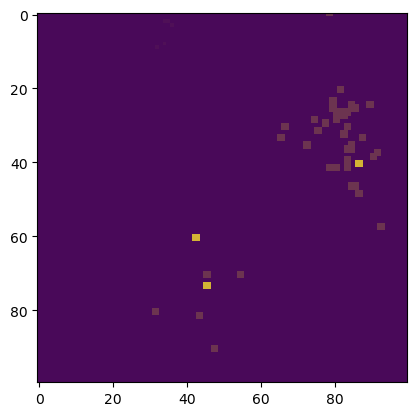

In [161]:

weatherstationNov = subset_stations_only[subset_stations_only['date'] == '2018-11-30']
ws_cols = weatherstationNov['colWS'].values
ws_rows =  weatherstationNov['rowWS'].values

cameramappingNov = ['237', '1267', '1140']
locations_subset = locations[locations['LokalitetID'].astype(str).isin(cameramappingNov)]
locations_cols = locations_subset['colCAM'].values
locations_rows =  locations_subset['rowCAM'].values

weather_station_array_low = np.zeros((array.shape[0], array.shape[1]))
camera_array_low = np.zeros((array.shape[0], array.shape[1]))
weather_station_array_low[ws_cols, ws_rows] = 1
camera_array_low[locations_cols, locations_rows] = 1

structuring_element1 = np.ones((2, 2))

padded_array_low = binary_dilation(weather_station_array_low, structure=structuring_element1).astype(np.int64)
cam_array_low = binary_dilation(camera_array_low, structure=structuring_element1).astype(np.int64)

#cam_array_low = np.where(camera_array_low == 0, np.nan, 1)

index = rosdate.index('2018-11-30')
dayofinterest = rosarray[index]

plt.imshow(dayofinterest[600:800, 400:500], alpha = 0.5) 
plt.imshow(padded_array_low[600:700, 400:500], alpha = 0.75)
plt.imshow(cam_array_low[600:700, 400:500] ,alpha = 0.75) #[300:600, 550:800]

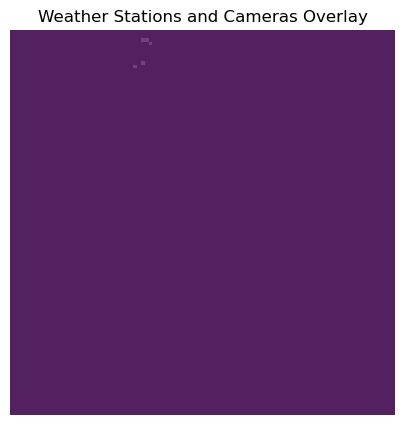

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

# Get the weather station data for the specific date
weatherstationNov = subset_stations_only[subset_stations_only['date'] == '2018-11-30']
ws_cols = weatherstationNov['colWS'].values
ws_rows = weatherstationNov['rowWS'].values
raster_values = weatherstationNov['raster_value'].values  # Assuming this column exists

# Get the camera mapping for the specific date
cameramappingNov = ['237', '1267', '1140']
locations_subset = locations[locations['LokalitetID'].astype(str).isin(cameramappingNov)]
locations_cols = locations_subset['colCAM'].values
locations_rows = locations_subset['rowCAM'].values
img_label_avgs = [1, 1, 1]

# Create empty arrays for weather stations and cameras with RGB channels
weather_station_array_low = np.zeros((array.shape[0], array.shape[1], 3))  # 3 for RGB
camera_array_low = np.zeros((array.shape[0], array.shape[1], 3))  # 3 for RGB

# Fill weather stations: black for 0, red for 1
for col, row, value in zip(ws_cols, ws_rows, raster_values):
    if value == 1:
        weather_station_array_low[row, col] = [1, 0, 0]  # Red
    elif value == 0:
        weather_station_array_low[row, col] = [0, 0, 0]  # Black

# Fill cameras: black for 0, red for 1
for col, row, value in zip(locations_cols, locations_rows, img_label_avgs):
    if value == 1:
        camera_array_low[row, col] = [1, 0, 0]  # Red
    elif value == 0:
        camera_array_low[row, col] = [0, 0, 0]  # Black

# Create a structuring element for dilation
structuring_element1 = np.ones((2, 2))

# Perform binary dilation
weather_station_mask = np.sum(weather_station_array_low, axis=-1) > 0
camera_mask = np.sum(camera_array_low, axis=-1) > 0
padded_array_low = binary_dilation(weather_station_mask, structure=structuring_element1).astype(np.int64)
cam_array_low = binary_dilation(camera_mask, structure=structuring_element1).astype(np.int64)

# Get the day of interest from the rosarray
index = rosdate.index('2018-11-30')
dayofinterest = rosarray[index]

# Plotting
plt.figure(figsize=(5, 5))  # Set figure size
plt.imshow(dayofinterest[600:700, 400:500], alpha=0.5, cmap='gray') 
plt.imshow(padded_array_low[600:700, 400:500], alpha=0.75)  # Weather stations overlay
#plt.imshow(camera_array_low[600:700, 400:500], alpha=0.75)  # Cameras overlay

plt.title('Weather Stations and Cameras Overlay')
plt.axis('off')  # Optional: turn off axis
plt.show()


In [163]:
color


NameError: name 'color' is not defined

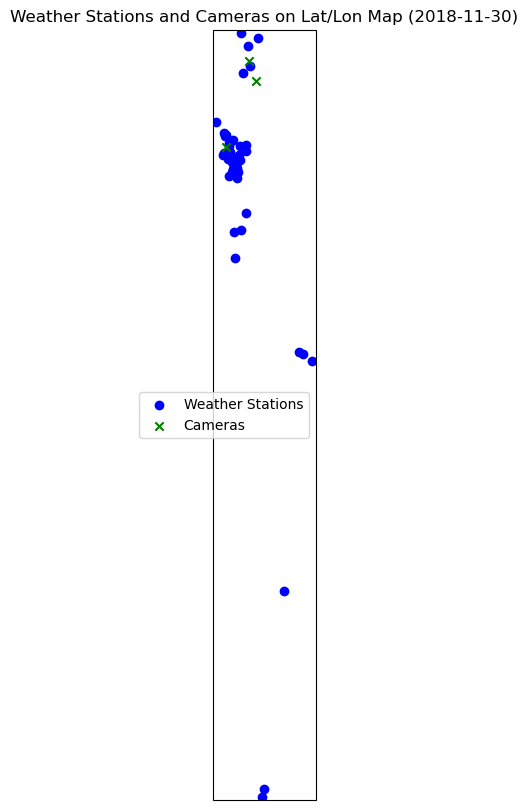

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pyproj import Transformer
from scipy.ndimage import binary_dilation

# Dummy transform matrix (replace with your actual transform)
# Example: (30, 0, left, 0, -30, top) -> affine transform with pixel size (30x30)
transform = transform1
crs_epsg_6931 = "EPSG:6931"
crs_wgs84 = "EPSG:4326"

# Set up the transformer to go from EPSG 6931 to WGS84
transformer = Transformer.from_crs(crs_epsg_6931, crs_wgs84)

# Function to convert pixel coordinates to CRS 6931 real-world coordinates
def pixel_to_geo(col, row, transform):
    """Convert pixel coordinates to CRS 6931 coordinates."""
    x = transform[2] + col * transform[0] + row * transform[1]
    y = transform[5] + col * transform[3] + row * transform[4]
    return x, y

# Convert pixel coordinates (ws_cols and ws_rows) to CRS 6931, then to lat/lon
def convert_pixel_to_latlon(cols, rows, transform, transformer):
    lon_lat = [transformer.transform(*pixel_to_geo(col, row, transform)) for col, row in zip(cols, rows)]
    lons, lats = zip(*lon_lat)
    return lons, lats

# Convert weather station and camera pixel coordinates to lat/lon
ws_lons, ws_lats = convert_pixel_to_latlon(ws_cols, ws_rows, transform, transformer)
cam_lons, cam_lats = convert_pixel_to_latlon(locations_cols, locations_rows, transform, transformer)

# Create a map using Cartopy with PlateCarree projection (lat/lon)
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the ROS data for the day of interest (cropped for illustration)
ax.imshow(dayofinterest[600:800, 400:500], extent=(transform[2], transform[2] + dayofinterest.shape[1] * transform[0], 
           transform[5] + dayofinterest.shape[0] * transform[4], transform[5]), transform=ccrs.PlateCarree(), alpha=0.7)

# Plot the weather station locations
ax.scatter(ws_lons, ws_lats, color='blue', marker='o', label='Weather Stations', transform=ccrs.PlateCarree())

# Plot the camera locations
ax.scatter(cam_lons, cam_lats, color='green', marker='x', label='Cameras', transform=ccrs.PlateCarree())

# Add map features (like coastlines and borders)
ax.coastlines()
ax.set_extent([min(ws_lons + cam_lons) - 0.1, max(ws_lons + cam_lons) + 0.1, 
               min(ws_lats + cam_lats) - 0.1, max(ws_lats + cam_lats) + 0.1], crs=ccrs.PlateCarree())

# Add legend and labels
ax.legend()
plt.title('Weather Stations and Cameras on Lat/Lon Map (2018-11-30)')
plt.show()


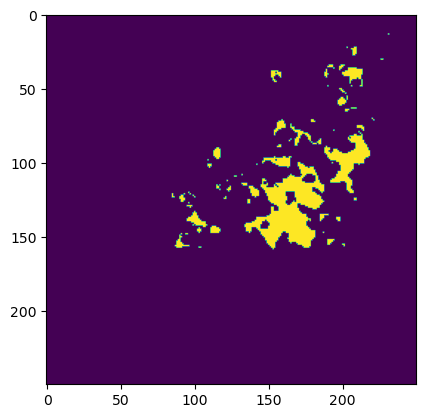

In [165]:
index = rosdate.index('2019-02-09')
dayofinterest = rosarray[index]

plt.imshow(dayofinterest[450:700, 350:600])

In [166]:
## overall big R2 accuracy increase with additional 1127 data points? 
# summary ROS column > take the average value (round to nearest integer)
# combined column, default to camera value if there is one 


In [167]:
## what are the top 3 stations 

In [168]:
# ws_data_joined_cleaned = ws_data_joined.dropna(subset=['raster_value'])  
# ws_data_joined_cleaned = ws_data_joined_cleaned[ws_data_joined_cleaned['grp_value'] > -9990] 

# fig, ax = plt.subplots(3,1, figsize=(12,6))
# ax1 = ax[0].twinx()
# ax1.plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN88100']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN88100']['rain_on_snow2'], c = 'orange', label = 'weather_station')
# ax[0].plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN88100']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN88100']['raster_value'], label = 'GRP')
# ax[0].legend()
# ax[0].set_ylim(-3,3)
# ax1.set_ylabel('weather_station ROS')

# ax2 = ax[1].twinx()
# ax2.plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['rain_on_snow2'], c = 'orange', label = 'weather_station')
# ax[1].plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['raster_value'], label = 'GRP')
# ax[1].legend()
# ax[1].set_ylim(-3,3)
# ax2.set_ylabel('weather_station ROS')

# ax3 = ax[2].twinx()
# ax3.plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['rain_on_snow2'], c = 'orange', label = 'weather_station')
# ax[2].plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['raster_value'], label = 'GRP')
# ax[2].legend()
# ax[2].set_ylim(-3,3)
# ax3.set_ylabel('weather_station ROS')

In [169]:
# fig, ax = plt.subplots(3,1, figsize=(12,6))
# ax1 = ax[0].twinx() #SN88100
# ax1.plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN17850']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN17850']['rain_on_snow'], c = 'orange', label = 'weather_station')
# ax[0].plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN17850']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN17850']['snow'], label = 'NDSI')
# ax[0].legend()
# ax1.set_ylabel('weather_station ROS')

# ax2 = ax[1].twinx()
# ax2.plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['rain_on_snow'], c = 'orange', label = 'weather_station')
# ax[1].plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['snow'], label = 'NDSI')
# ax[1].legend()
# ax2.set_ylabel('weather_station ROS')

# ax3 = ax[2].twinx()
# ax3.plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['rain_on_snow'], c = 'orange', label = 'weather_station')
# ax[2].plot(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['snow'], label = 'NDSI')
# ax[2].legend()
# ax3.set_ylabel('weather_station ROS')

In [170]:
# fig, ax = plt.subplots(3,1, figsize=(12,6))
# ax1 = ax[0].twinx()
# ax1.bar(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN88100']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN88100']['rain_on_snow2'], color = 'orange', alpha =0.5, label = 'weather_station')
# ax[0].bar(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN88100']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN88100']['raster_value'], color = 'blue', alpha =0.5, label = 'AMSR-detected ROS')
# ax[0].legend()
# ax[0].legend(loc='upper right')
# ax1.legend(loc='upper left')


# ax2 = ax[1].twinx()
# ax2.bar(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['rain_on_snow2'], color = 'orange', alpha =0.5, label = 'weather_station')
# ax[1].bar(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN78360']['raster_value'],color = 'blue', alpha =0.5, label = 'AMSR-detected ROS')
# ax[1].legend()
# ax2.set_ylabel('weather_station ROS')
# ax[1].legend(loc='upper right')
# ax2.legend(loc='upper left')


# ax3 = ax[2].twinx()
# ax3.bar(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['rain_on_snow2'], color = 'orange', alpha =0.5, label = 'weather_station')
# ax[2].bar(pd.to_datetime(ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['date']), 
#             ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN84500']['raster_value'], color = 'blue', alpha =0.5, label = 'AMSR-detected ROS')
# ax[2].legend()
# ax3.set_ylabel('weather_station ROS')
# ax[2].legend(loc='upper right')
# ax3.legend(loc='upper left')


In [171]:
# mean_GRP = np.mean(ws_data_joined_cleaned[ws_data_joined_cleaned['rain_on_snow'] == 1]['grp_value'])
# print(mean_GRP)

# mean_GRP = np.std(ws_data_joined_cleaned[ws_data_joined_cleaned['rain_on_snow'] == 1]['grp_value'])
# print(mean_GRP)

# mean_GRP = np.mean(ws_data_joined_cleaned[ws_data_joined_cleaned['rain_on_snow'] == 1]['grp_value'])
# print(mean_GRP)

# mean_GRP = np.std(ws_data_joined_cleaned[ws_data_joined_cleaned['rain_on_snow2'] == 1]['grp_value'])
# print(mean_GRP)

# mean_GRPLowElev = np.mean(ws_data_joined_cleaned[(ws_data_joined_cleaned['rain_on_snow2'] == 1) & (ws_data_joined_cleaned['elev'] < 300)]['grp_value'])
# print(mean_GRPLowElev)



In [172]:
# np.std(ws_data_joined_cleaned['elev'])
# ws_data_joined_cleaned

In [173]:
# fig, ax = plt.subplots(1,2, figsize=(12,6))

# subset = ws_data_joined_cleaned[ws_data_joined_cleaned['id'] == 'SN88100']
# subset['date'] = pd.to_datetime(subset['date'])
# #subset = subset[subset['date']< '2019-06-01']
# ax1_twin = ax[0].twinx()  # Create a secondary axis for ax[0]
# ax[0].plot(pd.to_datetime(subset['date']), 
#            subset['raster_value'], label='GRP', color='tab:blue')
# ax1_twin.plot(subset['date'], 
#               subset['rain_on_snow'], label='Weather Stations', color='tab:red')

# ax[0].set_ylabel('GRP')
# ax1_twin.set_ylabel('Rain on Snow')
# ax[0].legend(loc='upper left')
# ax1_twin.legend(loc='upper right')


# # ax[1].scatter(subset['date'], subset['snowdepth'], c = 'red')
# # ax[1].scatter(subset['date'], subset['air_temp10M'])
# # ax[1].scatter(subset['date'], subset['precip'])

# # Scatter plot for snowdepth on the main y-axis (ax1)
# ax[1].plot(subset['date'], subset['snowdepth'], c='red', label='Snow Depth')
# ax[1].set_ylabel('Snow Depth', color='red')
# ax[1].tick_params(axis='y', labelcolor='red')

# # Create a secondary y-axis for air_temp10M using twinx()
# ax2 = ax[1].twinx()
# ax2.plot(subset['date'], subset['air_temp10M'], c='blue', label='Air Temp (10M)')
# ax2.set_ylabel('Air Temp (10M)', color='blue')
# ax2.tick_params(axis='y', labelcolor='blue')

# # Create a third y-axis for precip by overlaying a new axis on the right
# ax3 = ax[1].twinx()
# ax3.plot(subset['date'], subset['precip'], c='green', label='Precipitation')
# ax3.spines['right'].set_position(('outward', 60))  # Move the third axis outward to avoid overlap
# ax3.set_ylabel('Precipitation', color='green')
# ax3.tick_params(axis='y', labelcolor='green')

# # Set the x-axis label
# ax[1].set_xlabel('Date')


In [174]:
# ws_data_joined[ws_data_joined['raster_value'] > 0]

In [175]:
# ws_data_joined_cleaned = ws_data_joined.dropna(subset=['raster_value'])  
# ws_data_joined_cleaned['hour'] = [i.split('T')[1].split(':')[0] for i in ws_data_joined_cleaned['referenceTime']]
# ws_data_joined_cleaned

In [176]:
# pd.unique(ws_data_joined_cleaned['sca'])

In [177]:
# grouped_df['AMSR_snowdepth'] = np.where((grouped_df['grp_value'] < 1) & (grouped_df['snowdepth'] > 5), 
#                                          1, 0)

# grouped_df['AMSR_GRP06'] = np.where((grouped_df['grp_value'] < -0.06) & (grouped_df['snow'] > 40) & (grouped_df['grp_value'] > -9998),
#                                          1, 0)
# grouped_df


In [178]:
# # Convert 'date' column to datetime format
# grouped_df['date'] = pd.to_datetime(grouped_df['date'])

# # Sort by 'id' and 'date'
# grouped_df = grouped_df.sort_values(by=['id', 'date'])
# grouped_df
# # # Get the precipitation of the previous day for each station
# grouped_df['precip_day_before'] = grouped_df.groupby('id')['precip'].shift(1)

# # # Add the new column based on the conditions
# grouped_df['rain_on_snow3'] = ((grouped_df['precip'] > 5) & ## cohen paper
#                     (grouped_df['air_temp10M'] >= 1) &
#                     (grouped_df['snowdepth'] > 5)) # &
#                   #  (grouped_df['precip_day_before'] < 5)).astype(int)

# grouped_df

In [179]:
# # ws_data_joined_cleaned['date'] = pd.to_datetime(ws_data_joined_cleaned['date'])

# # wateryear2018 = ws_data_joined_cleaned[ws_data_joined_cleaned['date']<'2018-06-01']
# # wateryear2019 = ws_data_joined_cleaned[(ws_data_joined_cleaned['date']>'2018-06-01') & (ws_data_joined_cleaned['date']<'2019-06-01')]
# # wateryear2020 = ws_data_joined_cleaned[(ws_data_joined_cleaned['date']>'2019-10-01') & (ws_data_joined_cleaned['date']<'2020-06-01')]

# grouped_df_cleaned = grouped_df.dropna(subset=['grp_value', 'snowdepth','air_temp10M','precip','snow','elev'])  
# grouped_df_cleaned = grouped_df_cleaned[grouped_df_cleaned['tree']<50]
# grouped_df_cleaned = grouped_df_cleaned.dropna(subset=['rain_on_snow2'])  

# grouped_df_cleaned['date'] = pd.to_datetime(grouped_df_cleaned['date'])

# wateryear2018 = grouped_df_cleaned[grouped_df_cleaned['date']<'2018-06-01']
# wateryear2019 = grouped_df_cleaned[(grouped_df_cleaned['date']>'2018-06-01') & (grouped_df_cleaned['date']<'2019-06-01')]
# wateryear2020 = grouped_df_cleaned[(grouped_df_cleaned['date']>'2019-10-01') & (grouped_df_cleaned['date']<'2020-06-01')]


# fig, ax = plt.subplots(3,1, figsize = (12,6))
# ax1 = ax[0].twinx()
# ax[0].bar(wateryear2018['date'], wateryear2018['raster_value'])
# ax1.bar(wateryear2018['date'], wateryear2018['rain_on_snow3'], color = 'orange', alpha =0.5)
# ax[0].set_ylim(0,1)
# ax1.set_ylim(0,1)
# ax[0].set_title('Jan-Apr 2018')

# ax2 = ax[1].twinx()
# ax[1].bar(wateryear2019['date'], wateryear2019['raster_value'])
# ax2.bar(wateryear2019['date'], wateryear2019['rain_on_snow3'], color = 'orange', alpha = 0.5)
# ax[1].set_ylim(0,1)
# ax2.set_ylim(0,1)
# ax[1].set_title('Oct - Apr 2018-19')

# ax3 = ax[2].twinx()
# ax[2].bar(wateryear2020['date'], wateryear2020['raster_value'])
# ax3.bar(wateryear2020['date'], wateryear2020['rain_on_snow3'], color='orange', alpha = 0.5)
# ax[2].set_ylim(0,1)
# ax3.set_ylim(0,1)
# ax[2].set_title('Oct - Apr 2019-20')

# fig.tight_layout()
# fig.text(0.001, 0.5, 'Daily ROS detections from AMSR', va='center', rotation='vertical')
# fig.text(0.99, 0.5, 'Daily ROS detections from WS', va='center', rotation='vertical')

In [180]:
# # Ensure dates are in datetime format
# ws_grouped_df['date'] = pd.to_datetime(grouped_df_cleaned['date'])
# cameratrapdata2023['date'] = pd.to_datetime(cameratrapdata2023['date'])
# cameratrapdata2023['labels_R'] = [0 if i != 1 else i for i in cameratrapdata2023['label']]

# # Create a figure with two vertically stacked subplots
# fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# # Plot for county 'INN'
# inn_ws = ws_grouped_df[ws_grouped_df['county'] == 'inn']
# inn_camera = cameratrapdata2023[cameratrapdata2023['county'] == 'IN']

# ax[0].bar(inn_ws['date'], inn_ws['raster_value'], label='Raster Value', color='blue')
# ax[0].bar(inn_camera['date'], inn_camera['labels_R'], label='Camera Value', color='purple')
# ax0_twin = ax[0].twinx()  # Secondary y-axis
# ax0_twin.bar(inn_ws['date'], inn_ws['rain_on_snow2'], label='Rain on Snow', color='orange', alpha=0.6)
# ax[0].set_ylabel('Daily ROS from AMSR (INN)', color='blue')
# ax0_twin.set_ylabel('Hourly ROS from WS (INN)', color='orange')
# ax[0].legend(loc='upper left')
# ax0_twin.legend(loc='upper right')


# # ws_data_joined_cleaned['date'] = pd.to_datetime(ws_data_joined_cleaned['date'])

# # wateryear2018 = ws_data_joined_cleaned[ws_data_joined_cleaned['date']<'2018-06-01']
# # wateryear2019 = ws_data_joined_cleaned[(ws_data_joined_cleaned['date']>'2018-06-01') & (ws_data_joined_cleaned['date']<'2019-06-01')]
# # wateryear2020 = ws_data_joined_cleaned[(ws_data_joined_cleaned['date']>'2019-10-01') & (ws_data_joined_cleaned['date']<'2020-06-01')]

# grouped_df_cleaned = grouped_df.dropna(subset=['grp_value', 'snowdepth','air_temp10M','precip','snow','elev'])  
# grouped_df_cleaned = grouped_df_cleaned[grouped_df_cleaned['tree']<50]
# grouped_df_cleaned = grouped_df_cleaned.dropna(subset=['rain_on_snow2'])  

# grouped_df_cleaned['date'] = pd.to_datetime(grouped_df_cleaned['date'])

# wateryear2018 = grouped_df_cleaned[grouped_df_cleaned['date']<'2018-06-01']
# wateryear2019 = grouped_df_cleaned[(grouped_df_cleaned['date']>'2018-06-01') & (grouped_df_cleaned['date']<'2019-06-01')]
# wateryear2020 = grouped_df_cleaned[(grouped_df_cleaned['date']>'2019-10-01') & (grouped_df_cleaned['date']<'2020-06-01')]


# fig, ax = plt.subplots(3,1, figsize = (12,6))
# ax1 = ax[0].twinx()
# ax[0].bar(wateryear2018['date'], wateryear2018['raster_value'])
# ax1.bar(wateryear2018['date'], wateryear2018['rain_on_snow3'], color = 'orange')
# ax1.set_ylim(0,1)
# ax[0].set_title('Jan-Apr 2018')

# ax2 = ax[1].twinx()
# ax[1].bar(wateryear2019['date'], wateryear2019['raster_value'])
# ax2.bar(wateryear2019['date'], wateryear2019['rain_on_snow3'], color = 'orange')
# ax2.set_ylim(0,1)
# ax[1].set_title('Oct - Apr 2018-19')

# ax3 = ax[2].twinx()
# ax[2].bar(wateryear2020['date'], wateryear2020['raster_value'])
# ax3.bar(wateryear2020['date'], wateryear2020['rain_on_snow3'], color='orange')
# ax3.set_ylim(0,1)
# ax[2].set_title('Oct - Apr 2019-20')

# fig.tight_layout()
# fig.text(0.001, 0.5, 'Daily ROS detections from AMSR', va='center', rotation='vertical')
# fig.text(0.99, 0.5, 'Daily ROS detections from WS', va='center', rotation='vertical')



In [181]:
# plt.scatter(grouped_df_cleaned['longitude'],grouped_df_cleaned['latitude'])

In [182]:
# len(pd.unique(grouped_df_cleaned['id']))

In [183]:
# # ws_data_joined_cleaned['date'] = pd.to_datetime(ws_data_joined_cleaned['date'])

# # wateryear2018 = ws_data_joined_cleaned[ws_data_joined_cleaned['date']<'2018-06-01']
# # wateryear2019 = ws_data_joined_cleaned[(ws_data_joined_cleaned['date']>'2018-06-01') & (ws_data_joined_cleaned['date']<'2019-06-01')]
# # wateryear2020 = ws_data_joined_cleaned[(ws_data_joined_cleaned['date']>'2019-10-01') & (ws_data_joined_cleaned['date']<'2020-06-01')]

# #grouped_df_cleaned = grouped_df.dropna(subset=['grp_value', 'snowdepth','air_temp10M','precip','snow','elev'])  
# grouped_df_cleaned['date'] = pd.to_datetime(grouped_df_cleaned['date'])

# wateryear2018 = grouped_df_cleaned[grouped_df_cleaned['date']<'2018-06-01']
# wateryear2019 = grouped_df_cleaned[(grouped_df_cleaned['date']>'2018-06-01') & (grouped_df_cleaned['date']<'2019-06-01')]
# wateryear2020 = grouped_df_cleaned[(grouped_df_cleaned['date']>'2019-10-01') & (grouped_df_cleaned['date']<'2020-06-01')]


# fig, ax = plt.subplots(3,1, figsize = (12,6))
# ax1 = ax[0].twinx()
# ax[0].bar(wateryear2018['date'], wateryear2018['AMSR_GRP06'])
# ax1.bar(wateryear2018['date'], wateryear2018['rain_on_snow2'], color = 'orange')
# ax1.set_ylim(0,24)
# ax[0].set_title('Jan-Apr 2018')

# ax2 = ax[1].twinx()
# ax[1].bar(wateryear2019['date'], wateryear2019['AMSR_GRP06'])
# ax2.bar(wateryear2019['date'], wateryear2019['rain_on_snow2'], color = 'orange')
# ax2.set_ylim(0,24)
# ax[1].set_title('Oct - Apr 2018-19')

# ax3 = ax[2].twinx()
# ax[2].bar(wateryear2020['date'], wateryear2020['AMSR_GRP06'])
# ax3.bar(wateryear2020['date'], wateryear2020['rain_on_snow2'], color='orange')
# ax3.set_ylim(0,24)
# ax[2].set_title('Oct - Apr 2019-20')

# fig.tight_layout()

In [184]:
# #print(grouped_df_cleaned.head())
# grouped_df_cleaned_simp = grouped_df_cleaned[['date','id','precip','air_temp10M','snowdepth','raster_value',
#                                               'rain_on_snow2','grp_value','elev','water','tree','veg','nonvegs','sca','snow']]

# grouped_df_cleaned_simp = grouped_df_cleaned_simp.rename(columns={
#     'precip': 'daily_precip_mm_fromWS',
#     'air_temp10M': 'airtemp_C_fromWS',
#     'snowdepth': 'snowdepth_cm_fromWS',
#     'raster_value': 'AMSR_classification',
#     'rain_on_snow2': 'WS_classification',
#     'elev': 'elevation_m',
#     'water': 'water',
#     'tree': 'treecover_perc',
#     'veg': 'vegetationcover_perc',
#     'nonvegs': 'nonvegetationcover_perc',
#     'sca': 'sca_snow',
#     'snow': 'ndsi_cgf_snow'  # Ensure this column exists
# })
# print(len(grouped_df_cleaned_simp))
# grouped_df_cleaned_simp.head()

In [185]:
# grouped_df_cleaned_simp.to_csv('/Users/catherinebreen/Dropbox/Chapter4/weather_station_amsr.csv')

In [186]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score

# # Sample data
# # ws_data_joined_cleaned = ws_data_joined.dropna(subset=['grp_value'])  
# # X = np.array(ws_data_joined_cleaned[['rain_on_snow2']])
# # y = np.array(ws_data_joined_cleaned['raster_value'])

# val = grouped_df_cleaned.dropna(subset=['raster_value' ])  
# val = val.dropna(subset=['rain_on_snow3'])  
# val['rain_on_snow2_b'] = [1 if i >=1 else 0 for i in val['rain_on_snow3']]

# #val = val[val['water'] < 0.5]
# X = np.array(val[['rain_on_snow2_b']])
# y = np.array(val['raster_value']) #raster_value

# # Create a linear regression model
# model = LinearRegression()

# # Fit the model
# model.fit(X, y)

# # Predict values
# y_pred = model.predict(X)

# # Calculate R² score
# r_squared = r2_score(y, y_pred)

# print("R² value:", r_squared)
# # Adding jitter to the x-values

# jitter_strength = 0.05  # Adjust this value as needed for the amount of jitter
# y_jittered = y + np.random.normal(0, jitter_strength, size=y.shape)

# sc = plt.scatter(X, y_jittered, c=val['water'], cmap='viridis',
#                 label='Actual data', alpha=0.25)
# plt.plot(X, y_pred, color='red', label='Fitted line')
# plt.xlabel('weather_stations')
# plt.ylabel('AMSR-derived class')
# plt.title('Linear Regression with Jitter')
# plt.legend()
# cbar = plt.colorbar(sc)
# cbar.set_label('Water Body?')  # Label for the colorbar
# plt.show()

In [187]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score

# # Sample data
# # ws_data_joined_cleaned = ws_data_joined.dropna(subset=['grp_value'])  
# # X = np.array(ws_data_joined_cleaned[['rain_on_snow2']])
# # y = np.array(ws_data_joined_cleaned['raster_value'])

# val = grouped_df_cleaned.dropna(subset=['raster_value'])  
# val = val.dropna(subset=['rain_on_snow3'])  
# val['rain_on_snow2_b'] = [1 if i >=1 else 0 for i in val['rain_on_snow3']]
# #val['snow_depth_attempt'] = [1 if i > 5, j < 1 ]

# #val = val[val['water'] < 0.5]
# X = np.array(val[['rain_on_snow2_b']])
# y = np.array(val['raster_value']) #raster_value

# # Create a linear regression model
# model = LinearRegression()

# # Fit the model
# model.fit(X, y)

# # Predict values
# y_pred = model.predict(X)

# # Calculate R² score
# r_squared = r2_score(y, y_pred)

# print("R² value:", r_squared)
# # Adding jitter to the x-values

# jitter_strength = 0.05  # Adjust this value as needed for the amount of jitter
# y_jittered = y + np.random.normal(0, jitter_strength, size=y.shape)

# sc = plt.scatter(X, y_jittered, c=val['water'], cmap='viridis',
#                 label='Actual data', alpha=0.25)
# plt.plot(X, y_pred, color='red', label='Fitted line')
# plt.xlabel('weather_stations')
# plt.ylabel('AMSR-derived class')
# plt.title('Linear Regression with Jitter')
# plt.legend()
# cbar = plt.colorbar(sc)
# cbar.set_label('Water Body?')  # Label for the colorbar
# plt.show()

In [188]:
# fig, ax = plt.subplots(1,3, figsize = (24,6))

# sc = ax[0].scatter(X, y_jittered, c=val['elev'], cmap='viridis',
#                 label='Actual data', alpha=0.25)
# ax[0].plot(X, y_pred, color='red', label='Fitted line')
# ax[0].set_xlabel('weather_stations')
# ax[0].set_ylabel('AMSR-derived class')
# ax[0].set_title('Linear Regression with Jitter')
# ax[0].legend()
# cbar = fig.colorbar(sc, ax=ax[0])  # Colorbar added to the first subplot
# cbar.set_label('elev')  # Label for the colorbar

# sc1 = ax[1].scatter(X, y_jittered, c=val['tree'], cmap='viridis',
#                 label='Actual data', alpha=0.25)
# ax[1].plot(X, y_pred, color='red', label='Fitted line')
# ax[1].set_xlabel('weather_stations')
# ax[1].set_ylabel('AMSR-derived class')
# ax[1].set_title('Linear Regression with Jitter')
# ax[1].legend()
# cbar = fig.colorbar(sc1, ax=ax[1])  # Colorbar added to the first subplot
# cbar.set_label('tree cover')  # Label for the colorbar

# sc2 = ax[2].scatter(X, y_jittered, c=val['veg'], cmap='viridis',
#                 label='Actual data', alpha=0.25)
# ax[2].plot(X, y_pred, color='red', label='Fitted line')
# ax[2].set_xlabel('weather_stations')
# ax[2].set_ylabel('AMSR-derived class')
# ax[2].set_title('Linear Regression with Jitter')
# ax[2].legend()
# cbar = fig.colorbar(sc2, ax=ax[2])  # Colorbar added to the first subplot
# cbar.set_label('vegetation')  # Label for the colorbar


In [189]:
# ## accuracy 
# test = val[val['rain_on_snow2_b'] == 1]
# np.sum(test['raster_value']/np.sum(test['rain_on_snow2_b'])) ## 56%

In [190]:
# ## confusion matrix 
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# # Calculate the confusion matrix
# X = np.array(val['rain_on_snow3'])
# y = np.array(val['raster_value'])
# cm = confusion_matrix(X, y)

# # Create a confusion matrix display
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# # Plot the confusion matrix
# disp.plot(cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.show()

# # Extract TP, TN, FP, FN
# TN, FP, FN, TP = cm.ravel()  # For binary classification

# # Calculate TPR and FPR
# TPR = TP / (TP + FN) if (TP + FN) > 0 else 0  # Handle division by zero
# FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # Handle division by zero

# print(f'True Positive Rate (TPR): {TPR}')
# print(f'False Positive Rate (FPR): {FPR}')

In [191]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score

# # Sample DataFrame
# # Assuming grouped_df is your DataFrame
# # grouped_df = pd.DataFrame(...)  # Load your data here

# # Ensure 'date' is a datetime object and sort the DataFrame
# grouped_df['date'] = pd.to_datetime(grouped_df['date'])  # Assuming you have a 'date' column
# grouped_df.sort_values(by=['id','date'], inplace=True)

# # Filter for the matches where next day's values are both 1
# val = grouped_df.dropna(subset=['raster_value'])  
# val['rain_on_snow2_b'] = [1 if i >= 1 else 0 for i in val['rain_on_snow3']]

# ## shifted column
# val['next_rain_on_snow'] = val['rain_on_snow2_b'].shift(1)
# #val['next_rain_on_snow2'] = val['rain_on_snow2_b'].shift(2)
# #val['next_rain_on_snow3'] = val['rain_on_snow2_b'].shift(3)

# val["rain_snow_comb"] = val['next_rain_on_snow'] + val['rain_on_snow2_b'] # + val['next_rain_on_snow2'] + val['next_rain_on_snow3']
# val['rain_snow_comb'] = [1 if i >= 1 else 0 for i in val['rain_snow_comb']]

# # Prepare X and y for the linear regression
# val = val[val["rain_snow_comb"]>=0]
# X = np.array(val[['rain_snow_comb']])
# y = np.array(val['raster_value'])

# # Create a linear regression model
# model = LinearRegression()

# # Fit the model
# model.fit(X, y)

# # Predict values
# y_pred = model.predict(X)

# # Calculate R² score
# r_squared = r2_score(y, y_pred)

# print("R² value:", r_squared)

# # Adding jitter to the y-values
# jitter_strength = 0.05  # Adjust this value as needed for the amount of jitter
# y_jittered = y + np.random.normal(0, jitter_strength, size=y.shape)

# # Plotting
# sc = plt.scatter(X, y_jittered, c=val['water'], cmap='viridis',
#                  label='Actual data', alpha=0.25)
# plt.plot(X, y_pred, color='red', label='Fitted line')
# plt.xlabel('Weather Stations')
# plt.ylabel('AMSR-derived Class')
# plt.title('Linear Regression with Jitter')
# plt.legend()
# cbar = plt.colorbar(sc)
# cbar.set_label('Water Body?')  # Label for the colorbar
# plt.show()


In [192]:
# import statsmodels.api as sm
# # Drop rows with NaN values to avoid errors in model fitting
# data_cleaned = grouped_df_cleaned_simp.dropna(subset=['AMSR_classification', 'WS_classification', 'daily_precip_mm_fromWS',
#                                    'airtemp_C_fromWS', 'snowdepth_cm_fromWS', 'vegetationcover_perc',
#                                    'treecover_perc', 'water'])

# # Define the independent variables (X) and dependent variable (y)
# X = data_cleaned[['WS_classification', 'daily_precip_mm_fromWS', 'airtemp_C_fromWS', 
#                   'snowdepth_cm_fromWS', 'vegetationcover_perc', 'treecover_perc', 'water']]
# y = data_cleaned['AMSR_classification']

# # Add a constant (intercept) to the model
# X = sm.add_constant(X)

# # Fit the linear model
# model = sm.OLS(y, X).fit()

# # Print the model summary
# print(model.summary())

In [193]:
# data_cleaned['agree'] = [1 if i == j else 0 for i,j in zip(data_cleaned['AMSR_classification'], data_cleaned['WS_classification'])]
# # Define the independent variables (X) and dependent variable (y)
# X = data_cleaned[['elevation_m', 'water',
#                    'vegetationcover_perc', 'treecover_perc', ]]
# y = data_cleaned['agree']

# # Add a constant (intercept) to the model
# X = sm.add_constant(X)

# # Fit the linear model
# model = sm.OLS(y, X).fit()

# # Print the model summary
# print(model.summary())

In [194]:
# ### supplementation from cameras: 
# ML_predictions = pd.read_csv('/Users/catherinebreen/Dropbox/Chapter4/WEATHER_MODEL/classifier_results/cameras_75_75_100_weighted_aug/figs_test/resultsTESTNone.csv')
# ML_predictions

# labeled_images = pd.read_csv('/Users/catherinebreen/code/Chapter4/4_validateRSproducts/all_labels_may2024_updated_Sept30.csv')

# ML_predictions_winfo = pd.merge(ML_predictions, labeled_images, left_on = 'filenames', right_on='filename', how='left')

In [195]:
# from scipy.ndimage import binary_dilation
# # Create a structuring element (kernel) for the dilation (11x11, because we want a 10-pixel padding)
# camera_array = np.zeros((788, 1164))
# # Set the pixels at the specified rows and cols to 1
# camera_array[cols, rows] = 1
# structuring_element = np.ones((5, 5))

# # Apply dilation to create a 10-pixel padding around each point where array == 1
# padded_array = binary_dilation(camera_array, structure=structuring_element).astype(np.int64)

# # Plot the padded array
# fig, ax = plt.subplots(1,4, figsize=(24,24))
# ax[0].imshow(padded_array[x1:x2,y1:y2])
# ax[1].imshow(water_buffered_mask[x1:x2,y1:y2])#x1:x2, y1:y2]
# ax[2].imshow(ROS_events[x1:x2,y1:y2]+2*padded_array[x1:x2,y1:y2])#x1:x2, y1:y2]
# ax[3].imshow(array[x1:x2,y1:y2]+padded_array[x1:x2,y1:y2])#x1:x2, y1:y2]


In [196]:
## load points and reproject
## we would expect about the same except for some mismatch in location 
labeled_images = pd.read_csv('/Users/catherinebreen/code/Chapter4/4_validateRSproducts/all_labels_may2024_updated_Sept30.csv')

labeled_images = labeled_images[labeled_images['cameraID'] != 0 ]
labeled_images.head()

labeled_images['date'] = [i.split(' ')[0] for i in labeled_images['datetime']]
labeled_images['date'] = labeled_images['date'].str.replace(':', '-', 2)

locations = pd.read_csv('/Users/catherinebreen/Dropbox/RemoteSensingPaper/datasets/ScandCam_AllCameras_05072020_GEE.csv') 

labeled_images = pd.merge(labeled_images, locations, left_on = 'cameraID', right_on = "LokalitetID", how= 'left')
labeled_images

# Display the first few rows of the DataFrame
# print(points.head())

# Define the transformer from EPSG:4326 to EPSG:6931
transformer = Transformer.from_crs("epsg:4326", "epsg:6931", always_xy=True)

# Apply the transformation to each row in the DataFrame
labeled_images[['longitude_6931', 'latitude_6931']] = labeled_images.apply(
    lambda row: transformer.transform(row['Longitude'], row['Latitude']), axis=1, result_type='expand'
)

# Display the DataFrame with the new coordinates
print(labeled_images[['longitude_6931', 'latitude_6931']].head())
print(labeled_images[['Longitude', 'Latitude']].head())


   longitude_6931  latitude_6931
0    637872.61493  -3.302056e+06
1    637872.61493  -3.302056e+06
2    637872.61493  -3.302056e+06
3    637872.61493  -3.302056e+06
4    637872.61493  -3.302056e+06
   Longitude   Latitude
0  10.933404  59.504582
1  10.933404  59.504582
2  10.933404  59.504582
3  10.933404  59.504582
4  10.933404  59.504582


In [197]:
rossum = np.sum(rosarray, axis=0)
np.save('rosarray_sum.npy', rossum)

In [198]:
## point extraction 
import rasterio
from rasterio.transform import rowcol

################ point extraction for weather stations ################

### get transform ### 
transform1 = new_transform #ex_transform1

all_cameras = labeled_images.drop_duplicates(subset=['longitude_6931','latitude_6931'])
all_cameras = all_cameras[all_cameras['longitude_6931'] > 0]
# Loop through each point in the dataframe and extract raster values

cameras = []
dates = []
point = []
values = []
grpvalues = []
waters = []
elevs = []
cgfs = []
scas = []
trees = []
vegs = []
nonvegs = []
rows = []
cols = []

for date, array, grparray_, snowarray, scaarray in tqdm.tqdm(zip(rosdate, rosarray, grparray, cgfarrays, scaarrays)):
    for idx, row in all_cameras.iterrows():
        camera = row['cameraID']
        x, y = row['longitude_6931'], row['latitude_6931']  # These are the coordinates in EPSG:6931

        # Convert the coordinates (long_6931, lat_6931) to row/col in the raster
        col, row = rowcol(transform1, x, y) 
        col, row = col, row 

        # Check if the row/col are within the bounds of the array
      #  if 0 <= row < array.shape[0] and 0 <= col < array.shape[1]:
            # Extract the raster value at the given row/col
        value = array[col, row]
        grpvalue = grparray_[col, row]
        snow = snowarray[col,row]
        sca__ = scaarray[col, row]
        water_ = water_buffered_mask[col, row]
        elev_ = elev[col, row]
        tree_ = tree[col, row]
        veg_ = veg[col, row]
        nonveg_ = nonveg[col, row]

        rows.append(row)
        cols.append(col)

        # Append the value to the result lists
        cameras.append(camera)
        dates.append(date)
        point.append((x, y))  # You can append any relevant info here
        values.append(value)
        grpvalues.append(grpvalue)
        waters.append(water_)
        elevs.append(elev_)
        cgfs.append(snow)
        scas.append(sca__)
        trees.append(tree_), vegs.append(veg_), nonvegs.append(nonveg_)

# Convert the results into a pandas dataframe (optional)
results_df_cam = pd.DataFrame({
    'id': cameras, 
    'date': dates,
    'coordinates': point,
    'row': rows,
    'col':cols,
    'raster_value': values,
    'grp_value': grpvalues,
    'snow':cgfs,
    'sca':scas,
    'water': waters,
    'elev': elevs,
    'tree': trees,
    'veg':vegs,
    'nonvegs':nonvegs
})

# Print or inspect the results
print(results_df_cam)

665it [00:13, 48.00it/s]


          id        date                               coordinates  row  col  \
0       1119  2018-01-01   (637872.6149304511, -3302056.457263263)  488  642   
1       1120  2018-01-01   (639423.8929889536, -3299489.456017591)  489  641   
2       1158  2018-01-01  (526395.7133681875, -3167914.5388172735)  451  597   
3        334  2018-01-01  (571198.9795405201, -3174777.6823553513)  466  600   
4        338  2018-01-01   (547800.7894380344, -3199191.580495815)  458  608   
...      ...         ...                                       ...  ...  ...   
526010  1501  2023-04-30   (613984.4783514553, -3273297.313537575)  480  633   
526011  1494  2023-04-30    (642404.1790633716, -3284861.79441178)  490  636   
526012  1683  2023-04-30   (635399.6231671285, -3254935.814438797)  487  626   
526013  1712  2023-04-30    (631150.6916126836, -3289327.61314236)  486  638   
526014   696  2023-04-30  (669526.5818015651, -3294553.8272910565)  499  640   

        raster_value   grp_value  snow 

In [199]:
#results_df_cam.to_csv('results_df_cam.csv')

In [200]:
labeled_images[labeled_images['label'] ==1]

,Unnamed: 0.1,Unnamed: 0,filename,label,cameraID,weatherstation,distance,hour,airtemp,precip,...,Eierepost,UTM,LatitudeWeb,LongitudeWeb,HarMedia,AktivtKamera,LocIdMaster,coordinateUncertainty,longitude_6931,latitude_6931
0,3728,3728.0,1119_20190530 (420).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,NaN,32.0,59.505846,10.917669,True,True,NaN,NaN,637872.614930,-3.302056e+06
1,3729,3729.0,1119_20190530 (452).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,NaN,32.0,59.505846,10.917669,True,True,NaN,NaN,637872.614930,-3.302056e+06
2,3730,3730.0,1119_20190530 (453).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,NaN,32.0,59.505846,10.917669,True,True,NaN,NaN,637872.614930,-3.302056e+06
3,3731,3731.0,1119_20190530 (454).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,NaN,32.0,59.505846,10.917669,True,True,NaN,NaN,637872.614930,-3.302056e+06
4,3732,3732.0,1119_20190530 (51).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,NaN,32.0,59.505846,10.917669,True,True,NaN,NaN,637872.614930,-3.302056e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26415,34469,NaN,747_20191005 (519).JPG,1,747,SN66120,29933.733554,4.0,6.8,5.0,...,NaN,32.0,63.320232,9.307799,True,True,NaN,NaN,476913.347489,-2.911433e+06
26416,34470,NaN,747_20191005 (520).JPG,1,747,SN66120,29933.733554,4.0,6.8,5.0,...,NaN,32.0,63.320232,9.307799,True,True,NaN,NaN,476913.347489,-2.911433e+06
26417,34471,NaN,747_20191005 (521).JPG,1,747,SN66120,29933.733554,4.0,6.8,5.0,...,NaN,32.0,63.320232,9.307799,True,True,NaN,NaN,476913.347489,-2.911433e+06
26418,34472,NaN,747_20191005 (522).JPG,1,747,SN66120,29933.733554,4.0,6.8,5.0,...,NaN,32.0,63.320232,9.307799,True,True,NaN,NaN,476913.347489,-2.911433e+06


In [201]:
cameras_w_weatherstations = labeled_images[labeled_images['weatherstation'] == 'SN*']
cameras_w_weatherstations = labeled_images[labeled_images['precip'] >= 0]

#cameras_w_weatherstations.to_csv('/Users/catherinebreen/Dropbox/Chapter4/cameras_w_weatherstations_forneuralnetwork.csv')

In [202]:
cameras_w_weatherstations

,Unnamed: 0.1,Unnamed: 0,filename,label,cameraID,weatherstation,distance,hour,airtemp,precip,...,Eierepost,UTM,LatitudeWeb,LongitudeWeb,HarMedia,AktivtKamera,LocIdMaster,coordinateUncertainty,longitude_6931,latitude_6931
17863,25917,NaN,639_20190529 (639).JPG,1,639,SN3720,1344.060261,8.0,7.9,5.2,...,NaN,32.0,59.582033,11.080622,True,True,NaN,NaN,645684.726681,-3.292146e+06
17864,25918,NaN,1480_20191027 (3650).JPG,1,1480,SN17875,1998.706836,4.0,15.3,7.9,...,NaN,32.0,59.680049,10.799817,False,False,NaN,NaN,627318.484059,-3.284393e+06
17865,25919,NaN,1480_20191027 (415).JPG,1,1480,SN17875,1998.706836,0.0,13.9,13.5,...,NaN,32.0,59.680049,10.799817,False,False,NaN,NaN,627318.484059,-3.284393e+06
17866,25920,NaN,1480_20191027 (3478).JPG,1,1480,SN17875,1998.706836,14.0,16.6,4.3,...,NaN,32.0,59.680049,10.799817,False,False,NaN,NaN,627318.484059,-3.284393e+06
17867,25921,NaN,1480_20191027 (3477).JPG,1,1480,SN17875,1998.706836,14.0,16.6,4.3,...,NaN,32.0,59.680049,10.799817,False,False,NaN,NaN,627318.484059,-3.284393e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26415,34469,NaN,747_20191005 (519).JPG,1,747,SN66120,29933.733554,4.0,6.8,5.0,...,NaN,32.0,63.320232,9.307799,True,True,NaN,NaN,476913.347489,-2.911433e+06
26416,34470,NaN,747_20191005 (520).JPG,1,747,SN66120,29933.733554,4.0,6.8,5.0,...,NaN,32.0,63.320232,9.307799,True,True,NaN,NaN,476913.347489,-2.911433e+06
26417,34471,NaN,747_20191005 (521).JPG,1,747,SN66120,29933.733554,4.0,6.8,5.0,...,NaN,32.0,63.320232,9.307799,True,True,NaN,NaN,476913.347489,-2.911433e+06
26418,34472,NaN,747_20191005 (522).JPG,1,747,SN66120,29933.733554,4.0,6.8,5.0,...,NaN,32.0,63.320232,9.307799,True,True,NaN,NaN,476913.347489,-2.911433e+06


In [203]:
cameras_w_weatherstations = labeled_images[labeled_images['precip'] >= 0]
cameras_w_weatherstations = pd.unique(cameras_w_weatherstations['cameraID'])
print(len(cameras_w_weatherstations))
cameras_w_weatherstations

253


array([ 639, 1480, 1620,  641, 1761, 1571, 1570, 1760,  953, 1180, 1803,
       3034, 1802, 3036, 1788, 1557,  870, 1725, 1409,  513, 1825,  244,
       1135, 1754, 1635, 1634, 1361, 1410,  673,  517,  845,  258,   54,
       1767, 1487, 1585, 1551,  656, 1550, 1446, 1746, 1789, 1726, 1444,
       1445, 1417,  469,  625,  194,  631, 1655, 1565,  954, 1175,  938,
       1424,  598, 1148, 1647, 1374, 1156,  865, 1733,  193, 1193,  501,
        600, 1425, 1747,  486,  535,  640, 1107, 1196, 1376, 3043, 1181,
        506, 1355,  636,  484, 1438,   43,  175, 1149,  638,  662, 1368,
        944,  554,  309,  945, 1403, 1529,  842,  249, 1669, 1262,  929,
        828,  231, 1382,  521, 1641, 1613, 1354, 1691, 1466,  653, 1397,
        457,  580,  897,  871,  127, 1170, 1627, 1186,  555, 1250, 1381,
        240, 1121, 1423,  704, 1162,  611,  330, 1452, 1252, 1140,  894,
       1598, 1592,  292,  192,  701,  494,  895, 1197, 1120,  470, 1593,
       1591,  317,  692, 1951,  456, 1508,  675, 11

In [204]:
labeled_images['label_b'] = [0 if i == 2 else i for i in labeled_images['label']]

In [205]:
## now get the R2 between weather stations and the GRP
labeledimages_joined = labeled_images.merge(results_df_cam, left_on = ('cameraID', 'date'), right_on=('id','date'), how='left')
labeledimages_joined

,Unnamed: 0.1,Unnamed: 0,filename,label,cameraID,weatherstation,distance,hour,airtemp,precip,...,col,raster_value,grp_value,snow,sca,water,elev,tree,veg,nonvegs
0,3728,3728.0,1119_20190530 (420).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,642.0,0.0,-0.533630,0.0,39.0,0.0,0.0,0.0,0.0,0.0
1,3729,3729.0,1119_20190530 (452).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,642.0,0.0,0.168431,0.0,39.0,0.0,0.0,0.0,0.0,0.0
2,3730,3730.0,1119_20190530 (453).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,642.0,0.0,0.168431,0.0,39.0,0.0,0.0,0.0,0.0,0.0
3,3731,3731.0,1119_20190530 (454).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,642.0,0.0,0.168431,0.0,39.0,0.0,0.0,0.0,0.0,0.0
4,3732,3732.0,1119_20190530 (51).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,642.0,0.0,0.158960,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26415,34469,NaN,747_20191005 (519).JPG,1,747,SN66120,29933.733554,4.0,6.8,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26416,34470,NaN,747_20191005 (520).JPG,1,747,SN66120,29933.733554,4.0,6.8,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26417,34471,NaN,747_20191005 (521).JPG,1,747,SN66120,29933.733554,4.0,6.8,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26418,34472,NaN,747_20191005 (522).JPG,1,747,SN66120,29933.733554,4.0,6.8,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
labeledimages_joined[labeledimages_joined['raster_value']==1]

,Unnamed: 0.1,Unnamed: 0,filename,label,cameraID,weatherstation,distance,hour,airtemp,precip,...,col,raster_value,grp_value,snow,sca,water,elev,tree,veg,nonvegs
16,3744,3744.0,563_20180422 (28).JPG,1,563,NaN,NaN,NaN,NaN,NaN,...,287.0,1.0,-6.180681,0.0,39.0,0.0,0.0,0.0,0.0,100.0
19,3747,3747.0,644_20180905 (263).JPG,1,644,NaN,NaN,NaN,NaN,NaN,...,595.0,1.0,-2.205653,0.0,255.0,0.0,0.0,0.0,0.0,0.0
40,3768,3768.0,411_20180518 (29).JPG,1,411,NaN,NaN,NaN,NaN,NaN,...,639.0,1.0,-0.065126,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,3769,3769.0,417_20180626 (581).JPG,1,417,NaN,NaN,NaN,NaN,NaN,...,662.0,1.0,0.226333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,3770,3770.0,418_20180228 (1091).JPG,1,418,NaN,NaN,NaN,NaN,NaN,...,655.0,1.0,0.207219,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15932,19660,19660.0,417_20180325 (581).JPG,0,417,NaN,NaN,NaN,NaN,NaN,...,662.0,1.0,0.226333,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18160,26214,NaN,641_20191227 (96).JPG,2,641,SN6580,3173.119929,8.0,-6.4,6.0,...,595.0,1.0,-5.932745,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18538,26592,NaN,517_20191226 (108).JPG,2,517,SN6580,7120.397585,8.0,-6.4,6.0,...,594.0,1.0,-5.256838,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21803,29857,NaN,929_20200101 (61).JPG,2,929,SN6580,15653.316015,8.0,-6.4,6.0,...,595.0,1.0,-5.063242,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [207]:
labeledimages_joined_cleaned = labeledimages_joined.dropna(subset=['raster_value'])  

mean_GRP = np.mean(labeledimages_joined_cleaned[labeledimages_joined_cleaned['label'] ==1]['raster_value'])
print(mean_GRP)

mean_GRPLowElev = np.mean(labeledimages_joined_cleaned[(labeledimages_joined_cleaned['label'] ==1) & (labeledimages_joined_cleaned['elev'] < 300)]['raster_value'])
print(mean_GRPLowElev)


0.009074410163339383
0.009074410163339383


R² value: 0.0005839823187042681


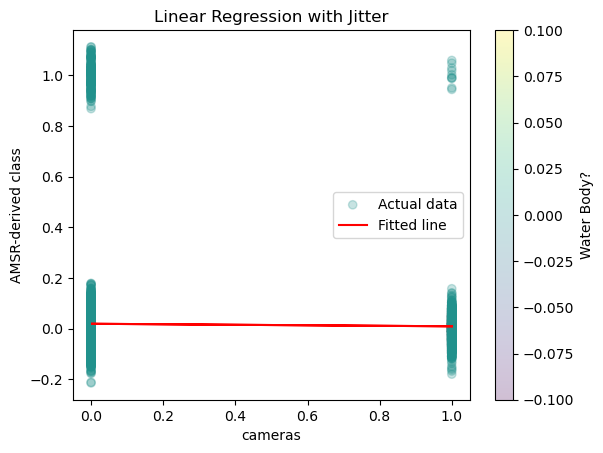

In [208]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Sample data
labeledimages_joined_cleaned = labeledimages_joined.dropna(subset=['raster_value'])  
X = np.array(labeledimages_joined_cleaned[['label_b']])
y = np.array(labeledimages_joined_cleaned['raster_value'])

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Predict values
y_pred = model.predict(X)

# Calculate R² score
r_squared = r2_score(y, y_pred)

print("R² value:", r_squared)
# Adding jitter to the x-values

jitter_strength = 0.05  # Adjust this value as needed for the amount of jitter
y_jittered = y + np.random.normal(0, jitter_strength, size=y.shape)

sc = plt.scatter(X, y_jittered, c=labeledimages_joined_cleaned['water'], cmap='viridis',
                 label='Actual data', alpha=0.25)
plt.plot(X, y_pred, color='red', label='Fitted line')
plt.xlabel('cameras')
plt.ylabel('AMSR-derived class')
plt.title('Linear Regression with Jitter')
plt.legend()
cbar = plt.colorbar(sc)
cbar.set_label('Water Body?')  # Label for the colorbar
plt.show()

In [209]:
### add labeled images to weather stations 

### this needs to be grouped .... 

labeledimages_joined_cleaned


,Unnamed: 0.1,Unnamed: 0,filename,label,cameraID,weatherstation,distance,hour,airtemp,precip,...,col,raster_value,grp_value,snow,sca,water,elev,tree,veg,nonvegs
0,3728,3728.0,1119_20190530 (420).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,642.0,0.0,-0.533630,0.0,39.0,0.0,0.0,0.0,0.0,0.0
1,3729,3729.0,1119_20190530 (452).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,642.0,0.0,0.168431,0.0,39.0,0.0,0.0,0.0,0.0,0.0
2,3730,3730.0,1119_20190530 (453).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,642.0,0.0,0.168431,0.0,39.0,0.0,0.0,0.0,0.0,0.0
3,3731,3731.0,1119_20190530 (454).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,642.0,0.0,0.168431,0.0,39.0,0.0,0.0,0.0,0.0,0.0
4,3732,3732.0,1119_20190530 (51).JPG,1,1119,NaN,NaN,NaN,NaN,NaN,...,642.0,0.0,0.158960,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26365,34419,NaN,728_20191215 (150).JPG,1,728,SN17875,29735.681359,20.0,3.1,4.6,...,631.0,0.0,0.082836,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26366,34420,NaN,728_20191215 (155).JPG,1,728,SN17875,29735.681359,20.0,3.1,4.6,...,631.0,0.0,0.082836,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26367,34421,NaN,728_20191215 (154).JPG,1,728,SN17875,29735.681359,20.0,3.1,4.6,...,631.0,0.0,0.082836,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26395,34449,NaN,747_20200122 (1020).JPG,2,747,SN66120,29933.733554,8.0,-0.3,4.5,...,512.0,0.0,-0.370467,0.0,255.0,0.0,0.0,0.0,0.0,100.0


In [210]:
#### with audio moths ### 
# 
weatherstation2023 = pd.read_csv('/Users/catherinebreen/Dropbox/Chapter4/trond_eve_weatherstation_data.csv')
cameratrapdata2023 = pd.read_csv('/Users/catherinebreen/Dropbox/Chapter4/LIBRARY_LABELS.csv')
weatherstation2023['date'] = [datetime.strptime(i, '%d.%m.%Y %H:%M').strftime('%Y-%m-%d') for i in weatherstation2023['Time(norwegian mean time)']]

In [211]:
cameratrapdata2023['date'] = [datetime.strptime(i.split('_')[3], '%m-%d-%y').strftime('%Y-%m-%d') for i in cameratrapdata2023['filename']]
cameratrapdata2023['county'] = [i.split('_')[0] for i in cameratrapdata2023['filename']]

print(cameratrapdata2023)

     Unnamed: 0                     filename  label  temp        date county
0             0   IN_N_K0380_02-02-23_11.JPG      0   -18  2023-02-02     IN
1             1   IN_N_K0380_02-02-23_12.JPG      0   -16  2023-02-02     IN
2             2   IN_N_K0380_02-02-23_13.JPG      0   -14  2023-02-02     IN
3             3   IN_N_K0380_02-02-23_14.JPG      0   -12  2023-02-02     IN
4             4   IN_N_K0380_02-02-23_15.JPG      0   -10  2023-02-02     IN
..          ...                          ...    ...   ...         ...    ...
867         867  TRO_S_K0060_03-27-23_03.JPG      0    -4  2023-03-27    TRO
868         868  TRO_S_K0060_03-27-23_04.JPG      0    -5  2023-03-27    TRO
869         869  TRO_S_K0060_03-27-23_06.JPG      0    -7  2023-03-27    TRO
870         870  TRO_S_K0060_03-27-23_07.JPG      0    -6  2023-03-27    TRO
871         871  TRO_S_K0060_03-27-23_08.JPG      0    -6  2023-03-27    TRO

[872 rows x 6 columns]


In [212]:
# Display the first few rows of the DataFrame
# print(points.head())

# Define the transformer from EPSG:4326 to EPSG:6931
transformer = Transformer.from_crs("epsg:4326", "epsg:6931", always_xy=True)

# Apply the transformation to each row in the DataFrame
weatherstation2023[['longitude_6931', 'latitude_6931']] = weatherstation2023.apply(
    lambda row: transformer.transform(row['longitude'], row['latitude']), axis=1, result_type='expand'
)

# Display the DataFrame with the new coordinates
print(weatherstation2023[['longitude_6931', 'latitude_6931']].head())
print(weatherstation2023[['longitude', 'latitude']].head())

   longitude_6931  latitude_6931
0   606561.724387  -3.097308e+06
1   606561.724387  -3.097308e+06
2   606561.724387  -3.097308e+06
3   606561.724387  -3.097308e+06
4   606561.724387  -3.097308e+06
   longitude  latitude
0    11.0803   61.4255
1    11.0803   61.4255
2    11.0803   61.4255
3    11.0803   61.4255
4    11.0803   61.4255


In [213]:
## point extraction 
import rasterio
from rasterio.transform import rowcol

################ point extraction for weather stations ################

### get transform ### 
transform1 = new_transform #ex_transform1

troeve2023 = weatherstation2023.drop_duplicates(subset=['longitude_6931','latitude_6931'])
troeve2023 = troeve2023[troeve2023['longitude_6931'] > 0]
# Loop through each point in the dataframe and extract raster values

ws_ids = []
dates = []
point = []
values = []
grpvalues = []
waters = []
elevs = []
cgfs = []
scas = []
trees = []
vegs = []
nonvegs = []
rows = []
cols = []

for date, array, grparray_, snowarray, scaarray in tqdm.tqdm(zip(rosdate, rosarray, grparray, cgfarrays, scaarrays)):
    for idx, row in troeve2023.iterrows():
        ws_id = row['Station']
        x, y = row['longitude_6931'], row['latitude_6931']  # These are the coordinates in EPSG:6931

        # Convert the coordinates (long_6931, lat_6931) to row/col in the raster
        col, row = rowcol(transform1, x, y) 
        col, row = col, row 

        # Check if the row/col are within the bounds of the array
      #  if 0 <= row < array.shape[0] and 0 <= col < array.shape[1]:
            # Extract the raster value at the given row/col
        value = array[col, row]
        grpvalue = grparray_[col, row]
        snow = snowarray[col,row]
        sca__ = scaarray[col, row]
        water_ = water_buffered_mask[col, row]
        elev_ = elev[col, row]
        tree_ = tree[col, row]
        veg_ = veg[col, row]
        nonveg_ = nonveg[col, row]

        rows.append(row)
        cols.append(col)

        # Append the value to the result lists
        ws_ids.append(ws_id)
        dates.append(date)
        point.append((x, y))  # You can append any relevant info here
        values.append(value)
        grpvalues.append(grpvalue)
        waters.append(water_)
        elevs.append(elev_)
        cgfs.append(snow)
        scas.append(sca__)
        trees.append(tree_), vegs.append(veg_), nonvegs.append(nonveg_)

# Convert the results into a pandas dataframe (optional)
results_df_ws2023 = pd.DataFrame({
    'id': ws_ids, 
    'date': dates,
    'coordinates': point,
    'row': rows,
    'col':cols,
    'raster_value': values,
    'grp_value': grpvalues,
    'snow':cgfs,
    'sca':scas,
    'water': waters,
    'elev': elevs,
    'tree': trees,
    'veg':vegs,
    'nonvegs':nonvegs
})

# Print or inspect the results
print(results_df_ws2023)

665it [00:00, 5365.32it/s]

           id        date                               coordinates  row  col  \
0      SN8140  2018-01-01   (606561.7243873132, -3097307.579789669)  478  574   
1      SN7420  2018-01-01  (630258.6365126293, -3097988.9941763342)  486  574   
2      SN7950  2018-01-01   (627595.6054536039, -3119636.294335196)  485  581   
3      SN8135  2018-01-01  (606849.4654722905, -3098002.8115494843)  478  574   
4     SN68120  2018-01-01    (529854.0371235951, -2898428.08064963)  452  508   
...       ...         ...                                       ...  ...  ...   
4650   SN7950  2023-04-30   (627595.6054536039, -3119636.294335196)  485  581   
4651   SN8135  2023-04-30  (606849.4654722905, -3098002.8115494843)  478  574   
4652  SN68120  2023-04-30    (529854.0371235951, -2898428.08064963)  452  508   
4653  SN68110  2023-04-30   (523951.3905817836, -2893393.737403186)  450  506   
4654  SN68125  2023-04-30   (528193.6306719453, -2892170.174884518)  452  506   

      raster_value  grp_val

In [214]:
print(cameratrapdata2023.head())
print(weatherstation2023.head())

   Unnamed: 0                    filename  label  temp        date county
0           0  IN_N_K0380_02-02-23_11.JPG      0   -18  2023-02-02     IN
1           1  IN_N_K0380_02-02-23_12.JPG      0   -16  2023-02-02     IN
2           2  IN_N_K0380_02-02-23_13.JPG      0   -14  2023-02-02     IN
3           3  IN_N_K0380_02-02-23_14.JPG      0   -12  2023-02-02     IN
4           4  IN_N_K0380_02-02-23_15.JPG      0   -10  2023-02-02     IN
  county      Name Station Time(norwegian mean time)  precip_1hr  \
0    inn  Evenstad  SN8140          22.01.2023 01:00         NaN   
1    inn  Evenstad  SN8140          22.01.2023 02:00         NaN   
2    inn  Evenstad  SN8140          22.01.2023 03:00         NaN   
3    inn  Evenstad  SN8140          22.01.2023 04:00         NaN   
4    inn  Evenstad  SN8140          22.01.2023 05:00         NaN   

   air_temp_1hr_C  snowdepth_1hr_cm  longitude  latitude        date  \
0           -25.8               NaN    11.0803   61.4255  2023-01-22   
1  

In [215]:
## now get the R2 between weather stations and the GRP
weatherstation2023_joined = weatherstation2023.merge(results_df_ws2023, left_on = ('Station', 'date'), right_on=('id','date'), how='left')
weatherstation2023_joined


,county,Name,Station,Time(norwegian mean time),precip_1hr,air_temp_1hr_C,snowdepth_1hr_cm,longitude,latitude,date,...,col,raster_value,grp_value,snow,sca,water,elev,tree,veg,nonvegs
0,inn,Evenstad,SN8140,22.01.2023 01:00,NaN,-25.8,NaN,11.0803,61.4255,2023-01-22,...,574.0,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0
1,inn,Evenstad,SN8140,22.01.2023 02:00,NaN,-25.9,NaN,11.0803,61.4255,2023-01-22,...,574.0,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0
2,inn,Evenstad,SN8140,22.01.2023 03:00,NaN,-26.4,NaN,11.0803,61.4255,2023-01-22,...,574.0,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0
3,inn,Evenstad,SN8140,22.01.2023 04:00,NaN,-27.1,NaN,11.0803,61.4255,2023-01-22,...,574.0,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0
4,inn,Evenstad,SN8140,22.01.2023 05:00,NaN,-27.7,NaN,11.0803,61.4255,2023-01-22,...,574.0,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16284,trond,Sverresborg,SN68125,01.05.2023 20:00,0.0,1.9,7.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16285,trond,Sverresborg,SN68125,01.05.2023 21:00,0.0,1.4,7.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16286,trond,Sverresborg,SN68125,01.05.2023 22:00,0.0,1.5,7.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16287,trond,Sverresborg,SN68125,01.05.2023 23:00,0.2,0.5,8.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [216]:
evenstad_df = weatherstation2023_joined[weatherstation2023_joined['Name'] == 'Evenstad']
rv3_evenstad_df = weatherstation2023_joined[weatherstation2023_joined['Name'] == 'Rv3 Evenstad']

# Merge based on matching 'Time(norwegian mean time)'
merged_df = pd.merge(evenstad_df, rv3_evenstad_df[['Time(norwegian mean time)', 'precip_1hr']],
                     on='Time(norwegian mean time)', how='left', suffixes=('', '_rv3'))

# Replace NaN precip_1hr in Evenstad with the values from Rv3 Evenstad
merged_df['precip_1hr'] = merged_df['precip_1hr'].fillna(merged_df['precip_1hr_rv3'])

# Drop the extra Rv3 precip column after filling the missing values
merged_df = merged_df.drop(columns=['precip_1hr_rv3'])
merged_df
weatherstation2023_joined.update(merged_df)

In [217]:
weatherstation2023_joined

,county,Name,Station,Time(norwegian mean time),precip_1hr,air_temp_1hr_C,snowdepth_1hr_cm,longitude,latitude,date,...,col,raster_value,grp_value,snow,sca,water,elev,tree,veg,nonvegs
0,inn,Evenstad,SN8140,22.01.2023 01:00,0.0,-25.8,NaN,11.0803,61.4255,2023-01-22,...,574.0,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0
1,inn,Evenstad,SN8140,22.01.2023 02:00,0.0,-25.9,NaN,11.0803,61.4255,2023-01-22,...,574.0,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0
2,inn,Evenstad,SN8140,22.01.2023 03:00,0.0,-26.4,NaN,11.0803,61.4255,2023-01-22,...,574.0,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0
3,inn,Evenstad,SN8140,22.01.2023 04:00,0.0,-27.1,NaN,11.0803,61.4255,2023-01-22,...,574.0,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0
4,inn,Evenstad,SN8140,22.01.2023 05:00,0.0,-27.7,NaN,11.0803,61.4255,2023-01-22,...,574.0,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16284,trond,Sverresborg,SN68125,01.05.2023 20:00,0.0,1.9,7.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16285,trond,Sverresborg,SN68125,01.05.2023 21:00,0.0,1.4,7.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16286,trond,Sverresborg,SN68125,01.05.2023 22:00,0.0,1.5,7.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16287,trond,Sverresborg,SN68125,01.05.2023 23:00,0.2,0.5,8.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [218]:
pd.unique(weatherstation2023_joined['Name'])

array(['Evenstad', 'Rena - Ørnhaugen', 'Rena Flyplass', 'Rv3 Evenstad',
       'Saupstad', 'Skistua', 'Sverresborg'], dtype=object)

In [219]:
weatherstation2023_joined[weatherstation2023_joined['air_temp_1hr_C']>1]

,county,Name,Station,Time(norwegian mean time),precip_1hr,air_temp_1hr_C,snowdepth_1hr_cm,longitude,latitude,date,...,col,raster_value,grp_value,snow,sca,water,elev,tree,veg,nonvegs
78,inn,Evenstad,SN8140,25.01.2023 07:00,0.0,1.5,NaN,11.0803,61.4255,2023-01-25,...,574.0,0.0,-0.738388,NaN,255.0,0.0,0.0,0.0,0.0,0.0
79,inn,Evenstad,SN8140,25.01.2023 08:00,0.0,1.9,NaN,11.0803,61.4255,2023-01-25,...,574.0,0.0,-0.738388,NaN,255.0,0.0,0.0,0.0,0.0,0.0
80,inn,Evenstad,SN8140,25.01.2023 09:00,0.0,2.3,NaN,11.0803,61.4255,2023-01-25,...,574.0,0.0,-0.738388,NaN,255.0,0.0,0.0,0.0,0.0,0.0
81,inn,Evenstad,SN8140,25.01.2023 10:00,0.0,2.1,NaN,11.0803,61.4255,2023-01-25,...,574.0,0.0,-0.738388,NaN,255.0,0.0,0.0,0.0,0.0,0.0
82,inn,Evenstad,SN8140,25.01.2023 11:00,0.0,1.9,NaN,11.0803,61.4255,2023-01-25,...,574.0,0.0,-0.738388,NaN,255.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16282,trond,Sverresborg,SN68125,01.05.2023 18:00,0.0,2.9,7.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16283,trond,Sverresborg,SN68125,01.05.2023 19:00,0.0,3.3,7.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16284,trond,Sverresborg,SN68125,01.05.2023 20:00,0.0,1.9,7.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16285,trond,Sverresborg,SN68125,01.05.2023 21:00,0.0,1.4,7.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [220]:
weatherstation2023_joined['rain_on_snow2'] = ((weatherstation2023_joined['air_temp_1hr_C'] > 1) & 
                       (weatherstation2023_joined['precip_1hr'] > 1)).astype(int) #  & 
                       #(weatherstation2023_joined['snowdepth_1hr_cm'] > 5)).astype(int)

In [221]:
weatherstation2023_joined


,county,Name,Station,Time(norwegian mean time),precip_1hr,air_temp_1hr_C,snowdepth_1hr_cm,longitude,latitude,date,...,raster_value,grp_value,snow,sca,water,elev,tree,veg,nonvegs,rain_on_snow2
0,inn,Evenstad,SN8140,22.01.2023 01:00,0.0,-25.8,NaN,11.0803,61.4255,2023-01-22,...,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0
1,inn,Evenstad,SN8140,22.01.2023 02:00,0.0,-25.9,NaN,11.0803,61.4255,2023-01-22,...,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0
2,inn,Evenstad,SN8140,22.01.2023 03:00,0.0,-26.4,NaN,11.0803,61.4255,2023-01-22,...,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0
3,inn,Evenstad,SN8140,22.01.2023 04:00,0.0,-27.1,NaN,11.0803,61.4255,2023-01-22,...,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0
4,inn,Evenstad,SN8140,22.01.2023 05:00,0.0,-27.7,NaN,11.0803,61.4255,2023-01-22,...,0.0,-3.594333,0.0,255.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16284,trond,Sverresborg,SN68125,01.05.2023 20:00,0.0,1.9,7.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
16285,trond,Sverresborg,SN68125,01.05.2023 21:00,0.0,1.4,7.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
16286,trond,Sverresborg,SN68125,01.05.2023 22:00,0.0,1.5,7.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
16287,trond,Sverresborg,SN68125,01.05.2023 23:00,0.2,0.5,8.0,10.3498,63.4223,2023-05-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [222]:
# Group by 'date' and 'id'
#ws_grouped_df = weatherstation2023_joined.groupby(['date', 'Station']) #.mean().reset_index()
ws_grouped_df = weatherstation2023_joined.groupby(['date', 'Station']).agg({
    'county':lambda x: x.mode()[0],
    'precip_1hr': 'sum',              # Sum precip
    'air_temp_1hr_C': 'mean',
    'snowdepth_1hr_cm': 'mean',        
    'raster_value': 'mean',       # Mean of raster value
    'rain_on_snow2': 'sum',  
    'grp_value':'mean' ,
    'elev':'mean',
    'water':'mean',
    'tree':'mean',
    'veg':'mean',
    'nonvegs':'mean',
    'sca':'mean',
    'snow': 'mean'       
}).reset_index()

ws_grouped_df

,date,Station,county,precip_1hr,air_temp_1hr_C,snowdepth_1hr_cm,raster_value,rain_on_snow2,grp_value,elev,water,tree,veg,nonvegs,sca,snow
0,2023-01-22,SN68110,trond,0.0,-1.491304,64.869565,0.0,0,-0.021596,0.0,0.0,0.0,0.0,0.0,255.0,0.0
1,2023-01-22,SN68120,trond,0.0,-3.726087,25.000000,0.0,0,-0.170802,0.0,0.0,0.0,0.0,100.0,255.0,0.0
2,2023-01-22,SN68125,trond,0.0,-4.278261,37.000000,0.0,0,-0.036048,0.0,0.0,0.0,0.0,100.0,255.0,0.0
3,2023-01-22,SN7420,inn,0.0,-8.173913,120.382609,0.0,0,-2.435504,0.0,0.0,0.0,0.0,0.0,255.0,0.0
4,2023-01-22,SN7950,inn,0.0,-24.113043,NaN,0.0,0,10.838133,0.0,0.0,0.0,0.0,0.0,255.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,2023-05-02,SN68120,trond,0.1,1.100000,0.000000,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
685,2023-05-02,SN68125,trond,0.2,0.400000,8.000000,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
686,2023-05-02,SN7420,inn,0.0,-5.000000,136.900000,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
687,2023-05-02,SN8135,inn,0.0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


R² value: 0.00033878941418463704


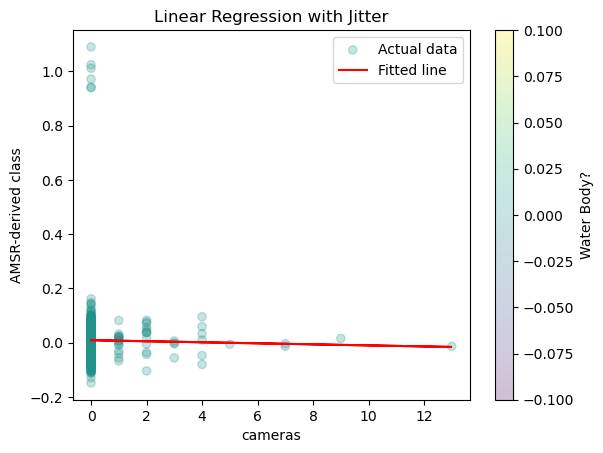

In [223]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Sample data
ws_grouped_df = ws_grouped_df.dropna(subset=['raster_value','rain_on_snow2'])
                                            #   'air_temp_1hr_C','precip_1hr', 'snowdepth_1hr_cm'])   
X = np.array(ws_grouped_df[['rain_on_snow2']])
y = np.array(ws_grouped_df['raster_value'])

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Predict values
y_pred = model.predict(X)

# Calculate R² score
r_squared = r2_score(y, y_pred)

print("R² value:", r_squared)
# Adding jitter to the x-values

jitter_strength = 0.05  # Adjust this value as needed for the amount of jitter
y_jittered = y + np.random.normal(0, jitter_strength, size=y.shape)

sc = plt.scatter(X, y_jittered, c=ws_grouped_df['water'], cmap='viridis',
                 label='Actual data', alpha=0.25)
plt.plot(X, y_pred, color='red', label='Fitted line')
plt.xlabel('cameras')
plt.ylabel('AMSR-derived class')
plt.title('Linear Regression with Jitter')
plt.legend()
cbar = plt.colorbar(sc)
cbar.set_label('Water Body?')  # Label for the colorbar
plt.show()

/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_46249/3092679465.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws_grouped_df['rain_on_snow2_b'] = [1 if i > 1 else 0 for i in ws_grouped_df['rain_on_snow2']]


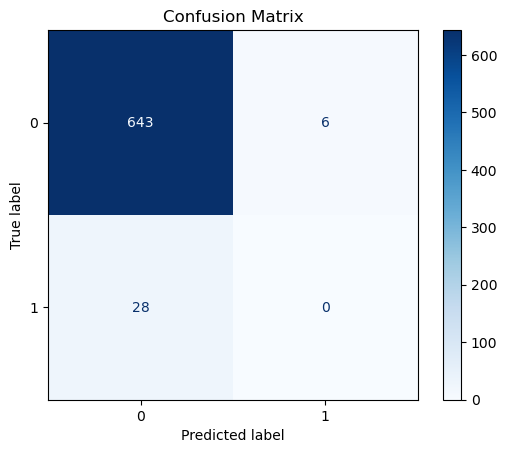

True Positive Rate (TPR): 0.0
False Positive Rate (FPR): 0.009244992295839754


In [224]:
## confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
ws_grouped_df['rain_on_snow2_b'] = [1 if i > 1 else 0 for i in ws_grouped_df['rain_on_snow2']]

X = np.array(ws_grouped_df['rain_on_snow2_b'])
y = np.array(ws_grouped_df['raster_value'])
cm = confusion_matrix(X, y)

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()  # For binary classification

# Calculate TPR and FPR
TPR = TP / (TP + FN) if (TP + FN) > 0 else 0 
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  

print(f'True Positive Rate (TPR): {TPR}')
print(f'False Positive Rate (FPR): {FPR}')

/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_46249/1295107602.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws_grouped_df['date'] = pd.to_datetime(ws_grouped_df['date'])


Text(0.5, 1.0, 'Jan-Apr 2023')

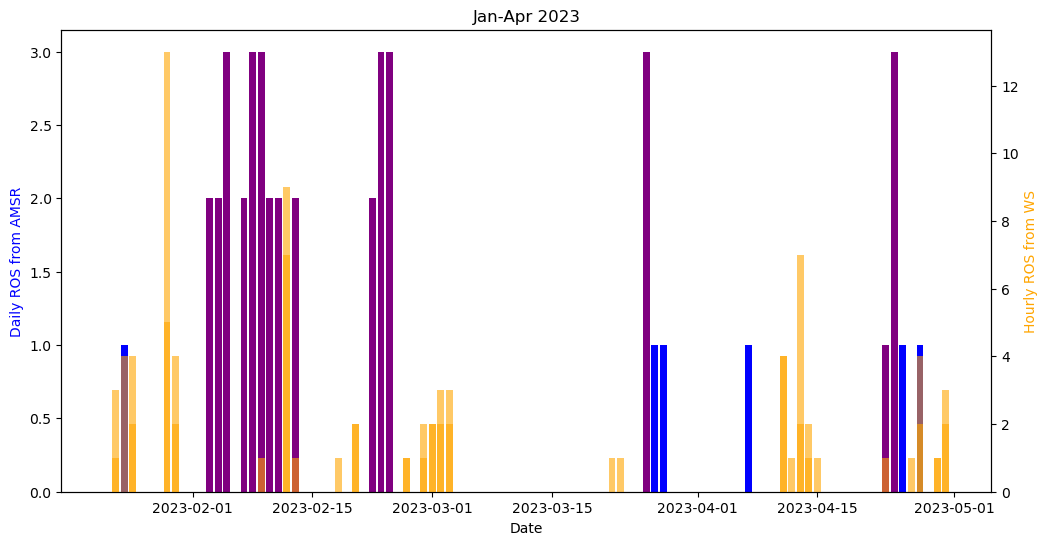

In [225]:
ws_grouped_df['date'] = pd.to_datetime(ws_grouped_df['date'])

fig, ax = plt.subplots(figsize=(12,6))  # Create a new figure and primary axis
ax.bar(ws_grouped_df['date'], ws_grouped_df['raster_value'], label='Raster Value', color='blue')
ax.bar(cameratrapdata2023['date'], cameratrapdata2023['label'], label = 'Camera Value', color = 'purple')
ax1 = ax.twinx()
ax1.bar(ws_grouped_df['date'], ws_grouped_df['rain_on_snow2'], label='Rain on Snow', color='orange', alpha=0.6)
ax.set_xlabel('Date')
ax.set_ylabel('Daily ROS from AMSR', color='blue')
ax1.set_ylabel('Hourly ROS from WS', color='orange')
plt.title('Jan-Apr 2023')

/var/folders/yv/mzlh10ts71lg0nhr7pw_0q080000gn/T/ipykernel_46249/4158446774.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ws_grouped_df['date'] = pd.to_datetime(ws_grouped_df['date'])


Text(0, 0.5, 'Hourly ROS from WS (TRO)')

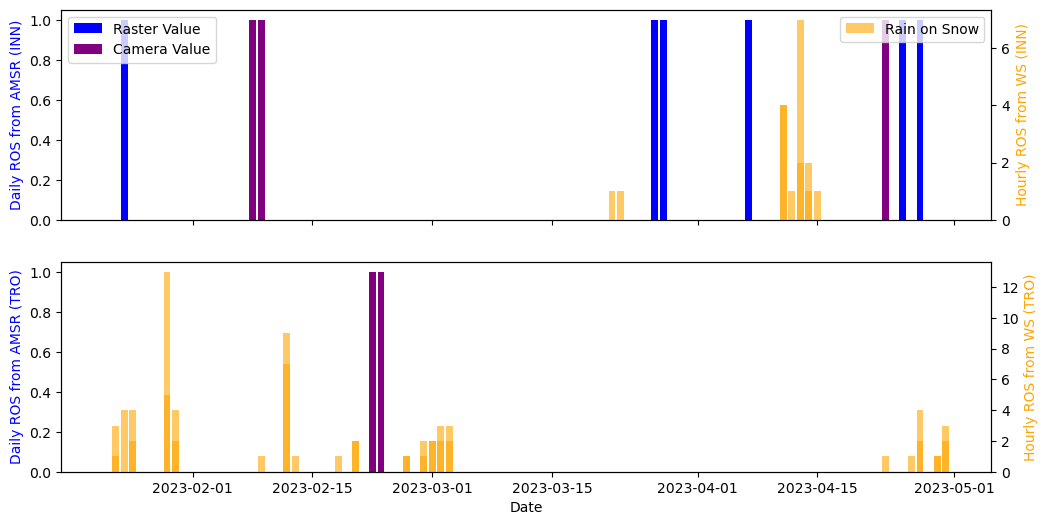

In [226]:
import matplotlib.pyplot as plt

# Ensure dates are in datetime format
ws_grouped_df['date'] = pd.to_datetime(ws_grouped_df['date'])
cameratrapdata2023['date'] = pd.to_datetime(cameratrapdata2023['date'])
cameratrapdata2023['labels_R'] = [0 if i != 1 else i for i in cameratrapdata2023['label']]

# Create a figure with two vertically stacked subplots
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Plot for county 'INN'
inn_ws = ws_grouped_df[ws_grouped_df['county'] == 'inn']
inn_camera = cameratrapdata2023[cameratrapdata2023['county'] == 'IN']

ax[0].bar(inn_ws['date'], inn_ws['raster_value'], label='Raster Value', color='blue')
ax[0].bar(inn_camera['date'], inn_camera['labels_R'], label='Camera Value', color='purple')
ax0_twin = ax[0].twinx()  # Secondary y-axis
ax0_twin.bar(inn_ws['date'], inn_ws['rain_on_snow2'], label='Rain on Snow', color='orange', alpha=0.6)
ax[0].set_ylabel('Daily ROS from AMSR (INN)', color='blue')
ax0_twin.set_ylabel('Hourly ROS from WS (INN)', color='orange')
ax[0].legend(loc='upper left')
ax0_twin.legend(loc='upper right')

# Plot for county 'TRO'
tro_ws = ws_grouped_df[ws_grouped_df['county'] == 'trond']
tro_camera = cameratrapdata2023[cameratrapdata2023['county'] == 'TRO']

ax[1].bar(tro_ws['date'], tro_ws['raster_value'], label='Raster Value', color='blue')
ax[1].bar(tro_camera['date'], tro_camera['labels_R'], label='Camera Value', color='purple')
ax1_twin = ax[1].twinx()  # Secondary y-axis
ax1_twin.bar(tro_ws['date'], tro_ws['rain_on_snow2'], label='Rain on Snow', color='orange', alpha=0.6)
ax[1].set_xlabel('Date')
ax[1].set_ylabel('Daily ROS from AMSR (TRO)', color='blue')
ax1_twin.set_ylabel('Hourly ROS from WS (TRO)', color='orange')


In [228]:
#### era csv
eradata = pd.read_csv('/Users/catherinebreen/Downloads/ERA5_Land_Hourly_Weather_Stations_500m_test.csv')
eradata_loc = pd.read_csv('/Users/catherinebreen/Dropbox/Chapter4/ws_28_gee.csv')

transformer = Transformer.from_crs("epsg:4326", "epsg:6931", always_xy=True)
eradata_loc[['longitude_6931', 'latitude_6931']] = eradata_loc.apply(
    lambda row: transformer.transform(row['longitude'], row['latitude']), axis=1, result_type='expand'
)
print(eradata_loc[['longitude_6931', 'latitude_6931']].head())
print(eradata_loc[['longitude', 'latitude']].head())

   longitude_6931  latitude_6931
0   625997.501209  -3.287267e+06
1   656601.405502  -2.433165e+06
2   613079.292096  -3.254208e+06
3   620604.808668  -3.238988e+06
4   587188.214227  -3.241968e+06
   longitude   latitude
0  10.781800  59.660500
1  15.101824  67.276416
2  10.669232  59.984799
3  10.846670  60.110670
4  10.266170  60.140330


In [229]:
eradata = pd.merge(eradata, eradata_loc, left_on = 'station_id', right_on = 'id')
eradata.head()

,station_id,date,hour,snow_depth,precipitation,temperature,Unnamed: 0,id,longitude,latitude,longitude_6931,latitude_6931
0,SN17850,2017-10-01,0,-7.345365e-24,0.000176,282.799500,0,SN17850,10.7818,59.6605,625997.501209,-3.287267e+06
1,SN17850,2017-10-01,1,-7.345365e-24,0.000003,282.609131,0,SN17850,10.7818,59.6605,625997.501209,-3.287267e+06
2,SN17850,2017-10-01,2,-7.345365e-24,0.000009,282.801895,0,SN17850,10.7818,59.6605,625997.501209,-3.287267e+06
3,SN17850,2017-10-01,3,-7.345365e-24,0.000018,282.863998,0,SN17850,10.7818,59.6605,625997.501209,-3.287267e+06
4,SN17850,2017-10-01,4,-7.345365e-24,0.000075,283.041321,0,SN17850,10.7818,59.6605,625997.501209,-3.287267e+06


In [230]:
eradata_grouped = eradata.groupby(['date', 'station_id']).agg({
    'latitude':'mean',
    'longitude':'mean',
    'precipitation': 'sum',              # Sum precip
    'temperature': 'max',
    'snow_depth': 'max',   
    'longitude':'mean',
    'latitude':'mean'    
}).reset_index()
eradata_grouped.head()

eradata_grouped['temp_C'] = [i - 273 for i in eradata_grouped['temperature']]

(array([1.11878e+05, 2.34710e+04, 1.64540e+04, 4.66800e+03, 1.78500e+03,
        1.17400e+03, 6.58000e+02, 1.77000e+02, 1.30000e+01, 3.20000e+01]),
 array([-7.34536472e-24,  4.06640625e-01,  8.13281250e-01,  1.21992187e+00,
         1.62656250e+00,  2.03320312e+00,  2.43984375e+00,  2.84648437e+00,
         3.25312500e+00,  3.65976562e+00,  4.06640625e+00]),
 <BarContainer object of 10 artists>)

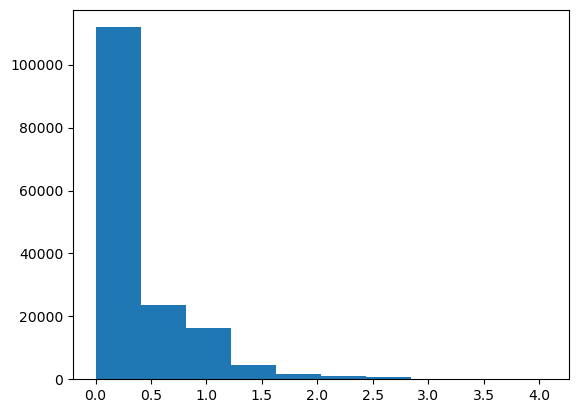

In [231]:
plt.hist(eradata_grouped['snow_depth'])

In [312]:
eradata_grouped['rain_on_snowERA'] = ((eradata_grouped['precipitation'] > 0.05) & ## cohen paper ## m!!
                    (eradata_grouped['temp_C'] >= 1) &
                    (eradata_grouped['snow_depth'] > 0.05)).astype(int) # & ### snow depth in m!!
                  #  (grouped_df['precip_day_before'] < 5)).astype(int)

eradata_grouped['date'] = pd.to_datetime(eradata_grouped['date'] )


In [313]:
grouped_df['date'] = grouped_df['date'].astype(str)
eradata_grouped['date'] = eradata_grouped['date'].astype(str)

In [314]:
grouped_df_ws_era = pd.merge(grouped_df, eradata_grouped, left_on = ['id','date'], right_on = ['station_id','date'])
grouped_df_ws_era['rain_on_snow3'] = grouped_df_ws_era['rain_on_snow3'].astype(int)

In [315]:
grouped_df_ws_era.head()

,date,id,latitude_x,longitude_x,precip,air_temp10M,snowdepth,raster_value,ros_event,ros_event75,...,dist_ws,filenames,station_id,latitude_y,longitude_y,precipitation,temperature,snow_depth,temp_C,rain_on_snowERA
0,2017-10-01,SN11500,60.7002,10.8695,0.4,11.3,NaN,NaN,NaN,NaN,...,None,None,SN11500,60.7002,10.8695,0.052744,283.065338,-7.345365e-24,10.065338,0
1,2017-10-01,SN12550,60.7733,10.8055,1.1,12.3,NaN,NaN,NaN,NaN,...,None,None,SN12550,60.7733,10.8055,0.057391,282.822723,-7.345365e-24,9.822723,0
2,2017-10-01,SN12700,61.1040,10.5112,0.0,NaN,NaN,NaN,NaN,NaN,...,None,None,SN12700,61.1040,10.5112,0.134316,280.972839,-7.345365e-24,7.972839,0
3,2017-10-01,SN17050,59.3188,10.8145,7.0,14.5,NaN,NaN,NaN,NaN,...,None,None,SN17050,59.3188,10.8145,0.091332,286.057907,-7.345365e-24,13.057907,0
4,2017-10-01,SN17150,59.3742,10.7980,1.8,13.8,NaN,NaN,NaN,NaN,...,None,None,SN17150,59.3742,10.7980,0.080074,285.977829,-7.345365e-24,12.977829,0


In [316]:
grouped_df_ws_era.head()
grouped_df_ws_era['rain_on_snow4'] = ((grouped_df_ws_era['precip'] > 0.05) & ## cohen paper ## m!!
                    (grouped_df_ws_era['air_temp10M'] >= 1) &
                    (grouped_df_ws_era['snowdepth'] > 0.05)).astype(int)

(array([102932.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   5939.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

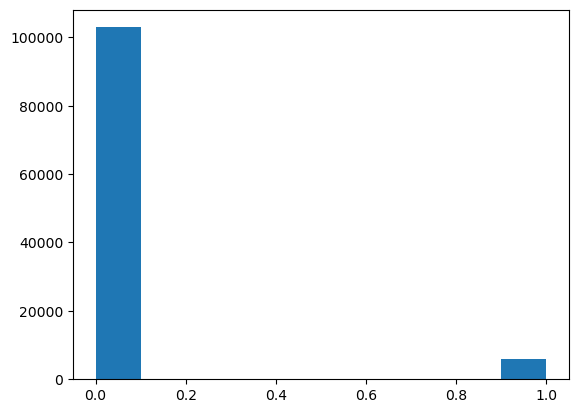

In [317]:
plt.hist(grouped_df_ws_era['rain_on_snowERA'])

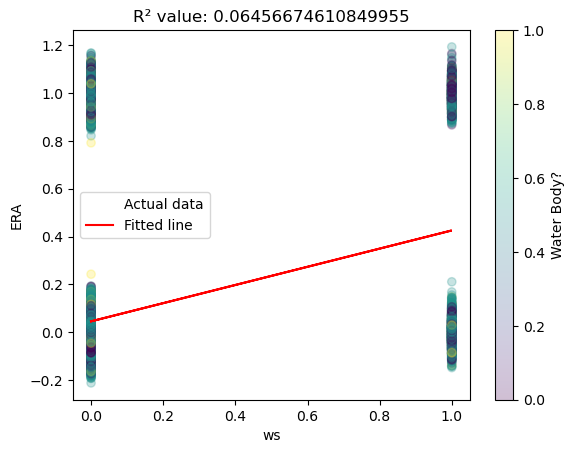

In [325]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Sample data
#grouped_df_ws_era_clean = grouped_df_ws_era.dropna(subset=['raster_value'])  
X = np.array(grouped_df_ws_era[['rain_on_snow3']]) #rain_on_snow3
y = np.array(grouped_df_ws_era['rain_on_snowERA'])

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Predict values
y_pred = model.predict(X)

# Calculate R² score
r_squared = r2_score(y, y_pred)
jitter_strength = 0.05  # Adjust this value as needed for the amount of jitter
y_jittered = y + np.random.normal(0, jitter_strength, size=y.shape)

sc = plt.scatter(X, y_jittered, c=grouped_df_ws_era['water'], cmap='viridis',
                 label='Actual data', alpha=0.25)
plt.plot(X, y_pred, color='red', label='Fitted line')
plt.xlabel('ws')
plt.ylabel('ERA')
plt.title(f"R² value: {r_squared}")
plt.legend()
cbar = plt.colorbar(sc)
cbar.set_label('Water Body?')  # Label for the colorbar
plt.show()

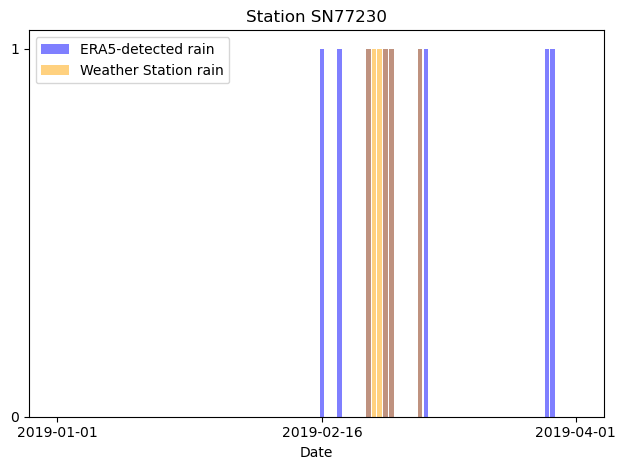

In [337]:
import matplotlib.pyplot as plt
import pandas as pd

# List of station IDs to plot
stations = ['SN77230']
#['SN37070', 'SN77230', 'SN27460']

# Convert 'date' column to datetime if not already
grouped_df_ws_era['date'] = pd.to_datetime(grouped_df_cleaned['date'])

# Filter data by date range (water year) and station
water_year = grouped_df_ws_era[(grouped_df_ws_era['date'] >= '2019-01-01') & (grouped_df_ws_era['date'] <= '2019-04-01')]

# Ensure the correct station variable
station = stations[0]  # If using a single station from the list
station_data = water_year[water_year['id'] == station]

# Create a figure and axis
fig, ax = plt.subplots()

# Plot AMSR-detected ROS on the primary axis
# ax.plot(pd.to_datetime(station_data['date']), 
#         station_data['grp_value'], 
#         color='blue', alpha=0.5, label='GRP Value')

# Set primary y-axis limits and labels
# c.set_ylim([-5, 5])
# ax.set_yticks([-5, 0, 5])
# ax.set_ylabel('Mean GRP [unitless]')
# ax.axhline(y=1, color='purple', linestyle='--')

# Create a secondary axis for the weather station ROS
# Plot weather station ROS data
ax.bar(pd.to_datetime(station_data['date']), 
        station_data['rain_on_snowERA'], 
        color='blue', alpha=0.5, label='ERA5-detected rain')
ax.bar(pd.to_datetime(station_data['date']), 
        station_data['rain_on_snow3'], 
        color='orange', alpha=0.5, label='Weather Station rain')

ax.set_yticks([0, 1])

# Set the title and labels
plt.title(f'Station {station}')
ax.set_xlabel('Date')

xtick_positions = pd.to_datetime(station_data['date']).iloc[[0, len(station_data)//2, -1]]
ax.set_xticks(xtick_positions)
ax.set_xticklabels([xtick.strftime('%Y-%m-%d') for xtick in xtick_positions])


# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()  # Get labels for primary axis
ax.legend(lines , labels , loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


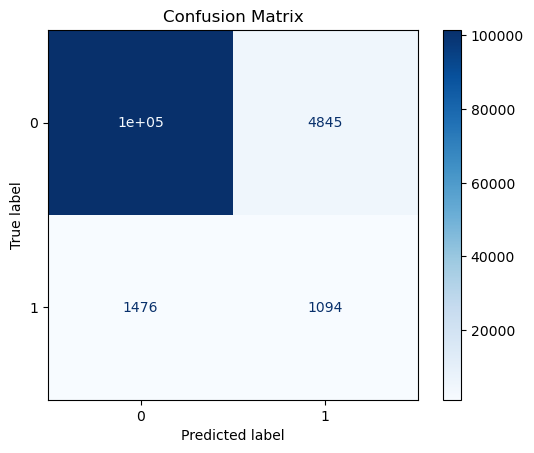

True Positive Rate (TPR): 0.42568093385214006
False Positive Rate (FPR): 0.04557812250119942


In [326]:
## confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calculate the confusion matrix
grouped_df_ws_era['rain_on_snow4'] = [1 if i > 1 else 0 for i in grouped_df_ws_era['rain_on_snow4']]

X = np.array(grouped_df_ws_era['rain_on_snow3'])
y = np.array(grouped_df_ws_era['rain_on_snowERA'])
cm = confusion_matrix(X, y)

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Extract TP, TN, FP, FN
TN, FP, FN, TP = cm.ravel()  # For binary classification

# Calculate TPR and FPR
TPR = TP / (TP + FN) if (TP + FN) > 0 else 0 
FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  

print(f'True Positive Rate (TPR): {TPR}')
print(f'False Positive Rate (FPR): {FPR}')

## True Positive Rate (TPR): 0.5497896213183731
# False Positive Rate (FPR): 0.06951449954619172

In [329]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

 
#val['rain_on_snow2_b'] = [1 if i >=1 else 0 for i in val['rain_Lund']]
actual = grouped_df_ws_era['rain_on_snow3']  # Replace with your actual binary labels (0 or 1)
predicted = grouped_df_ws_era['rain_on_snowERA' ]  # Replace with your model's binary predictions (0 or 1)  #ros_event_drysnowcheck

# Calculate various metrics
accuracy = accuracy_score(actual, predicted)
precision = precision_score(actual, predicted)
recall = recall_score(actual, predicted)
f1 = f1_score(actual, predicted)
roc_auc = roc_auc_score(actual, predicted)
mcc = matthews_corrcoef(actual, predicted)

# Print the results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(f'Matthews Correlation Coefficient (MCC): {mcc:.4f}')

Accuracy: 0.9419
Precision: 0.1842
Recall: 0.4257
F1 Score: 0.2571
ROC AUC: 0.6901
Matthews Correlation Coefficient (MCC): 0.2541


In [309]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Sample data
#grouped_df_ws_era_clean = grouped_df_ws_era.dropna(subset=['raster_value'])  
X = np.array(grouped_df_ws_era[['raster_value']]) #rain_on_snow3
y = np.array(grouped_df_ws_era['rain_on_snowERA'])

# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, y)

# Predict values
y_pred = model.predict(X)

# Calculate R² score
r_squared = r2_score(y, y_pred)
jitter_strength = 0.05  # Adjust this value as needed for the amount of jitter
y_jittered = y + np.random.normal(0, jitter_strength, size=y.shape)

sc = plt.scatter(X, y_jittered, c=grouped_df_ws_era['water'], cmap='viridis',
                 label='Actual data', alpha=0.25)
plt.plot(X, y_pred, color='red', label='Fitted line')
plt.xlabel('ws')
plt.ylabel('ERA')
plt.title(f"R² value: {r_squared}")
plt.legend()
cbar = plt.colorbar(sc)
cbar.set_label('Water Body?')  # Label for the colorbar
plt.show()

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
### adding camera data
valid_samples = pd.read_csv('/Users/catherinebreen/Dropbox/Chapter4/WEATHER_MODEL/classifier_results/baseline_4_001_wslab_50cams_snowis0/valid_samples.csv')
